In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
# cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

import sys                                                                   #
sys.path.append('/Users/theoares/lqcd/utilities')                            #
from formattools import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [3]:
Lat = Lattice(32, 48)
get_energy_scale(np.array([4, 4, 0, 0]), 0.145, Lat)

1.4730014186696363

In [5]:
fpath = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/nnpp/cl3_32_48_b6p1_m0p2450_99999/Z_gamma.h5'
F = h5py.File(fpath, 'r')
Lat = Lattice(32, 48)
a = 0.145  # fm
ainv = hbarc / a
k_list = F['momenta'][()]
mom_list = [Lat.to_linear_momentum(k, datatype=np.float64) for k in k_list]
mu_list = np.array([get_energy_scale(q, a, Lat) for q in k_list])
Zq = np.real(F['Zq'][()])
n_momenta, n_boot = Zq.shape[0], Zq.shape[1]
ZV = np.real(F['ZV'][()])
ZA = np.real(F['ZA'][()])
Z = np.zeros((5, 5, n_momenta, n_boot), dtype = np.float64)
for i, j in itertools.product(range(5), repeat = 2):
    key = 'Z' + str(i + 1) + str(j + 1)
    Z[i, j] = np.real(F[key][()])

In [12]:
for ii, mu in enumerate(mu_list):
    print('Momenta: ' + str(k_list[ii]))
    print('Scale: ' + str(mu))
    print('Mean of Zij[mu] = ' + str(np.mean(Z, axis = 3)[:, :, ii]))
np.mean(Z, axis = 3)[0, 0]

Momenta: [1 1 0 0]
Scale: 0.37728151926274656
Mean of Zij[mu] = [[ 1.68426015 -0.70916283  0.80031018  1.20985806  1.22413745]
 [-0.63013866  1.42859623  1.12155069  0.85724852 -0.9481267 ]
 [ 0.22142642  0.24761224  1.23189577  1.2332811  -0.04951746]
 [ 0.29388564  0.17955505  1.02438919  1.50921056  0.00992408]
 [ 0.9314604  -0.72288655  0.06152147 -0.00259771  1.73588725]]
Momenta: [2 2 0 0]
Scale: 0.7509296112519351
Mean of Zij[mu] = [[-2.1102579   1.30924055 -1.61666218 -2.2401345  -2.65800473]
 [ 1.18810863 -0.7223108  -0.71256342 -1.06679597  2.04578901]
 [-0.55815338 -0.08314911 -0.69669318 -1.2816194  -0.27563976]
 [-0.58865407 -0.10885285 -1.11095136 -0.85431317 -0.44042692]
 [-1.98454253  1.53856104 -0.30367266 -1.14967987 -1.6728169 ]]
Momenta: [3 3 0 0]
Scale: 1.1173458405848855
Mean of Zij[mu] = [[ 4.00895082 -1.65572184  2.10931809  3.12914586  3.6611475 ]
 [-1.55118689  0.48204211 -3.16252853 -4.59144038 -0.37340221]
 [ 0.89670524 -0.96680352  0.07681436 -0.45281972  1

array([ 1.68426015, -2.1102579 ,  4.00895082,  2.19188371,  2.3748273 ,
        3.96817671])

In [2]:
ensembles = ['24I/ml0p005/', '24I/ml0p01/', '32I/ml0p004/', '32I/ml0p006/']
Lats = [Lattice(24, 64), Lattice(24, 64), Lattice(32, 64), Lattice(32, 64)]
ainv_list = [1.784, 1.784, 2.382, 2.382]    # GeV
mpi_list = [0.3396, 0.4322, 0.3020, 0.3597]    # GeV
a_list = [hbarc / ainv for ainv in ainv_list]
n_ens = len(ensembles)
ampi_list = [mpi_list[i] / ainv_list[i] for i in range(n_ens)]
δainv = np.array([0.005, 0.005, 0.008, 0.008])
δa = hbarc / (np.array(ainv_list) ** 2) * δainv

colors = ['r', 'b', 'c', 'g']

file_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/' + ens + 'Z_gamma.h5' for ens in ensembles]
Fs = [h5py.File(fpath, 'r') for fpath in file_paths]
k_list = [f['momenta'][()] for f in Fs]
mom_list = [[Lats[i].to_linear_momentum(k, datatype=np.float64) for k in k_list[i]] for i in range(n_ens)]
mu_list = [np.array([get_energy_scale(q, a_list[i], Lats[i]) for q in k_list[i]]) for i in range(n_ens)]
Zq_list = [np.real(f['Zq'][()]) for f in Fs]
n_momenta, n_boot = [Zq.shape[0] for Zq in Zq_list], [Zq.shape[1] for Zq in Zq_list]
ZV_list = [np.real(f['ZV'][()]) for f in Fs]
ZA_list = [np.real(f['ZA'][()]) for f in Fs]
Z_list = []
for idx in range(n_ens):
    Z = np.zeros((5, 5, n_momenta[idx], n_boot[idx]), dtype = np.float64)
    f = Fs[idx]
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        Z[i, j] = np.real(f[key][()])
    Z_list.append(Z)

In [3]:
a_list

[0.11060930493273542,
 0.11060930493273542,
 0.0828408900083963,
 0.0828408900083963]

In [4]:
δa

array([0.00031   , 0.00031   , 0.00027822, 0.00027822])

In [5]:
mu_list[0]

array([1.30597864, 1.93098769, 2.522957  , 3.07175781, 3.568     ,
       4.00319272, 4.3698897 , 4.66181666])

In [6]:
# read out chiral extrap data
n_spacings = 2
n_ens_sp = 2    # 2 ensembles per lattice spacing
n_mom = n_momenta[0]
Lat_24I = Lattice(24, 64)
Lat_32I = Lattice(32, 64)
Z_extrap = np.zeros((n_spacings, 5, 5, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
Z_extrap_mu = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)          # [24I/32I, i, j, q_idx]
Z_extrap_sigma = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)
chi_extrap_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap_const.h5', \
                    '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap_const.h5']
for idx in range(2):
    f = h5py.File(chi_extrap_paths[idx], 'r')
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        try:
            Z_extrap[idx, i, j] = np.real(f[key][()])
        except:
            print('no key at ' + key)
for sp_idx in range(n_spacings):
    for i, j in itertools.product(range(5), repeat = 2):
        for mom_idx in range(n_mom):
            Z_tmp = Superboot(n_ens_sp)
            Z_tmp.boots = Z_extrap[sp_idx, i, j, mom_idx]
            Z_extrap_mu[sp_idx, i, j, mom_idx] = Z_tmp.compute_mean()
            Z_extrap_sigma[sp_idx, i, j, mom_idx] = Z_tmp.compute_std()
stagger = 1e-5    # offsets the chiral extrap from the original data so you can see the errorbar difference
k_list_chiral = f['momenta'][()]
f.close()
mom_list_24I = [Lat_24I.to_linear_momentum(k, datatype = np.float64) for k in k_list_chiral]
mom_list_32I = [Lat_32I.to_linear_momentum(k, datatype = np.float64) for k in k_list_chiral]

no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53
no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53


In [7]:
# linear chiral extrap
Zq_extrap = np.zeros((n_spacings, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
Zq_extrap_mu = np.zeros((n_spacings, n_mom), dtype = np.float64)
Zq_extrap_sigma = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZV_extrap = np.zeros((n_spacings, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
ZV_extrap_mu = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZV_extrap_sigma = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZA_extrap = np.zeros((n_spacings, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
ZA_extrap_mu = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZA_extrap_sigma = np.zeros((n_spacings, n_mom), dtype = np.float64)
Z_extrap_lin = np.zeros((n_spacings, 5, 5, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
Z_extrap_lin_mu = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)          # [24I/32I, i, j, q_idx]
Z_extrap_lin_sigma = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)
chi_extrap_lin_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap.h5', \
                    '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap.h5']
for idx in range(2):
    print(chi_extrap_lin_paths[idx])
    f = h5py.File(chi_extrap_lin_paths[idx], 'r')
    Zq_extrap[idx] = np.real(f['Zq/values'][()])
    ZV_extrap[idx] = np.real(f['ZV/value'][()])
    ZA_extrap[idx] = np.real(f['ZA/value'][()])
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        try:
            Z_extrap_lin[idx, i, j] = np.real(f[key][()])
        except:
            print('no key at ' + key)
for sp_idx in range(n_spacings):
    for mom_idx in range(n_mom):
        Zq_tmp = Superboot(n_ens_sp)
        Zq_tmp.boots = Zq_extrap[sp_idx, mom_idx]
        Zq_extrap_mu[sp_idx, mom_idx] = Zq_tmp.compute_mean()
        Zq_extrap_sigma[sp_idx, mom_idx] = Zq_tmp.compute_std()
        ZV_tmp = Superboot(n_ens_sp)
        ZV_tmp.boots = ZV_extrap[sp_idx, mom_idx]
        ZV_extrap_mu[sp_idx, mom_idx] = ZV_tmp.compute_mean()
        ZV_extrap_sigma[sp_idx, mom_idx] = ZV_tmp.compute_std()
        ZA_tmp = Superboot(n_ens_sp)
        ZA_tmp.boots = ZA_extrap[sp_idx, mom_idx]
        ZA_extrap_mu[sp_idx, mom_idx] = ZA_tmp.compute_mean()
        ZA_extrap_sigma[sp_idx, mom_idx] = ZA_tmp.compute_std()
        for i, j in itertools.product(range(5), repeat = 2):
            Z_tmp = Superboot(n_ens_sp)
            Z_tmp.boots = Z_extrap_lin[sp_idx, i, j, mom_idx]
            Z_extrap_lin_mu[sp_idx, i, j, mom_idx] = Z_tmp.compute_mean()
            Z_extrap_lin_sigma[sp_idx, i, j, mom_idx] = Z_tmp.compute_std()

/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap.h5
no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53
/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap.h5
no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53


### Plot and determine a value for $Z_V^a$ at each lattice spacing

<IPython.core.display.Javascript object>


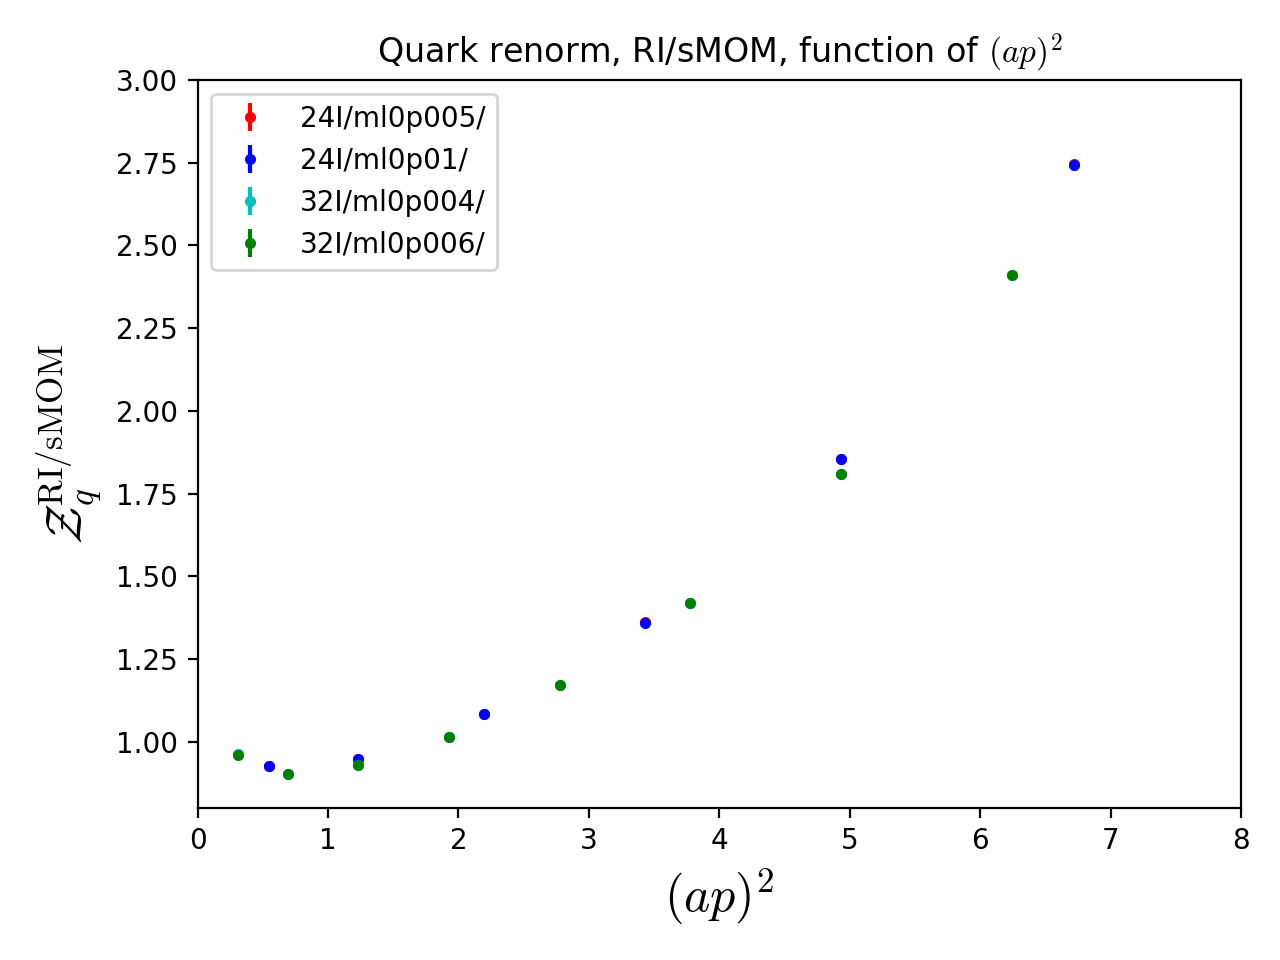

In [8]:
# Zq((ap)^2)
Zq_mu_list = [np.mean(Zq, axis = 1) for Zq in Zq_list]
Zq_sigma_list = [np.std(Zq, axis = 1, ddof = 1) for Zq in Zq_list]
# plt.figure(figsize = (10, 5))
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Zq_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.ylim((0.8, 3))
plt.xlim((0, 8))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Quark renorm, RI/sMOM, function of $(ap)^2$')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Zq.pdf')

<IPython.core.display.Javascript object>


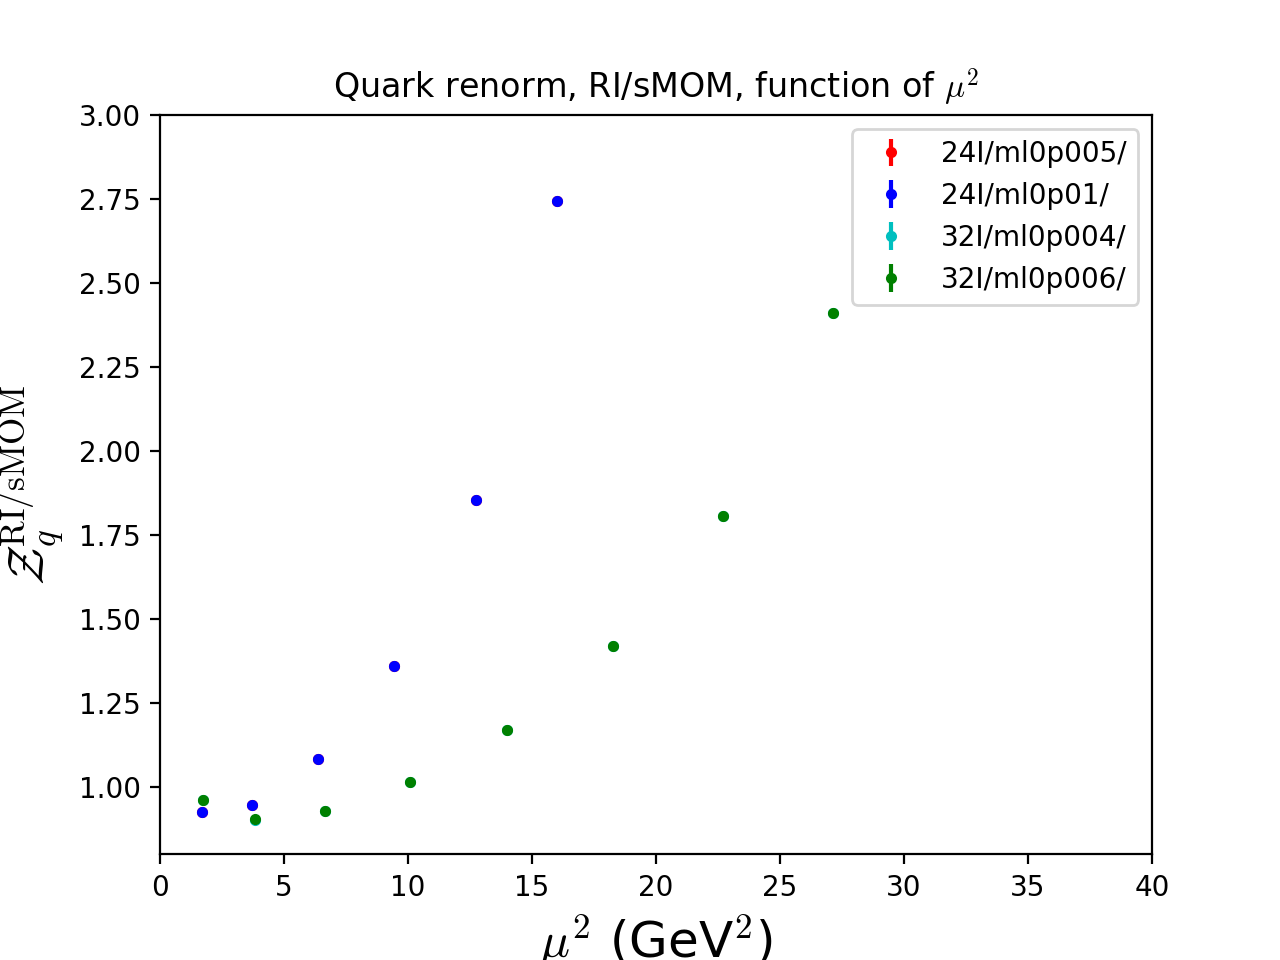

In [10]:
# Zq (μ^2)
plt.figure()
for idx in range(n_ens):
    plt.errorbar([mu ** 2 for mu in mu_list[idx]], Zq_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.ylim((0.8, 3))
plt.xlim((0, 40))
plt.xlabel('$\mu^2$ (GeV$^2$)', fontsize = 18)
plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Quark renorm, RI/sMOM, function of $\mu^2$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


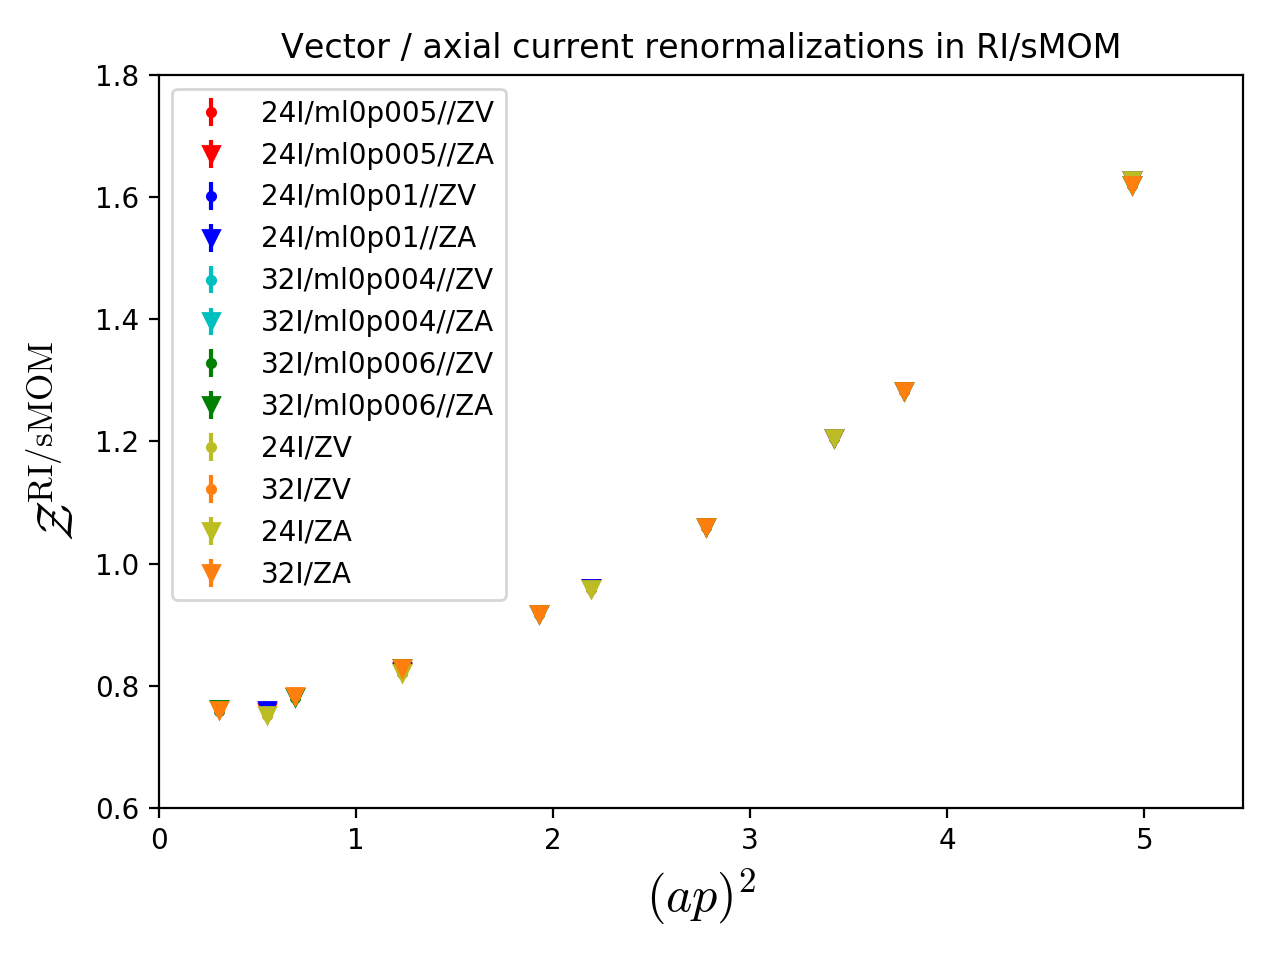

In [11]:
# ZV and ZA
ZV_mu_list = [np.mean(ZV, axis = 1) for ZV in ZV_list]
ZV_sigma_list = [np.std(ZV, axis = 1, ddof = 1) for ZV in ZV_list]
ZA_mu_list = [np.mean(ZA, axis = 1) for ZA in ZA_list]
ZA_sigma_list = [np.std(ZA, axis = 1, ddof = 1) for ZA in ZA_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], ZV_mu_list[idx], ZV_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + '/ZV')
    plt.errorbar([square(k) for k in mom_list[idx]], ZA_mu_list[idx], ZA_sigma_list[idx], fmt = 'v', c = colors[idx], label = ensembles[idx] + '/ZA')

plt.errorbar([square(k) - stagger for k in mom_list_24I], ZV_extrap_mu[0], ZV_extrap_sigma[0], fmt = '.', c = 'tab:olive', label = '24I/ZV')
plt.errorbar([square(k) - stagger for k in mom_list_32I], ZV_extrap_mu[1], ZV_extrap_sigma[1], fmt = '.', c = 'tab:orange', label = '32I/ZV')

plt.errorbar([square(k) - stagger for k in mom_list_24I], ZA_extrap_mu[0], ZA_extrap_sigma[0], fmt = 'v', c = 'tab:olive', label = '24I/ZA')
plt.errorbar([square(k) - stagger for k in mom_list_32I], ZA_extrap_mu[1], ZA_extrap_sigma[1], fmt = 'v', c = 'tab:orange', label = '32I/ZA')
plt.ylim((0.6, 1.8))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Vector / axial current renormalizations in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/ZVA.pdf')

<IPython.core.display.Javascript object>


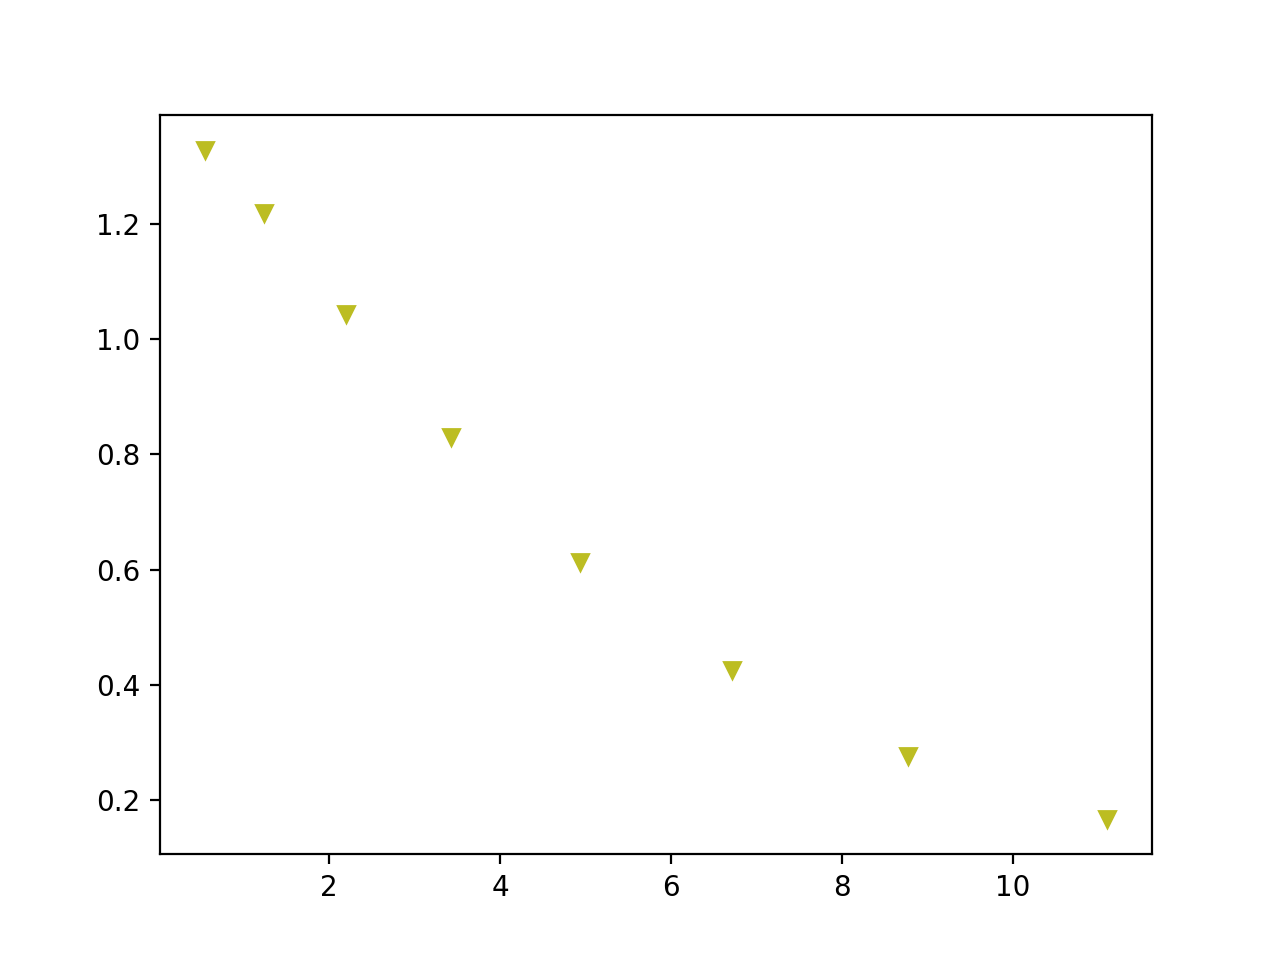

In [13]:
plt.figure()
plt.errorbar([square(k) for k in mom_list_24I], 1 / ZA_extrap_mu[0], ZA_extrap_sigma[0], fmt = 'v', c = 'tab:olive', label = '24I/ZA')
plt.show()

<IPython.core.display.Javascript object>


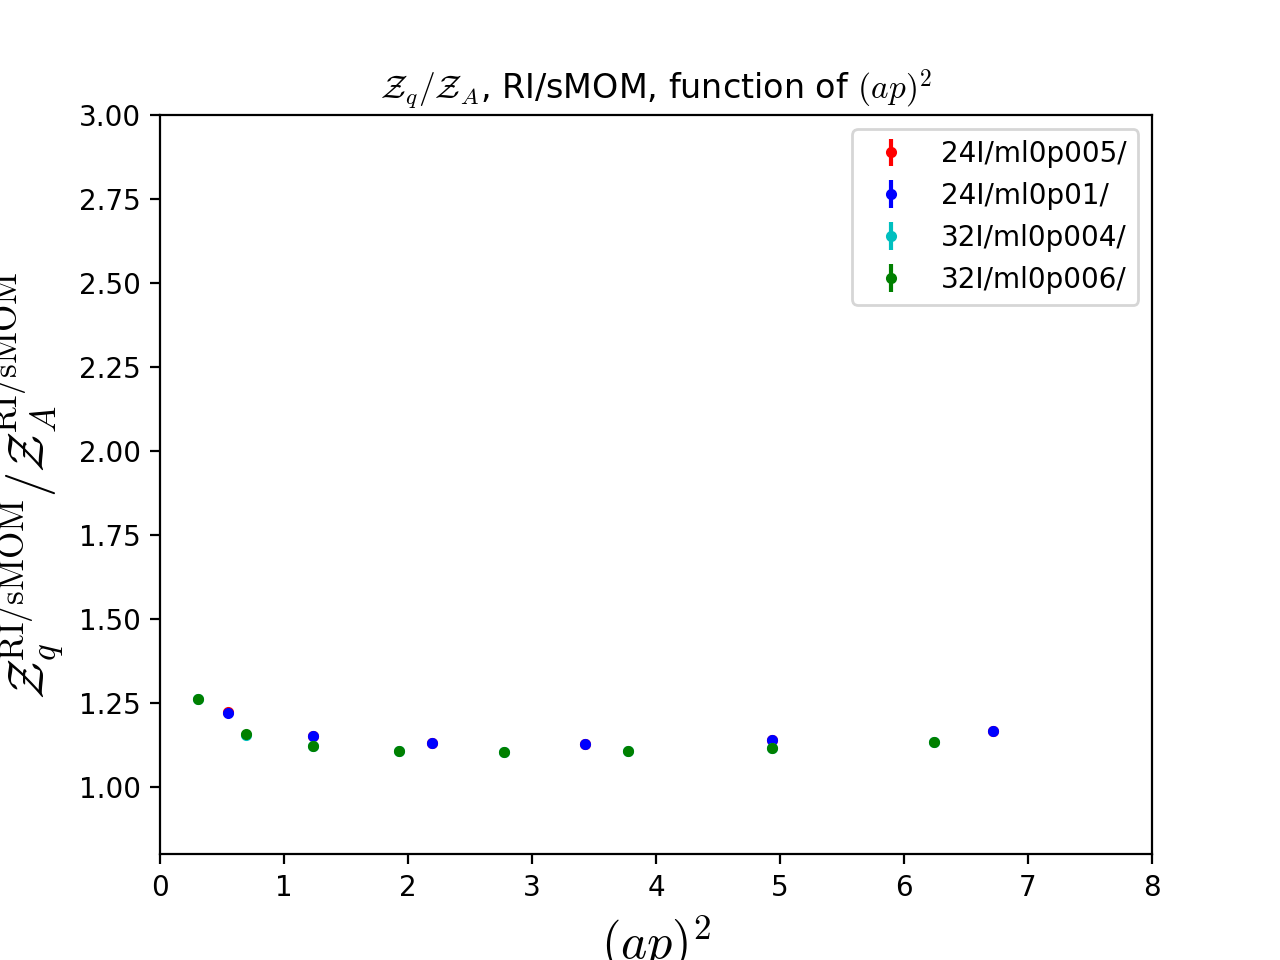

In [14]:
# Zq / ZA
Zq_mu_list = [np.mean(Zq, axis = 1) for Zq in Zq_list]
Zq_sigma_list = [np.std(Zq, axis = 1, ddof = 1) for Zq in Zq_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Zq_mu_list[idx] / ZA_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.ylim((0.8, 3))
plt.xlim((0, 8))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM} / \mathcal{Z}_A^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$\mathcal{Z}_q / \mathcal{Z}_A$, RI/sMOM, function of $(ap)^2$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


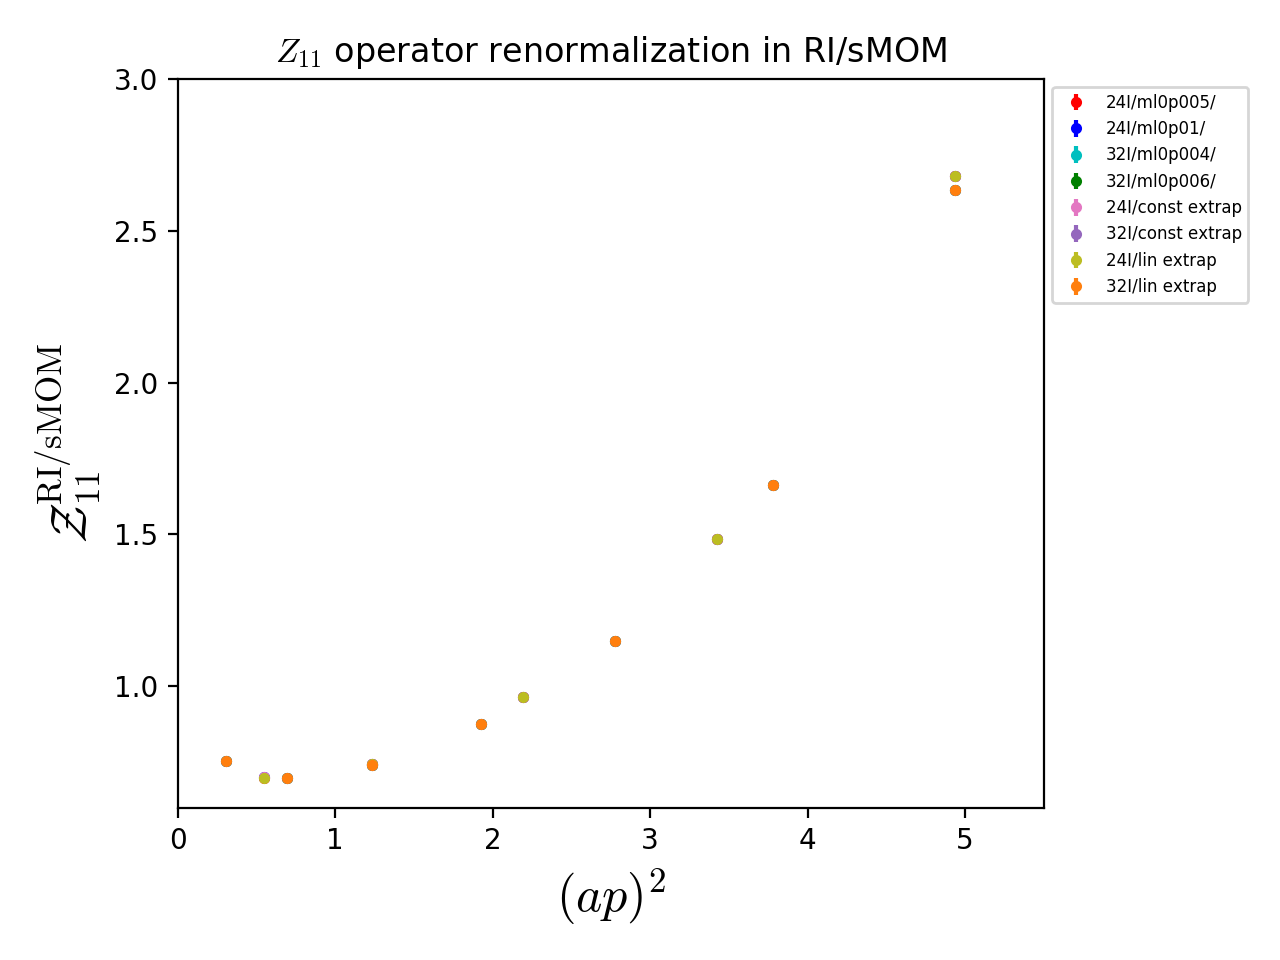

In [15]:
# Z11
Z11_mu_list = [np.mean(Z[0, 0], axis = 1) for Z in Z_list]
Z11_sigma_list = [np.std(Z[0, 0], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z11_mu_list[idx], Z11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 0, 0], Z_extrap_sigma[0, 0, 0], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 0, 0], Z_extrap_sigma[1, 0, 0], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 0, 0], Z_extrap_lin_sigma[0, 0, 0], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 0, 0], Z_extrap_lin_sigma[1, 0, 0], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.6, 3))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}_{11}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{11}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [16]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z11.pdf')

<IPython.core.display.Javascript object>


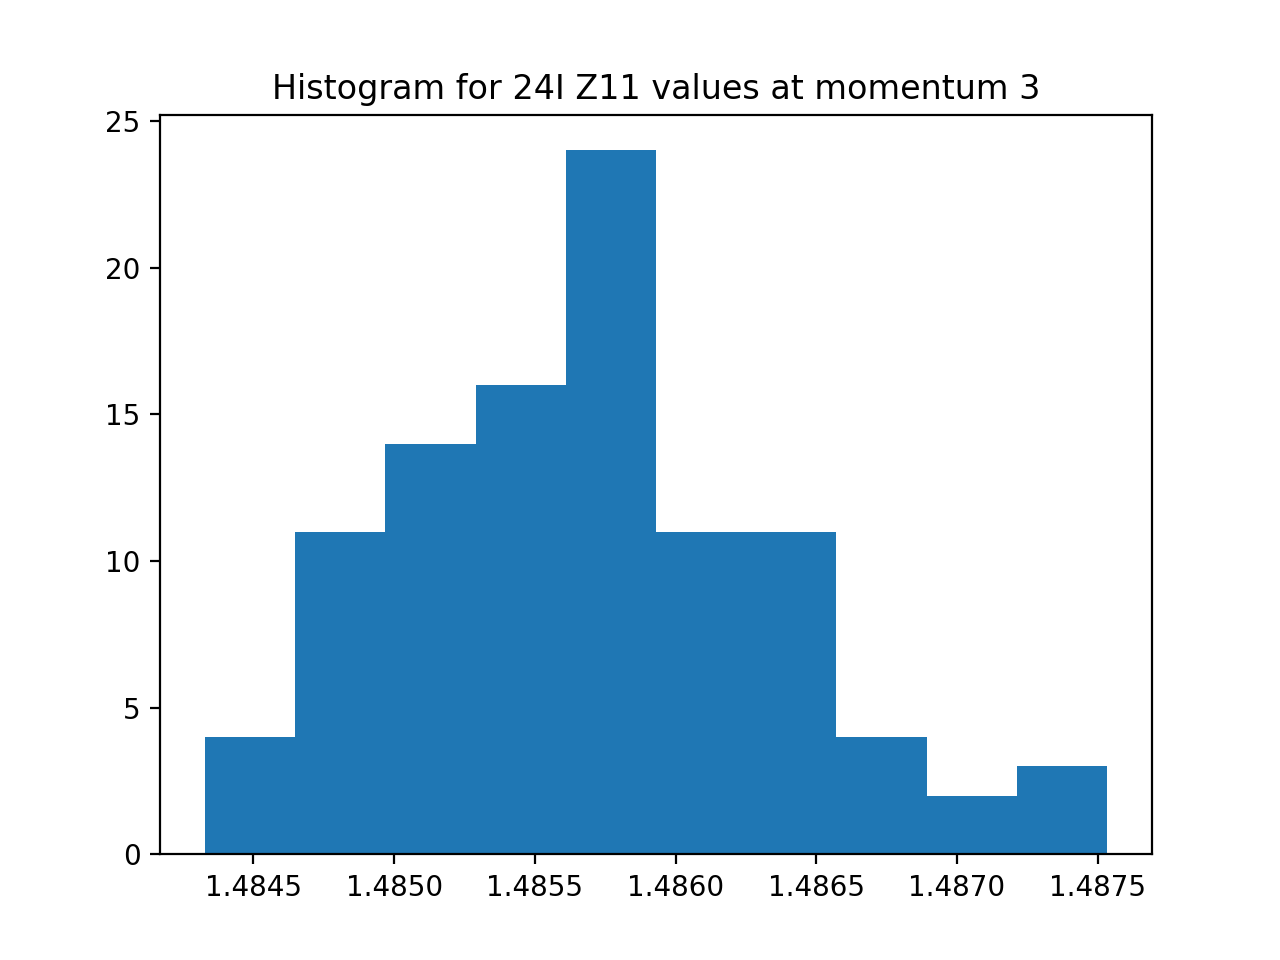

In [17]:
# are the points Gaussian distributed?
q_idx = 3
hist_data = np.reshape(Z_extrap[0, 0, 0, q_idx], (100,))
plt.figure()
plt.hist(hist_data)
plt.title('Histogram for 24I Z11 values at momentum ' + str(q_idx))
plt.show()

<IPython.core.display.Javascript object>


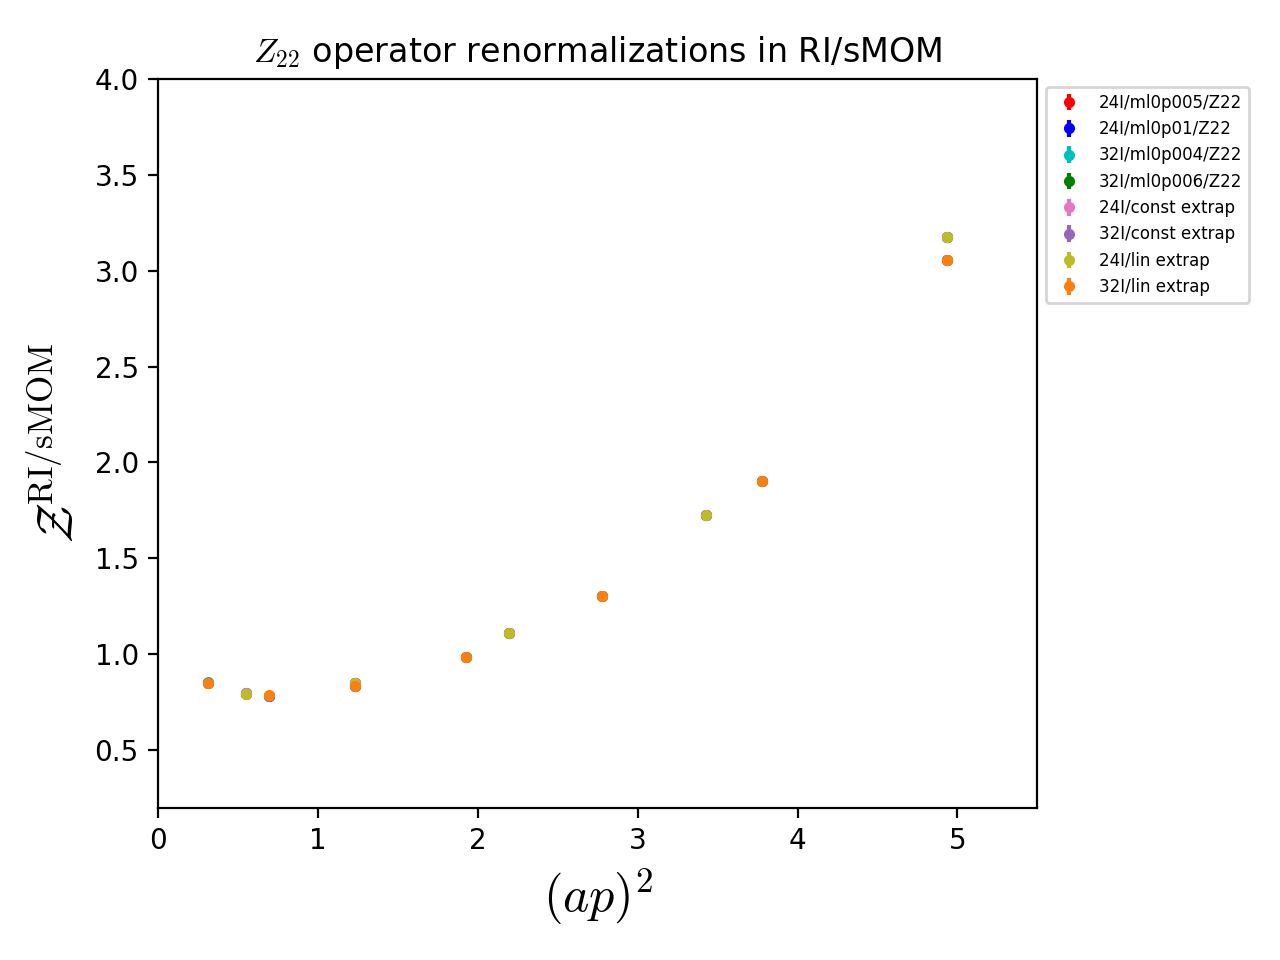

In [18]:
# Z22
Z22_mu_list = [np.mean(Z[1, 1], axis = 1) for Z in Z_list]
Z22_sigma_list = [np.std(Z[1, 1], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z22_mu_list[idx], Z22_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z22')
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 1], Z_extrap_sigma[0, 1, 1], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 1], Z_extrap_sigma[1, 1, 1], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 1], Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 1, 1], Z_extrap_lin_sigma[1, 1, 1], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.2, 4))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{22}$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [19]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z22.pdf')

<IPython.core.display.Javascript object>


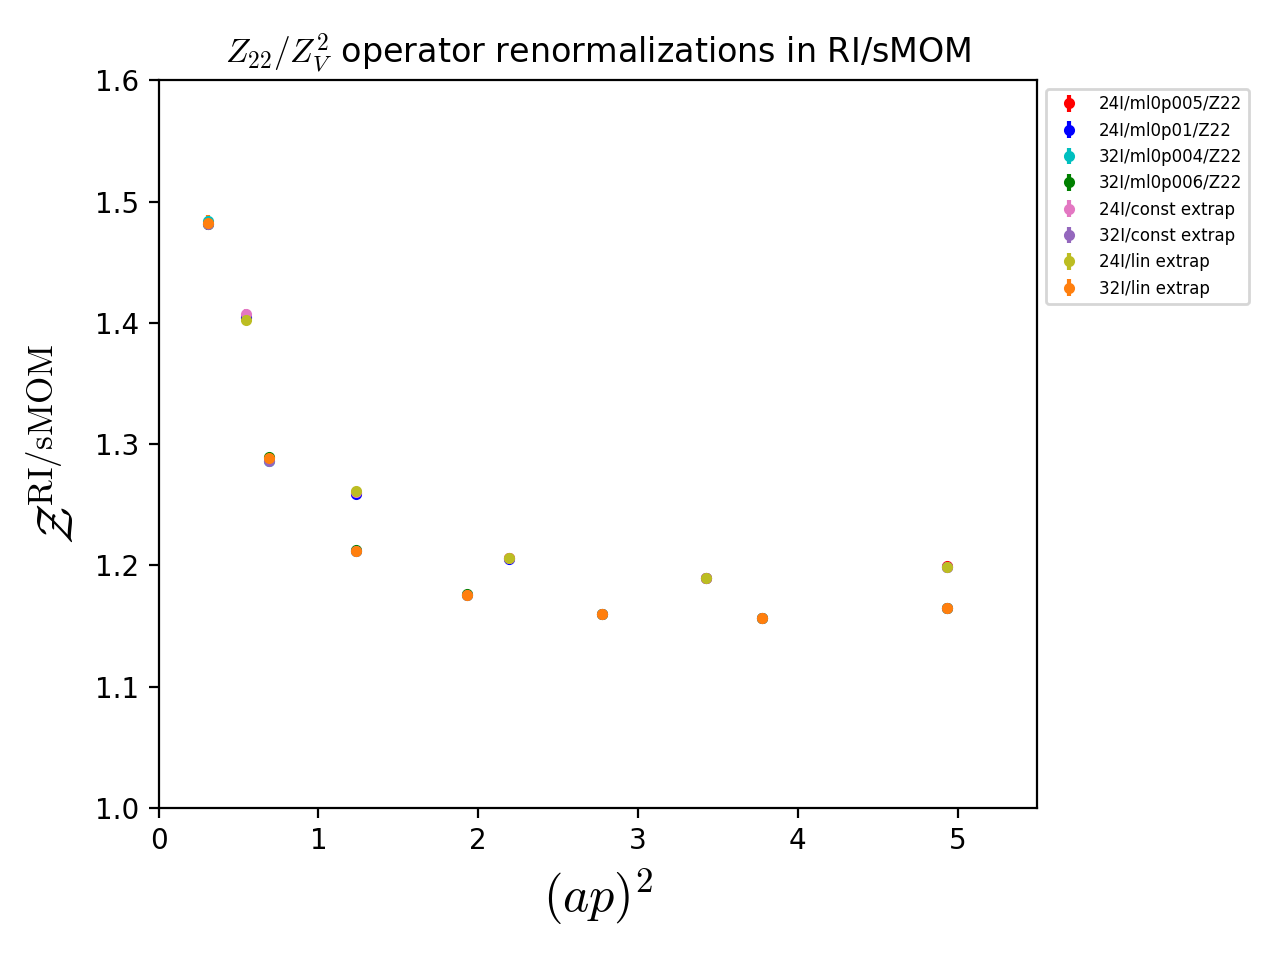

In [20]:
# Z22 / ZV^2 (very roughly, no error propagation yet. Just wanted to see general shape)
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z22_mu_list[idx] / (ZV_mu_list[idx] ** 2), Z22_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z22')
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_sigma[0, 1, 1], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 1] / (ZV_mu_list[2] ** 2), Z_extrap_sigma[1, 1, 1], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 1, 1] / (ZV_mu_list[2] ** 2), Z_extrap_lin_sigma[1, 1, 1], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((1, 1.6))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{22} / Z_V^2$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


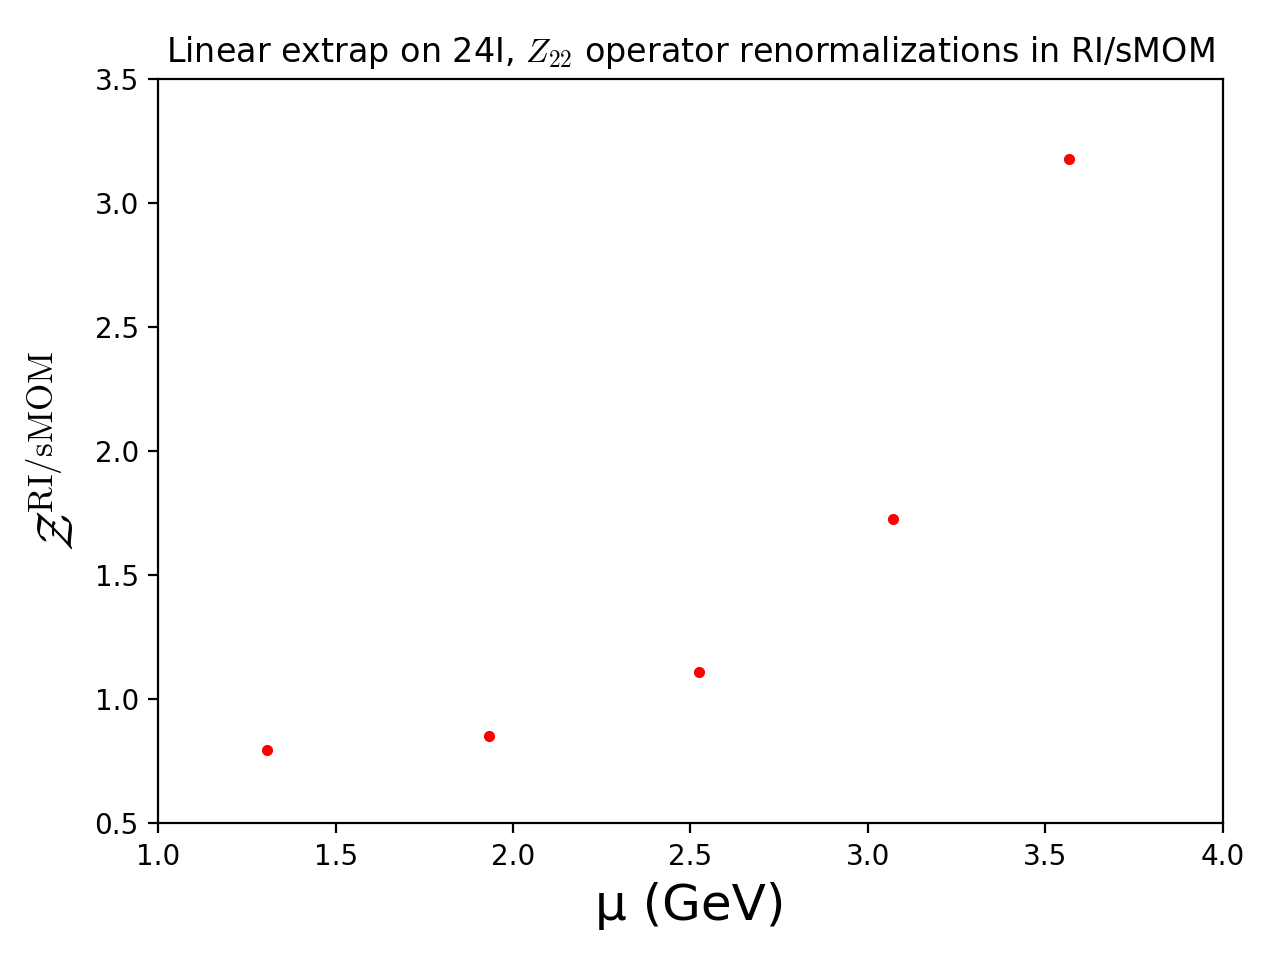

In [21]:
# Z22 / ZV^2 (very roughly, no error propagation yet. Just wanted to see general shape)
plt.figure()
# plot linear extrap too
# plt.errorbar([square(k) for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar(mu_list[0], Z_extrap_lin_mu[0, 1, 1], Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'r')

plt.ylim((0.5, 3.5))
plt.xlim((1, 4))
plt.xlabel('μ (GeV)', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Linear extrap on 24I, $Z_{22}$ operator renormalizations in RI/sMOM')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


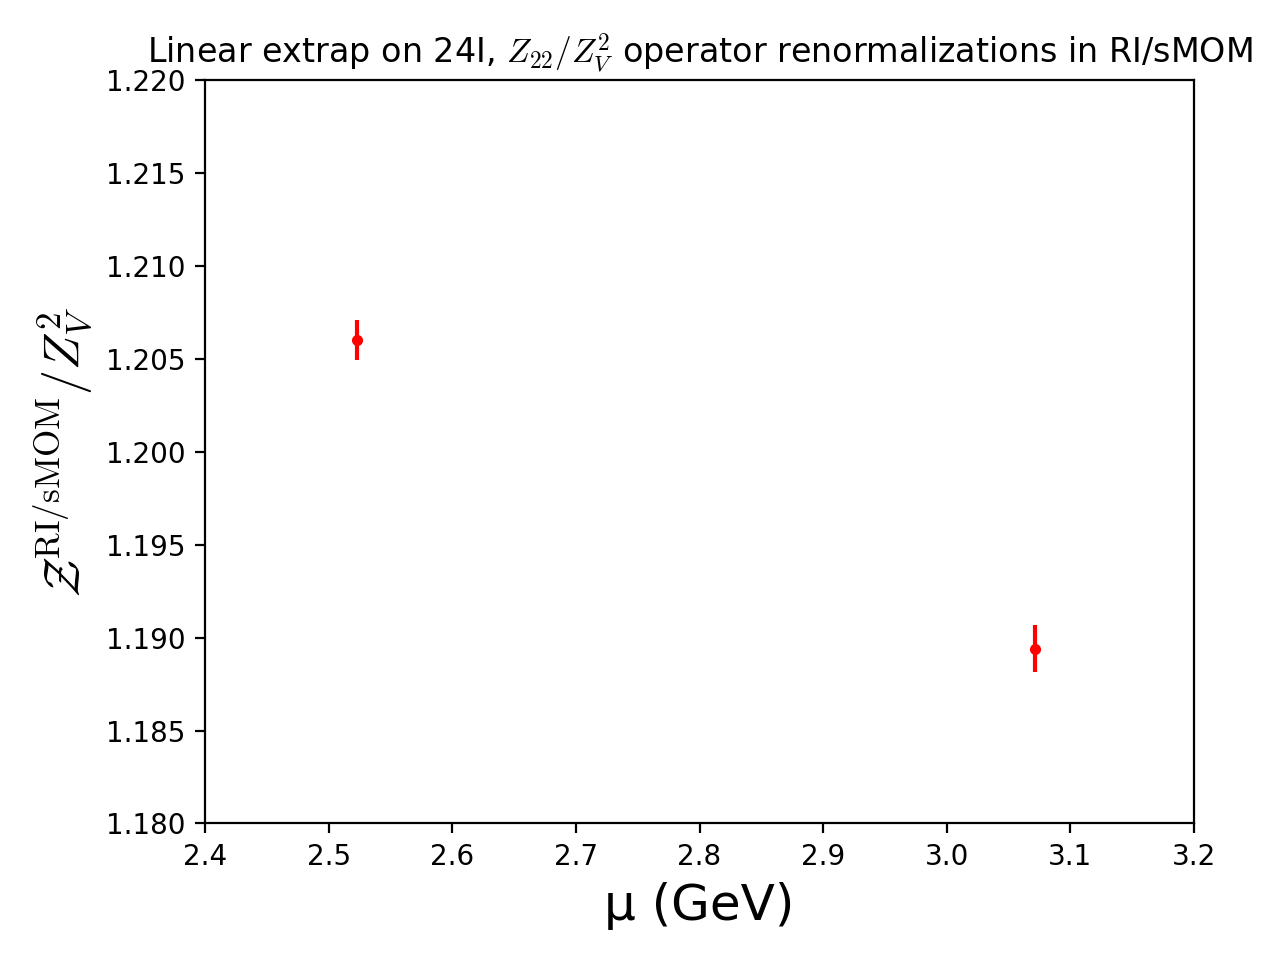

In [22]:
# Z22 / ZV^2 (very roughly, no error propagation yet. Just wanted to see general shape)
plt.figure()
plt.errorbar(mu_list[0], Z_extrap_lin_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'r')

# plt.ylim((1.15, 1.3))
# plt.xlim((1, 4.1))
plt.ylim((1.18, 1.22))
plt.xlim((2.4, 3.2))
plt.xlabel('μ (GeV)', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM} / Z_V^2$', fontsize = 18)
plt.title('Linear extrap on 24I, $Z_{22} / Z_V^2$ operator renormalizations in RI/sMOM')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


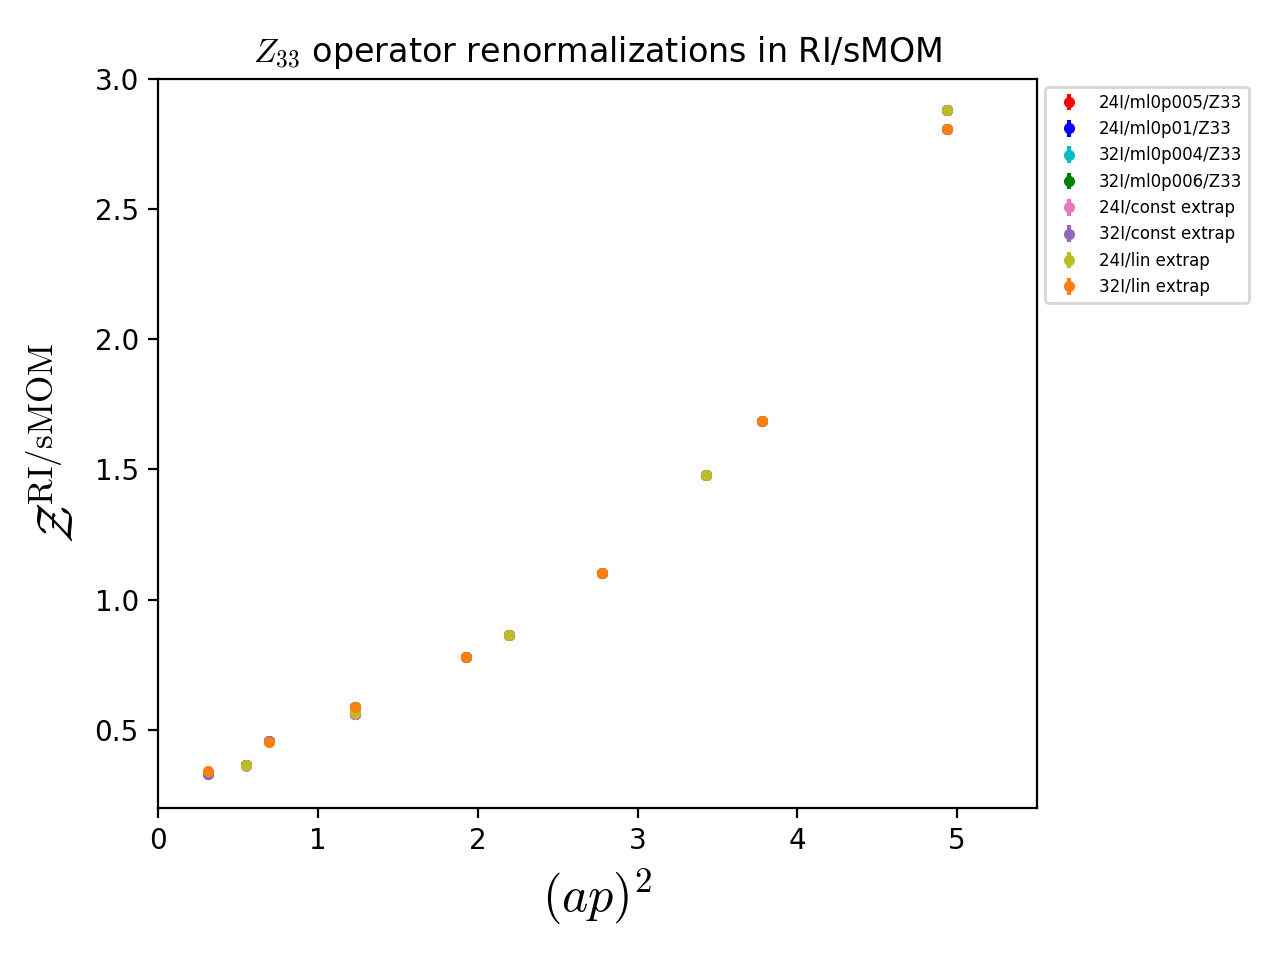

In [23]:
# Z33 
Z33_mu_list = [np.mean(Z[2, 2], axis = 1) for Z in Z_list]
Z33_sigma_list = [np.std(Z[2, 2], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z33_mu_list[idx], Z33_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z33')
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 2, 2], Z_extrap_sigma[0, 2, 2], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 2, 2], Z_extrap_sigma[1, 2, 2], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 2, 2], Z_extrap_lin_sigma[0, 2, 2], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 2, 2], Z_extrap_lin_sigma[1, 2, 2], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.2, 3))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{33}$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [24]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z33.pdf')

<IPython.core.display.Javascript object>


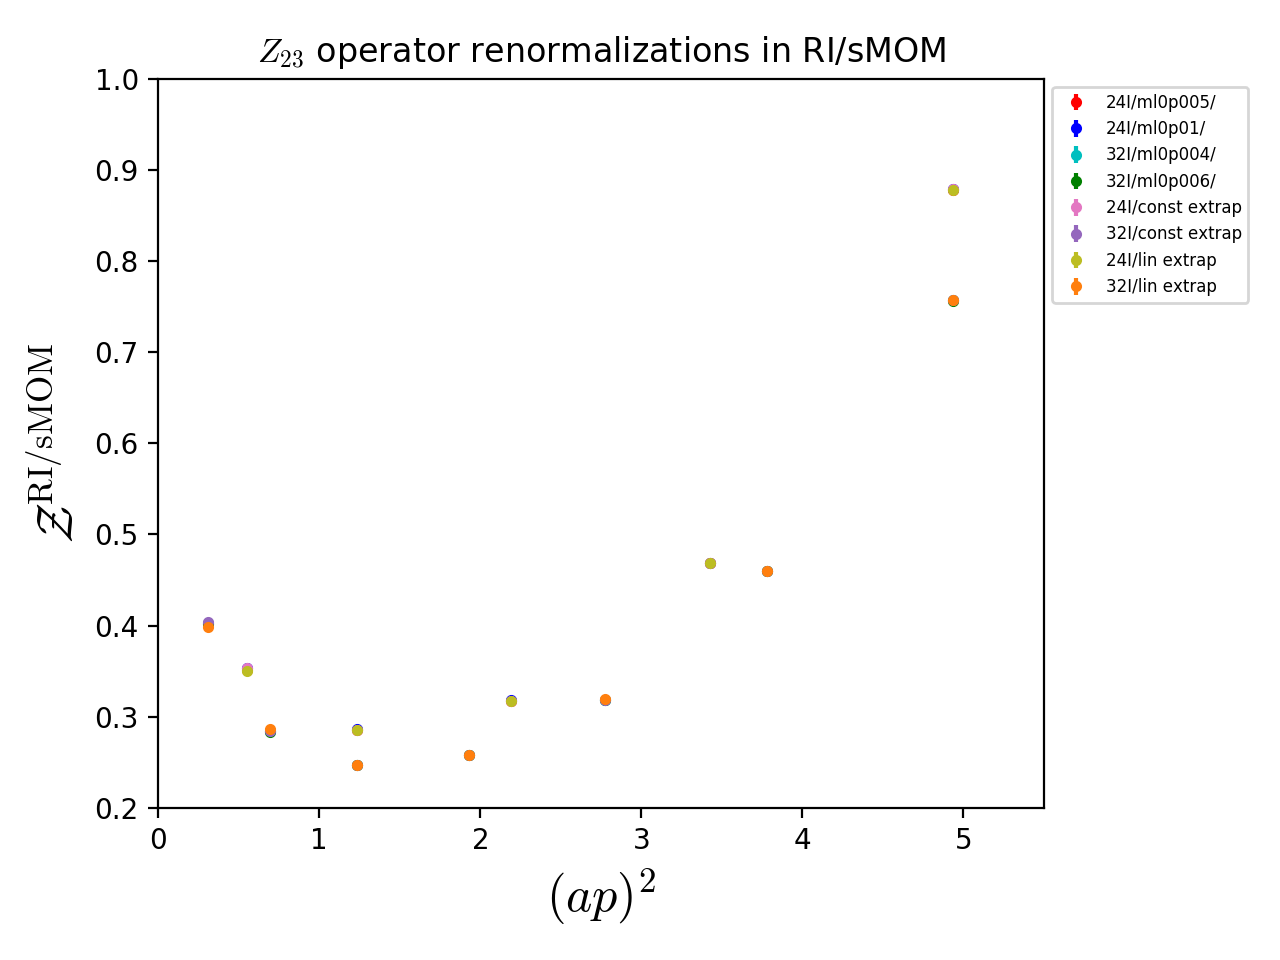

In [25]:
# Z23
Z23_mu_list = [np.mean(Z[1, 2], axis = 1) for Z in Z_list]
Z23_sigma_list = [np.std(Z[1, 2], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z23_mu_list[idx], Z23_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 2], Z_extrap_sigma[0, 1, 2], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 2], Z_extrap_sigma[1, 1, 2], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 2], Z_extrap_lin_sigma[0, 1, 2], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 1, 2], Z_extrap_lin_sigma[1, 1, 2], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.2, 1))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{23}$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [26]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z23.pdf')

<IPython.core.display.Javascript object>


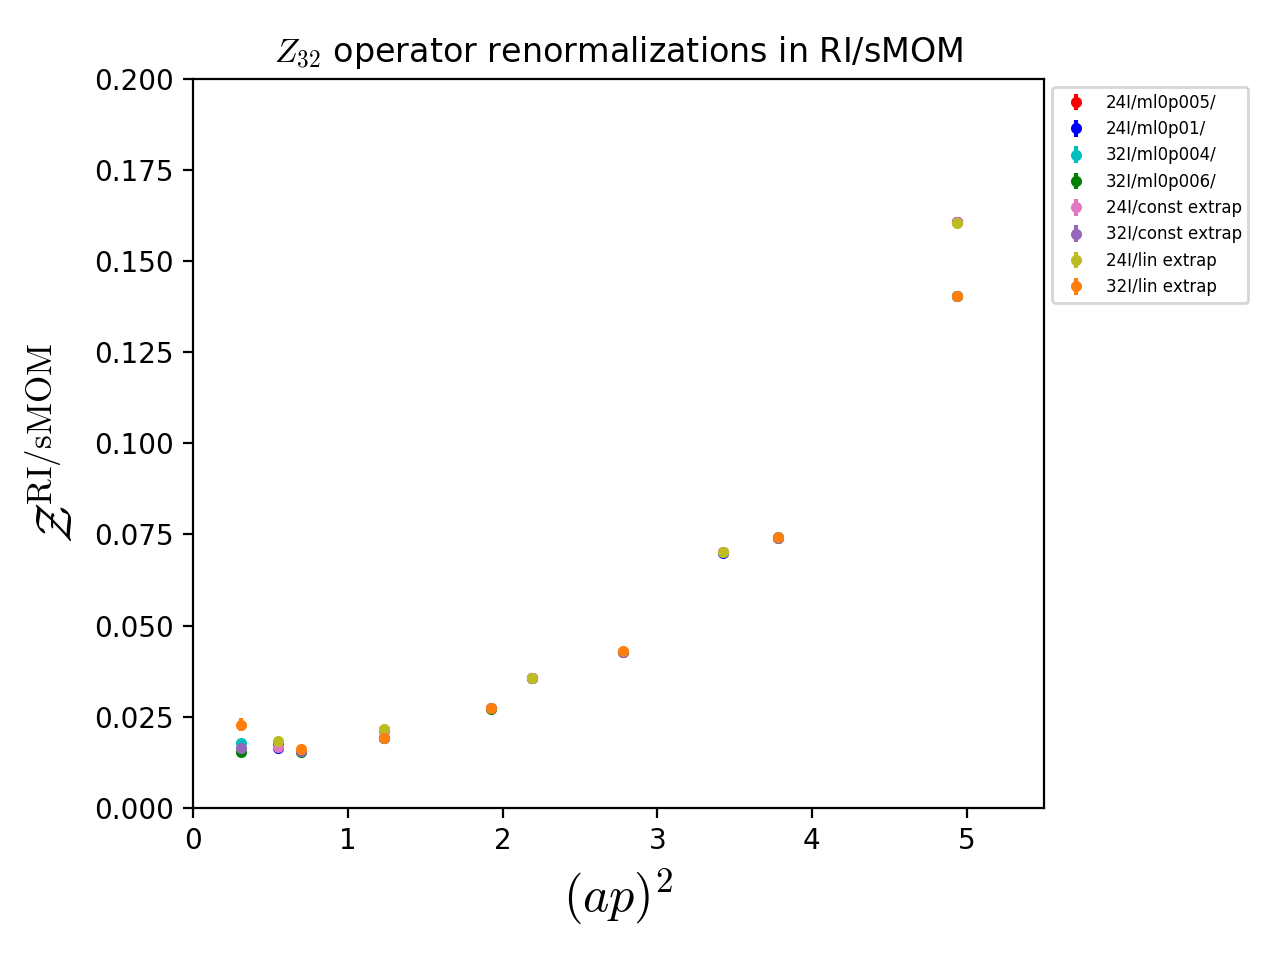

In [27]:
# Z32
Z32_mu_list = [np.mean(Z[2, 1], axis = 1) for Z in Z_list]
Z32_sigma_list = [np.std(Z[2, 1], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z32_mu_list[idx], Z32_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 2, 1], Z_extrap_sigma[0, 2, 1], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 2, 1], Z_extrap_sigma[1, 2, 1], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 2, 1], Z_extrap_lin_sigma[0, 2, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 2, 1], Z_extrap_lin_sigma[1, 2, 1], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0, 0.2))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{32}$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [28]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z32.pdf')

<IPython.core.display.Javascript object>


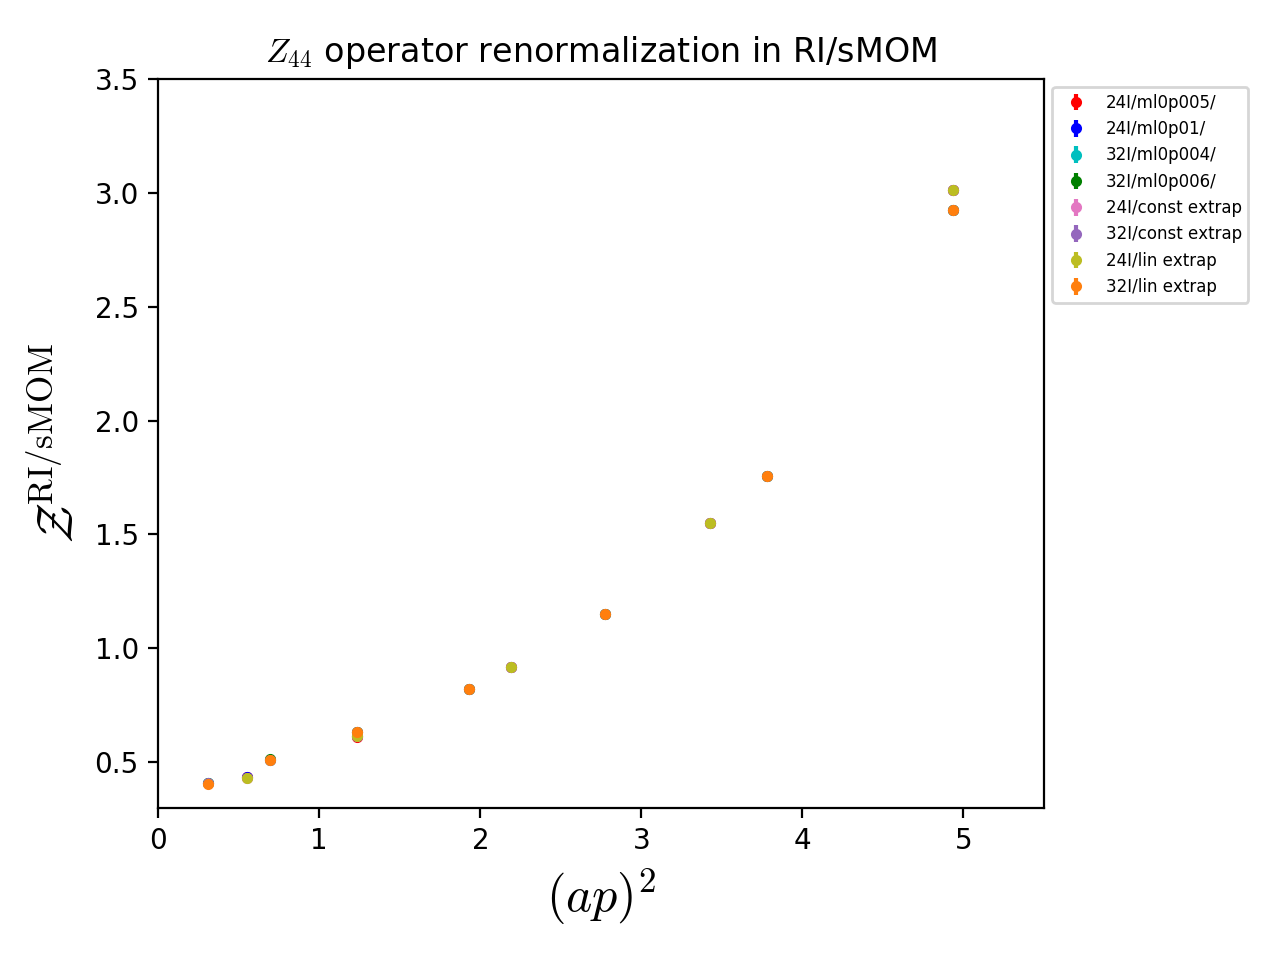

In [29]:
# Z44
Z44_mu_list = [np.mean(Z[3, 3], axis = 1) for Z in Z_list]
Z44_sigma_list = [np.std(Z[3, 3], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z44_mu_list[idx], Z44_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 3, 3], Z_extrap_sigma[0, 3, 3], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 3, 3], Z_extrap_sigma[1, 3, 3], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 3, 3], Z_extrap_lin_sigma[0, 3, 3], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 3, 3], Z_extrap_lin_sigma[1, 3, 3], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.3, 3.5))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{44}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [30]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z44.pdf')

<IPython.core.display.Javascript object>


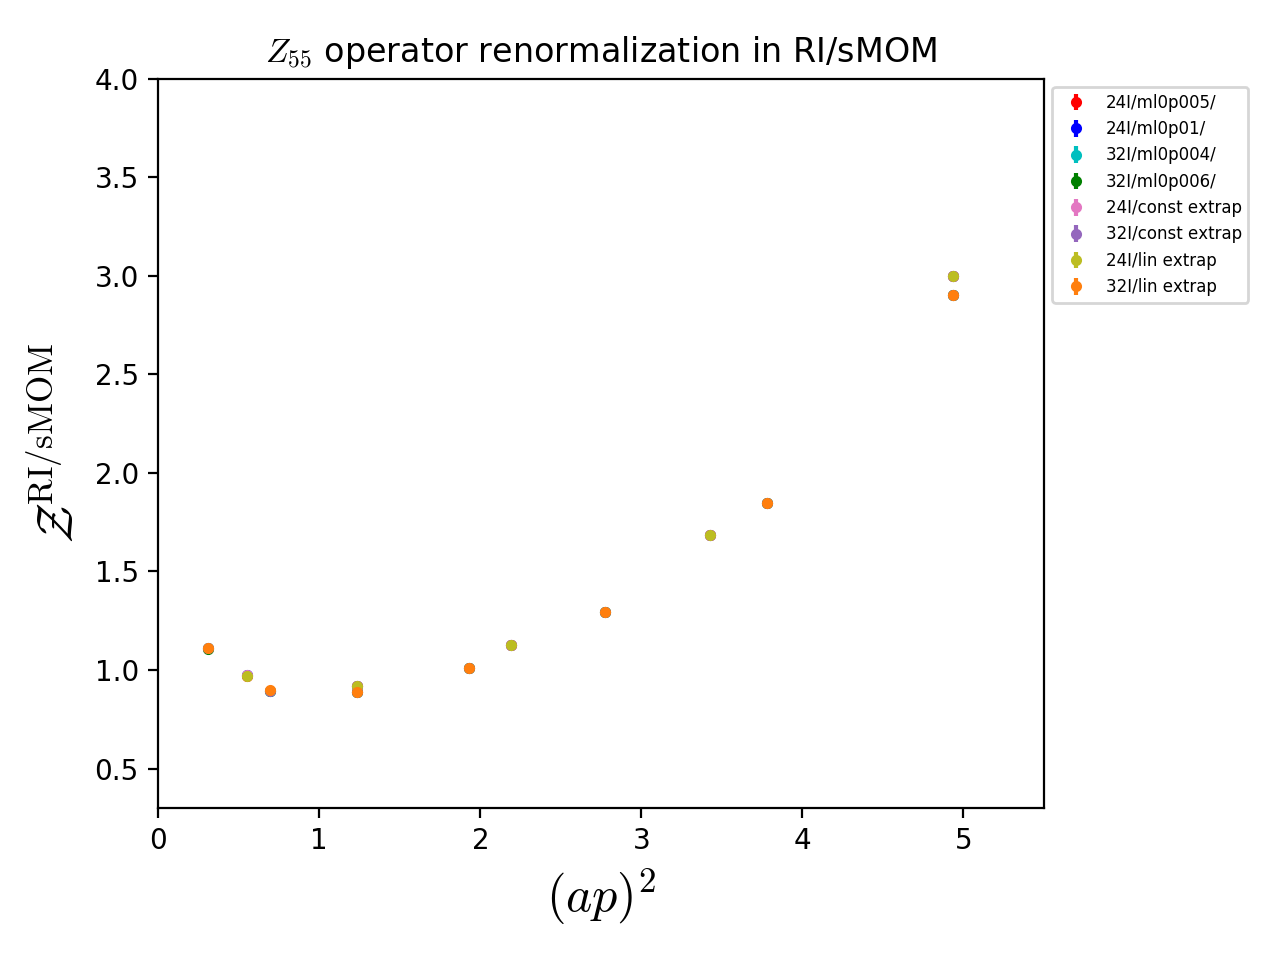

In [31]:
# Z55
Z55_mu_list = [np.mean(Z[4, 4], axis = 1) for Z in Z_list]
Z55_sigma_list = [np.std(Z[4, 4], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z55_mu_list[idx], Z55_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 4, 4], Z_extrap_sigma[0, 4, 4], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 4, 4], Z_extrap_sigma[1, 4, 4], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 4, 4], Z_extrap_lin_sigma[0, 4, 4], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 4, 4], Z_extrap_lin_sigma[1, 4, 4], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.3, 4.0))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{55}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [32]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z55.pdf')

<IPython.core.display.Javascript object>


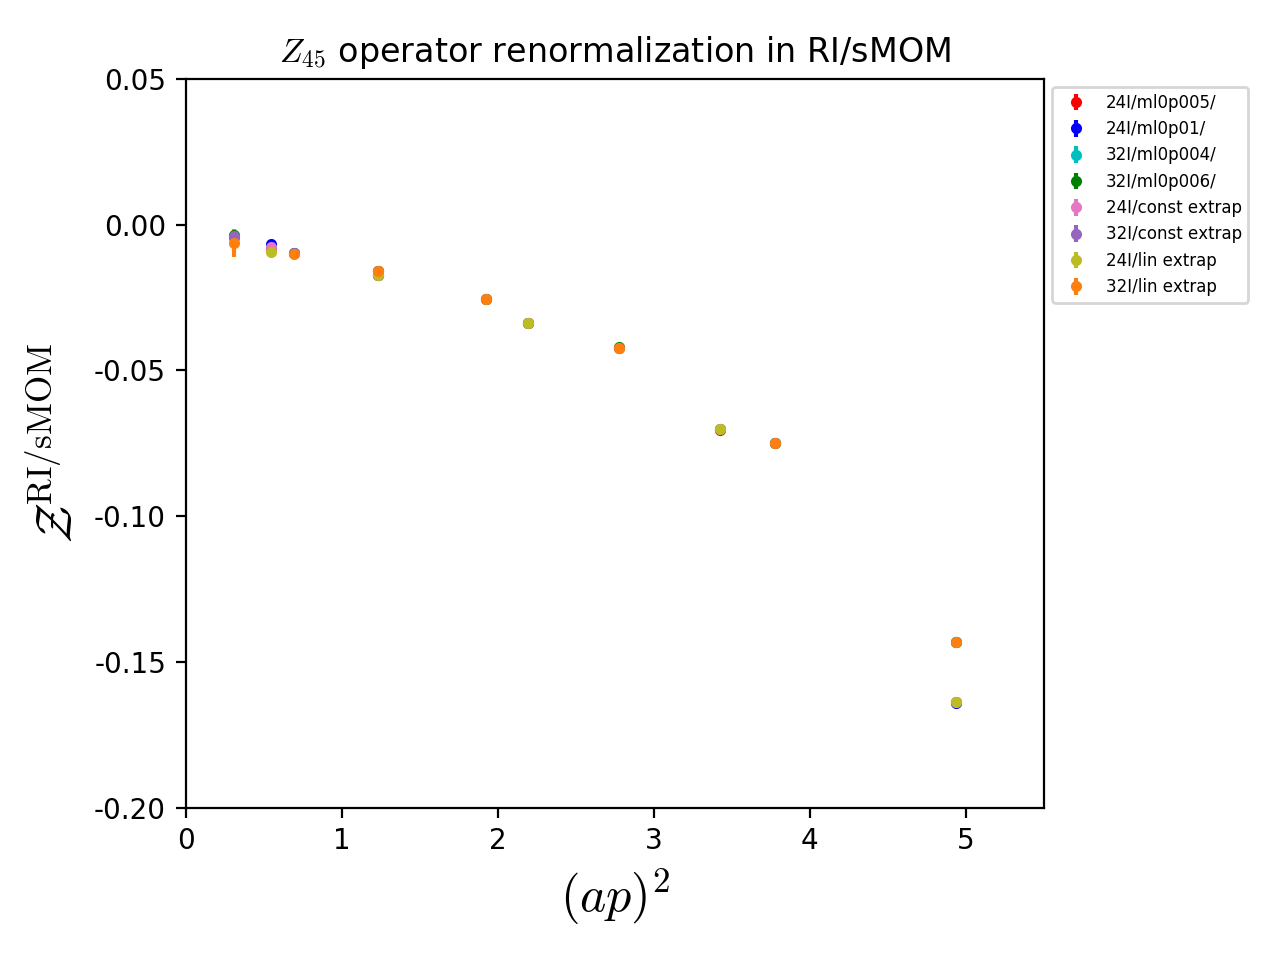

In [33]:
# Z45
Z45_mu_list = [np.mean(Z[3, 4], axis = 1) for Z in Z_list]
Z45_sigma_list = [np.std(Z[3, 4], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z45_mu_list[idx], Z45_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 3, 4], Z_extrap_sigma[0, 3, 4], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 3, 4], Z_extrap_sigma[1, 3, 4], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 3, 4], Z_extrap_lin_sigma[0, 3, 4], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 3, 4], Z_extrap_lin_sigma[1, 3, 4], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((-0.2, 0.05))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{45}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [34]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z45.pdf')

<IPython.core.display.Javascript object>


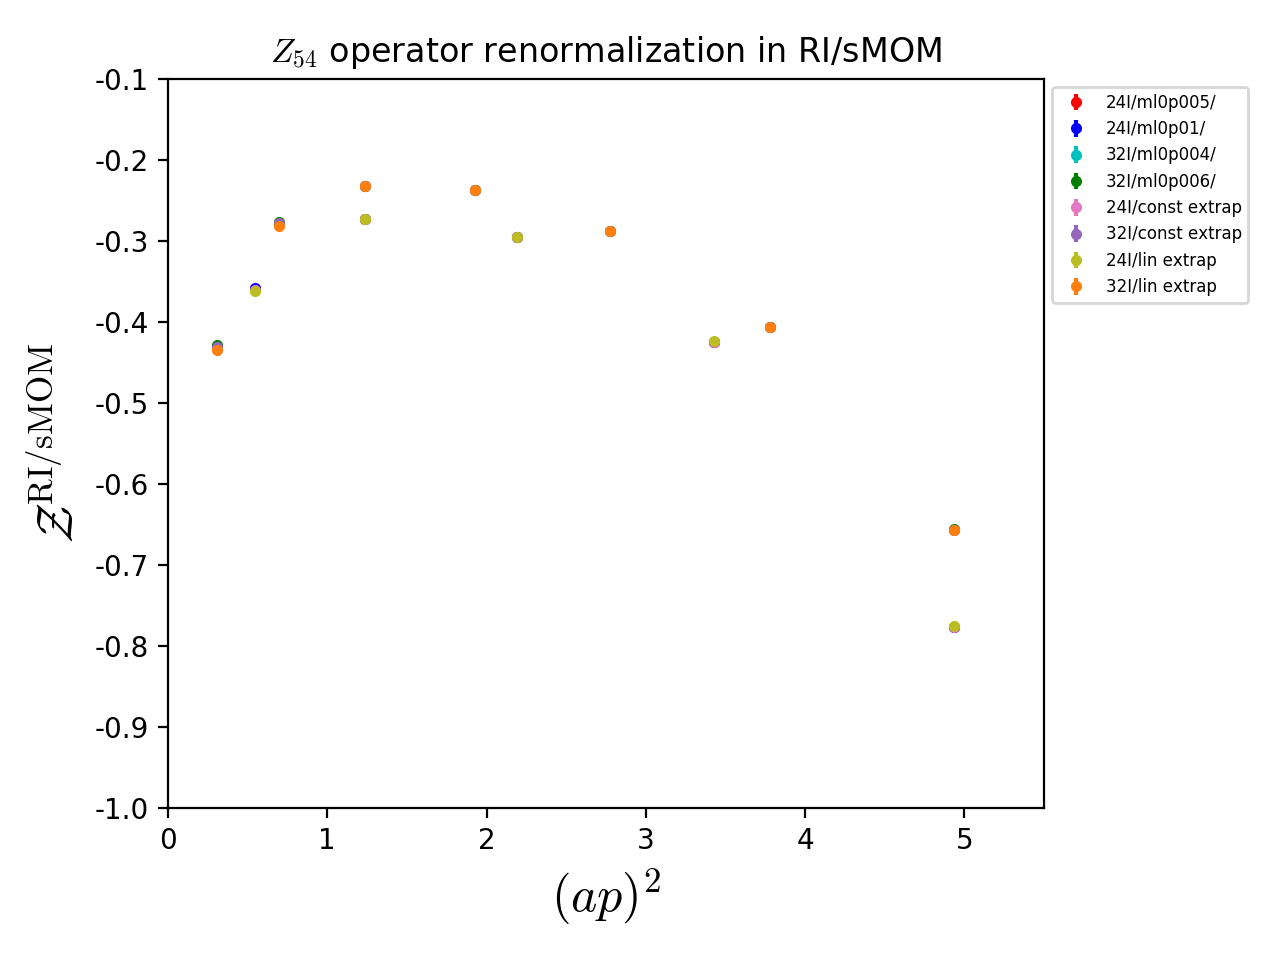

In [35]:
# Z54
Z54_mu_list = [np.mean(Z[4, 3], axis = 1) for Z in Z_list]
Z54_sigma_list = [np.std(Z[4, 3], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z54_mu_list[idx], Z54_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 4, 3], Z_extrap_sigma[0, 4, 3], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 4, 3], Z_extrap_sigma[1, 4, 3], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 4, 3], Z_extrap_lin_sigma[0, 4, 3], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 4, 3], Z_extrap_lin_sigma[1, 4, 3], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((-1, -0.1))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{54}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [36]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z54.pdf')

## Fit each $Z_{ij} / Z_V^2$ as a function of $(ap)^2$, interpolate to $\mu_1 = 3$ GeV

In [37]:
# spacing_idx = 0    # 0 for 24I, 1 for 32I
spacing_idx = 1
Z_chiral_boots = np.zeros(Z_extrap_lin[spacing_idx].shape, dtype = np.float64)     # Z_ij / ZV^2
for pidx in range(n_mom):
    for eidx in range(n_spacings):
        for bidx in range(n_boot[0]):
            Z_chiral_boots[:, :, pidx, eidx, bidx] = Z_extrap_lin[spacing_idx, :, :, pidx, eidx, bidx] / \
                (ZV_list[2 * spacing_idx + eidx][pidx, bidx] ** 2)
Z_chiral_mu = np.zeros((5, 5, n_mom), dtype = np.float64)
Z_chiral_sigma = np.zeros((5, 5, n_mom), dtype = np.float64)
for i, j in itertools.product(range(5), repeat = 2):
    for pidx in range(n_mom):
        tmp = Superboot(n_spacings)
        tmp.boots = Z_chiral_boots[i, j, pidx]
        Z_chiral_mu[i, j, pidx] = tmp.compute_mean()
        Z_chiral_sigma[i, j, pidx] = tmp.compute_std()
scales = mu_list[2 * spacing_idx]

In [38]:
# # choose lattice spacing and plot as a function of scale
# spacing_idx = 0        # 0 for 24I, 1 for 32I
# Z_chiral_boots = Z_extrap_lin[spacing_idx]
# Z_chiral_mu = Z_extrap_lin_mu[spacing_idx]
# Z_chiral_sigma = Z_extrap_lin_sigma[spacing_idx]
# scales = mu_list[2 * spacing_idx]

<IPython.core.display.Javascript object>


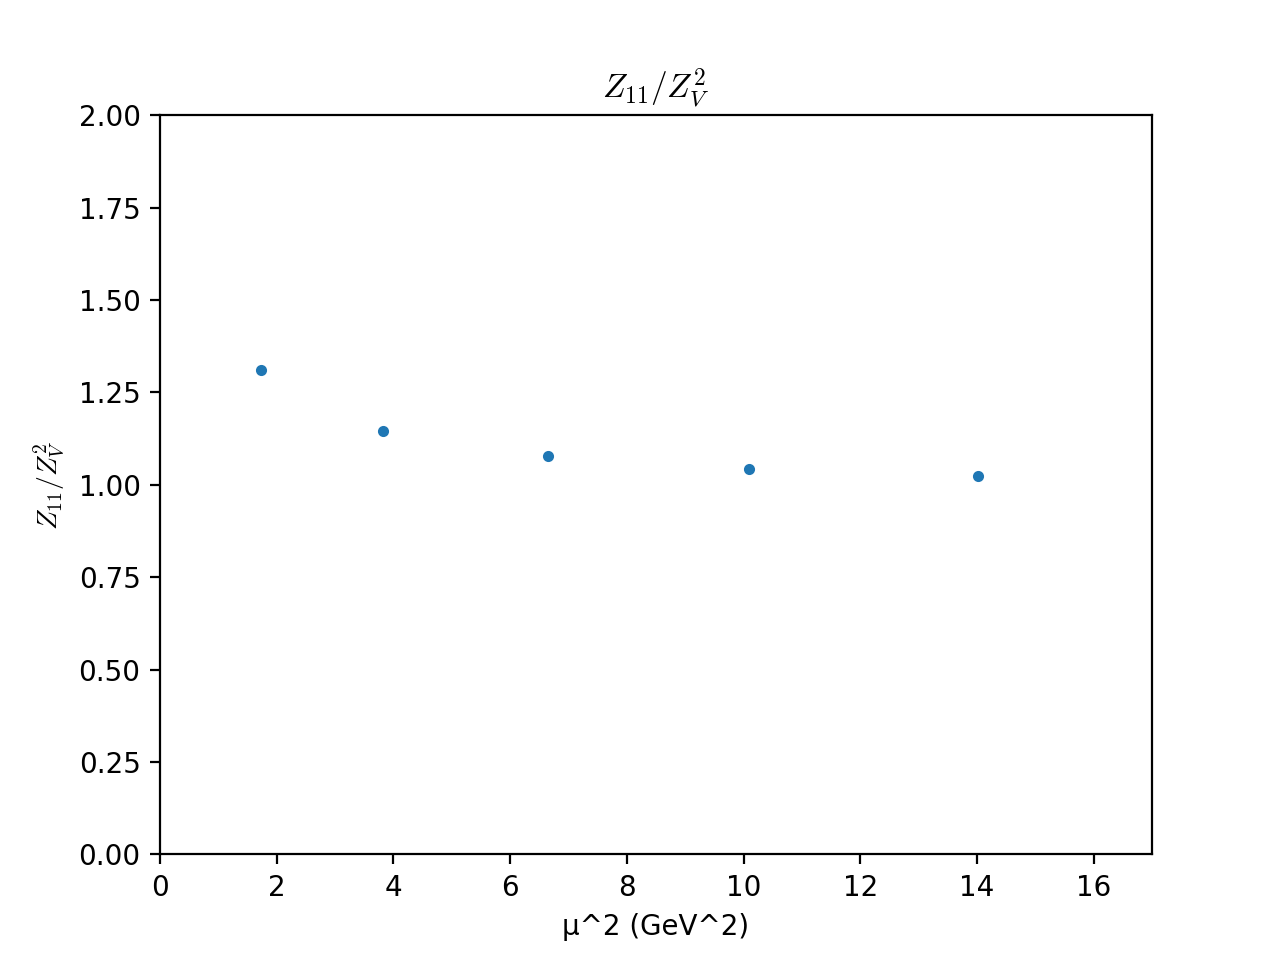

In [39]:
plt.figure()
plt.errorbar(scales ** 2, Z_chiral_mu[0, 0], Z_chiral_sigma[0, 0], marker = '.', fmt = '.')
plt.xlabel('μ^2 (GeV^2)')
plt.ylabel('$Z_{11} / Z_V^2$')
plt.xlim((0, 17))
plt.ylim((0, 2))
plt.title('$Z_{11} / Z_V^2$')
plt.show()

<IPython.core.display.Javascript object>


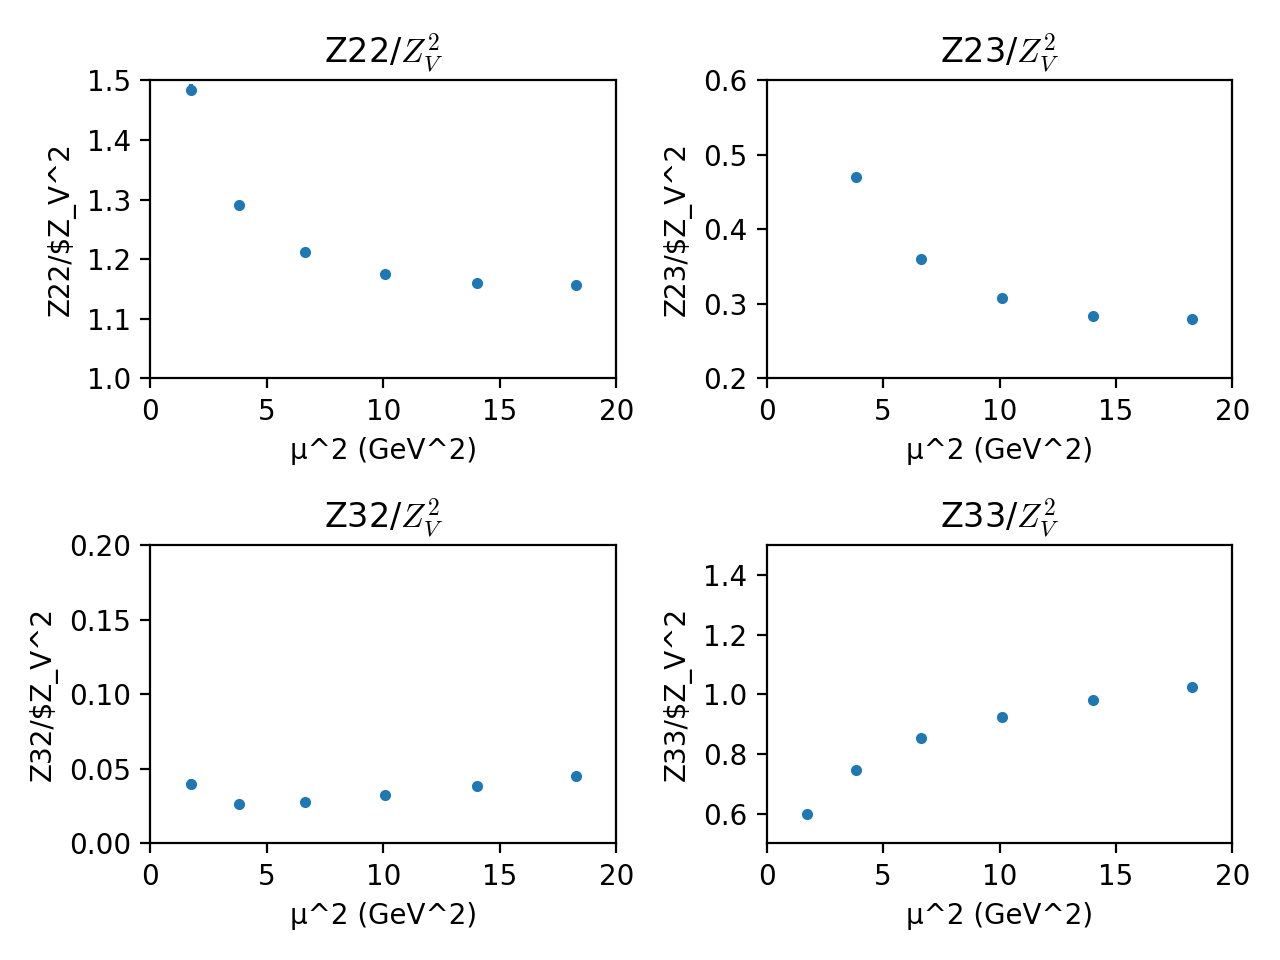

In [40]:
fig, ax = plt.subplots(2, 2)
for i, j in itertools.product(range(2), repeat = 2):
    ax[i, j].errorbar(scales ** 2, Z_chiral_mu[i + 1, j + 1], Z_chiral_sigma[i + 1, j + 1], marker = '.', fmt = '.')
    ax[i, j].set_xlim((0, 20))
    ax[i, j].set_title('Z' + str(i + 2) + str(j + 2) + '/$Z_V^2$')
    ax[i, j].set_xlabel('μ^2 (GeV^2)')
    ax[i, j].set_ylabel('Z' + str(i + 2) + str(j + 2) + '/$Z_V^2')
ax[0, 0].set_ylim((1, 1.5))
ax[0, 1].set_ylim((0.2, 0.6))
ax[1, 0].set_ylim((0, 0.2))
ax[1, 1].set_ylim((0.5, 1.5))
plt.tight_layout()
plt.show()

In [41]:
scales

array([1.31438464, 1.95573885, 2.57825822, 3.17594756, 3.74305078,
       4.27410638, 4.764     , 5.20801369])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


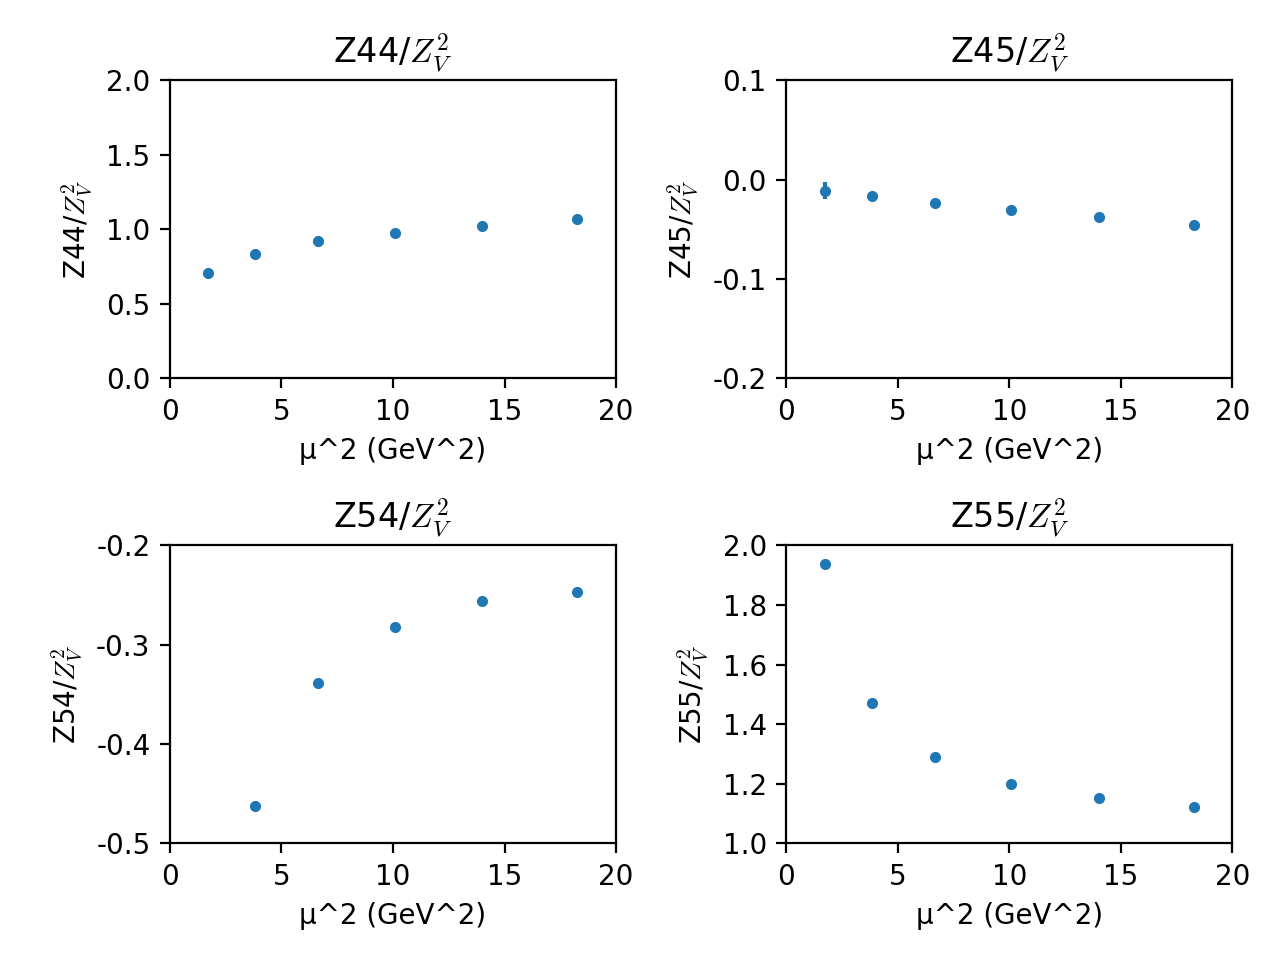

In [42]:
fig, ax = plt.subplots(2, 2)
for i, j in itertools.product(range(2), repeat = 2):
    ax[i, j].errorbar(scales ** 2, Z_chiral_mu[i + 3, j + 3], Z_chiral_sigma[i + 3, j + 3], marker = '.', fmt = '.')
    ax[i, j].set_xlim((0, 20))
    ax[i, j].set_title('Z' + str(i + 4) + str(j + 4) + '/$Z_V^2$')
    ax[i, j].set_xlabel('μ^2 (GeV^2)')
    ax[i, j].set_ylabel('Z' + str(i + 4) + str(j + 4) + '/$Z_V^2$')
ax[0, 0].set_ylim((0, 2))
ax[0, 1].set_ylim((-0.2, 0.1))
ax[1, 0].set_ylim((-0.5, -0.2))
ax[1, 1].set_ylim((1, 2))
plt.tight_layout()
plt.show()

In [43]:
scales

array([1.31438464, 1.95573885, 2.57825822, 3.17594756, 3.74305078,
       4.27410638, 4.764     , 5.20801369])

In [92]:
def fit_and_plot(data, mus, pwr, label, x_range = [2, 5], x_label = '$\\mu$ (GeV)'):
    fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(mus, data, order = pwr)
    # x_fit_b = np.linspace(2, 5)
    x_fit_b = np.linspace(x_range[0], x_range[1])
    fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
    for ii in range(pwr + 1):
        ci_mu_b = np.mean(fit_coeffs_b[ii])
        moment = x_fit_b ** (2 * ii)
        fx_fit_b += ci_mu_b * moment
    Z_fit_mean = np.zeros((len(mus)), dtype = np.float64)
    Z_fit_std = np.zeros((len(mus)), dtype = np.float64)
    for i in range(len(mus)):
        fit_data_boots = Superboot(2)
        fit_data_boots.boots = data[i]
        Z_fit_mean[i] = fit_data_boots.compute_mean()
        Z_fit_std[i] = fit_data_boots.compute_std()
    print(y_extrap_b.shape)
    extrap_ens = Superboot(2)
    extrap_ens.boots = y_extrap_b
    extrap_mu = extrap_ens.compute_mean()
    extrap_std = extrap_ens.compute_std()
    #print('Interpolated value: ' + str(extrap_mu) + ' \pm ' + str(extrap_std))
    print('Interpolated value: ' + export_float_latex(extrap_mu, extrap_std, sf = 1))
    ndof = len(mus) - (pwr + 1)
    print('ndof = ' + str(ndof))
    print('chi^2 / ndof = ' + str(np.mean(chi2_b) / ndof))
    plt.figure()
    plt.errorbar(mus, Z_fit_mean, Z_fit_std, fmt = '.')
    plt.plot(x_fit_b, fx_fit_b, c = 'r')
    plt.title('Fit for ' + label, fontsize = 20)
    plt.xlabel(x_label, fontsize = 16)
    plt.ylabel(label, fontsize = 16)
    plt.tight_layout()
    plt.show()

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
[ 1.12634784e+00 -1.06139619e-02  2.28385429e-04]
Chi^2: 0.561667029379796
Extrapolated Z_ij / Z_V^2 = 1.0493214049927637
[ 1.12678849e+00 -1.05563403e-02  2.26397610e-04]
Chi^2: 0.5034000666532309
Extrapolated Z_ij / Z_V^2 = 1.0501196360273994
[ 1.12613437e+00 -1.06570384e-02  2.28627513e-04]
Chi^2: 0.5847515852166218
Extrapolated Z_ij / Z_V^2 = 1.0487398515551527
[ 1.12536586e+00 -1.04418844e-02  2.23398966e-04]
Chi^2: 0.41945401220822015
Extrapolated Z_ij / Z_V^2 = 1.0494842185904343
[ 1.12613122e+00 -1.04830885e-02  2.23927549e-04]
Chi^2: 0.4205021319865555
Extrapolated Z_ij / Z_V^2 = 1.0499215581925105
[ 1.12401636e+00 -1.03005837e-02  2.21260211e-04]
Chi^2: 0.4853929024980334
Extrapolated Z_ij / Z_V^2 = 1.0492331877985472
[ 1.12639874e+00 -1.05333880e-02  2.26224038e-04]
Chi^2: 0.47534060893067964
Extrapolated Z_ij / Z_V^2 = 1.049922391596536
[ 1.12542667e+00 -1.04145792e-02  2.22994338e-04]
Chi^2: 0.444579651730651
Extrapolated Z_ij / Z_V^2 = 1.0

[ 1.12913244e+00 -1.08075486e-02  2.33135128e-04]
Chi^2: 0.39995950817073417
Extrapolated Z_ij / Z_V^2 = 1.0507484450168638
[ 1.12694901e+00 -1.05770930e-02  2.27349114e-04]
Chi^2: 0.4472377151941169
Extrapolated Z_ij / Z_V^2 = 1.0501704497504705
[ 1.13175927e+00 -1.10078586e-02  2.38337369e-04]
Chi^2: 0.4198334653873159
Extrapolated Z_ij / Z_V^2 = 1.0519938658390366
[ 1.12569078e+00 -1.02348971e-02  2.13614783e-04]
Chi^2: 4.699944591069166
Extrapolated Z_ij / Z_V^2 = 1.0508795075167912
[ 1.12509397e+00 -1.04853306e-02  2.25472448e-04]
Chi^2: 0.49396670255667186
Extrapolated Z_ij / Z_V^2 = 1.048989262715423
[ 1.13001505e+00 -1.08665605e-02  2.35043744e-04]
Chi^2: 0.565267977089502
Extrapolated Z_ij / Z_V^2 = 1.0512545519147638
[ 1.12916834e+00 -1.07573805e-02  2.31788234e-04]
Chi^2: 0.5205727467872816
Extrapolated Z_ij / Z_V^2 = 1.0511267617225375
[ 1.13115276e+00 -1.09506078e-02  2.36873896e-04]
Chi^2: 0.5748847767434783
Extrapolated Z_ij / Z_V^2 = 1.0517840718196587
[ 1.12892048e+00 

<IPython.core.display.Javascript object>


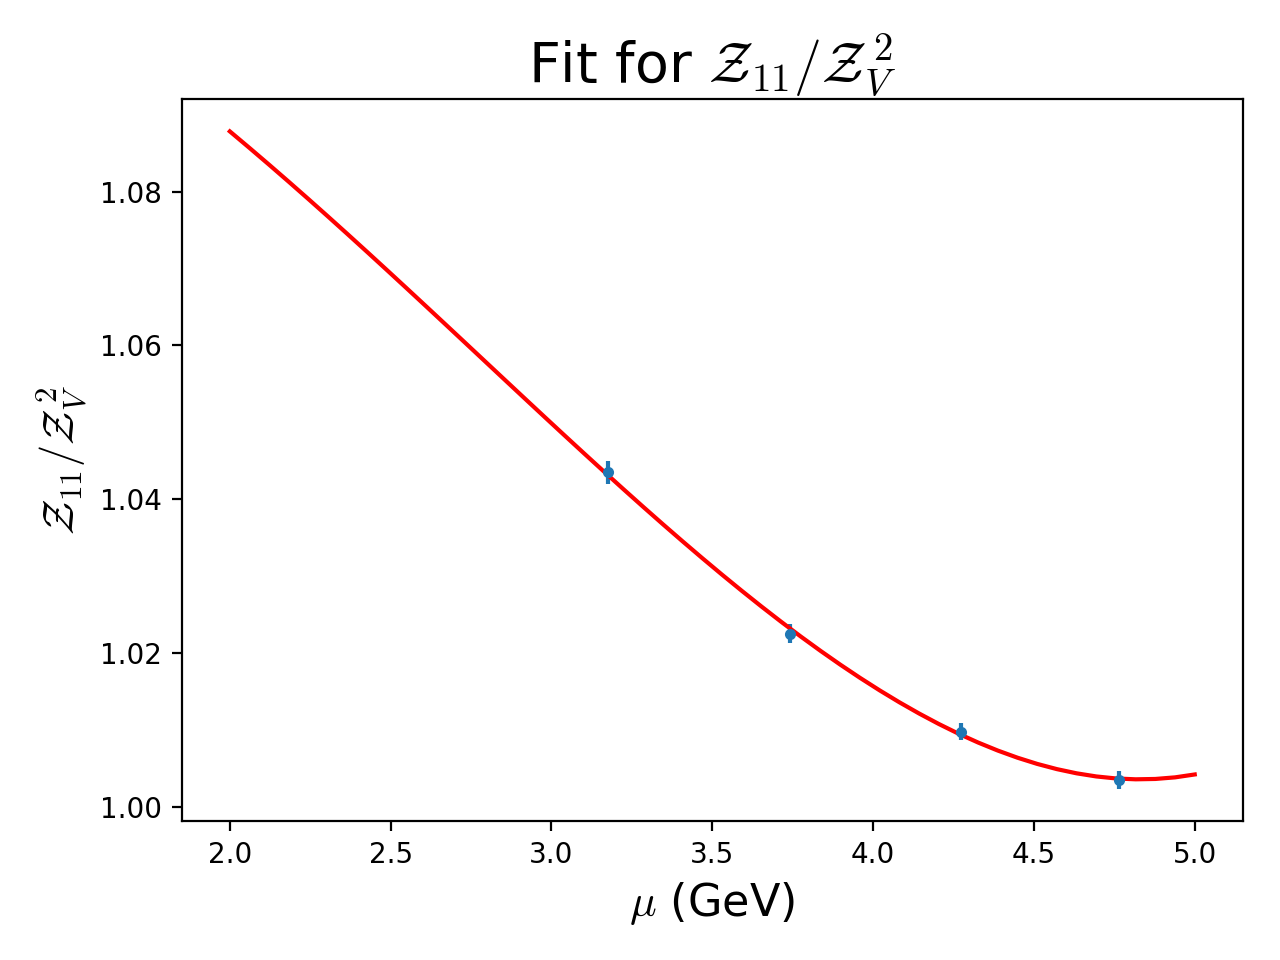

In [87]:
# mom_subset = [2, 3, 4, 5, 6, 7]
# pwr = 3
mom_subset = [3, 4, 5, 6]
pwr = 2
fit_and_plot(Z_chiral_boots[0, 0, mom_subset], scales[mom_subset], pwr, '$\\mathcal{Z}_{11} / \\mathcal{Z}_V^{\\; 2}$')

In [46]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/24I/Z11ZVsq_interp.pdf')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
[ 1.25558617e+00 -1.14906828e-02  3.31332551e-04]
Chi^2: 0.2726510144813073
Extrapolated Z_ij / Z_V^2 = 1.1790079621850427
[ 1.25642664e+00 -1.15587453e-02  3.32742265e-04]
Chi^2: 0.32140151856676324
Extrapolated Z_ij / Z_V^2 = 1.1793500524418332
[ 1.25619914e+00 -1.15633251e-02  3.32502697e-04]
Chi^2: 0.3033061567164987
Extrapolated Z_ij / Z_V^2 = 1.1790619350759832
[ 1.25735183e+00 -1.16207752e-02  3.34019250e-04]
Chi^2: 0.2875877071951624
Extrapolated Z_ij / Z_V^2 = 1.179820410864996
[ 1.25652283e+00 -1.16007062e-02  3.33748807e-04]
Chi^2: 0.24295100751249057
Extrapolated Z_ij / Z_V^2 = 1.1791501275953225
[ 1.25582213e+00 -1.15017481e-02  3.32311445e-04]
Chi^2: 0.29347009842166627
Extrapolated Z_ij / Z_V^2 = 1.1792236276492922
[ 1.25563998e+00 -1.14888472e-02  3.31261659e-04]
Chi^2: 0.24161944334992208
Extrapolated Z_ij / Z_V^2 = 1.179072549212798
[ 1.25721999e+00 -1.16117549e-02  3.34021116e-04]
Chi^2: 0.2752416360709721
Extrapolated Z_ij / Z_V^2 = 

<IPython.core.display.Javascript object>


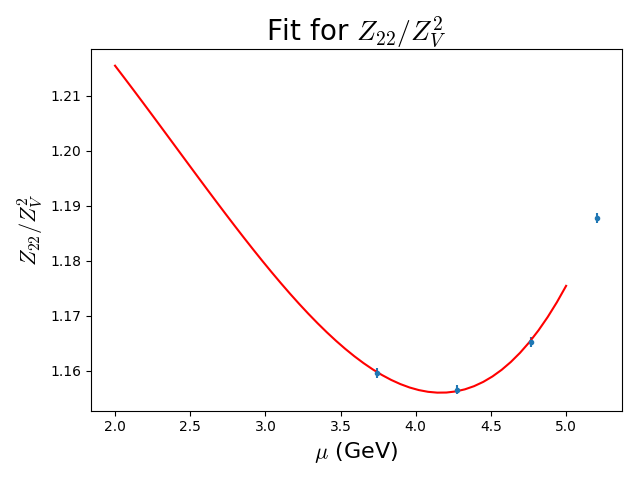

In [93]:
# mom_subset = [2, 3, 4, 5]
# pwr = 2
mom_subset = [4, 5, 6, 7]
pwr = 2
fit_and_plot(Z_chiral_boots[1, 1, mom_subset], scales[mom_subset], pwr, '$Z_{22} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
[ 3.82325949e-01 -1.16678074e-02  3.33775977e-04]
Chi^2: 0.08921878424561086
Extrapolated Z_ij / Z_V^2 = 0.30435153703860407
[ 3.81940760e-01 -1.17118495e-02  3.34163646e-04]
Chi^2: 0.10437290244019161
Extrapolated Z_ij / Z_V^2 = 0.30360136928228126
[ 3.83549879e-01 -1.17377818e-02  3.36587198e-04]
Chi^2: 0.0812132218393287
Extrapolated Z_ij / Z_V^2 = 0.30517340603146903
[ 3.83955508e-01 -1.18511294e-02  3.37593051e-04]
Chi^2: 0.13455498701880028
Extrapolated Z_ij / Z_V^2 = 0.30464038056738624
[ 3.80334577e-01 -1.16057122e-02  3.32758548e-04]
Chi^2: 0.05998569404337117
Extrapolated Z_ij / Z_V^2 = 0.30283660967371284
[ 3.83098811e-01 -1.18049848e-02  3.35389730e-04]
Chi^2: 0.08720637220059946
Extrapolated Z_ij / Z_V^2 = 0.3040205161711062
[ 3.83791419e-01 -1.18830838e-02  3.38215106e-04]
Chi^2: 0.0527936065734187
Extrapolated Z_ij / Z_V^2 = 0.30423908851026626
[ 3.84862349e-01 -1.19801835e-02  3.40137630e-04]
Chi^2: 0.11914758038424632
Extrapolated Z_ij 

[ 3.82478153e-01 -1.17603862e-02  3.35889332e-04]
Chi^2: 0.0878663491023702
Extrapolated Z_ij / Z_V^2 = 0.3038417129252172
[ 3.82461490e-01 -1.17118233e-02  3.34943575e-04]
Chi^2: 0.10465101090477198
Extrapolated Z_ij / Z_V^2 = 0.3041855104278792
[ 3.83436333e-01 -1.18521941e-02  3.37521461e-04]
Chi^2: 0.14768515210034033
Extrapolated Z_ij / Z_V^2 = 0.30410582425474436
[ 3.82050966e-01 -1.16594421e-02  3.33775158e-04]
Chi^2: 0.03518167690598044
Extrapolated Z_ij / Z_V^2 = 0.30415177558651785
[ 3.81657966e-01 -1.16766448e-02  3.34454730e-04]
Chi^2: 0.07114704290695531
Extrapolated Z_ij / Z_V^2 = 0.3036589957611732
[ 3.82960158e-01 -1.17709094e-02  3.35948927e-04]
Chi^2: 0.054589831713258055
Extrapolated Z_ij / Z_V^2 = 0.3042338360559496
[ 3.83328788e-01 -1.18975943e-02  3.38318218e-04]
Chi^2: 0.11606720695889883
Extrapolated Z_ij / Z_V^2 = 0.30365421531151826
[ 3.81516365e-01 -1.16655117e-02  3.34101814e-04]
Chi^2: 0.08548667803359736
Extrapolated Z_ij / Z_V^2 = 0.30358900623798085
[ 3.

<IPython.core.display.Javascript object>


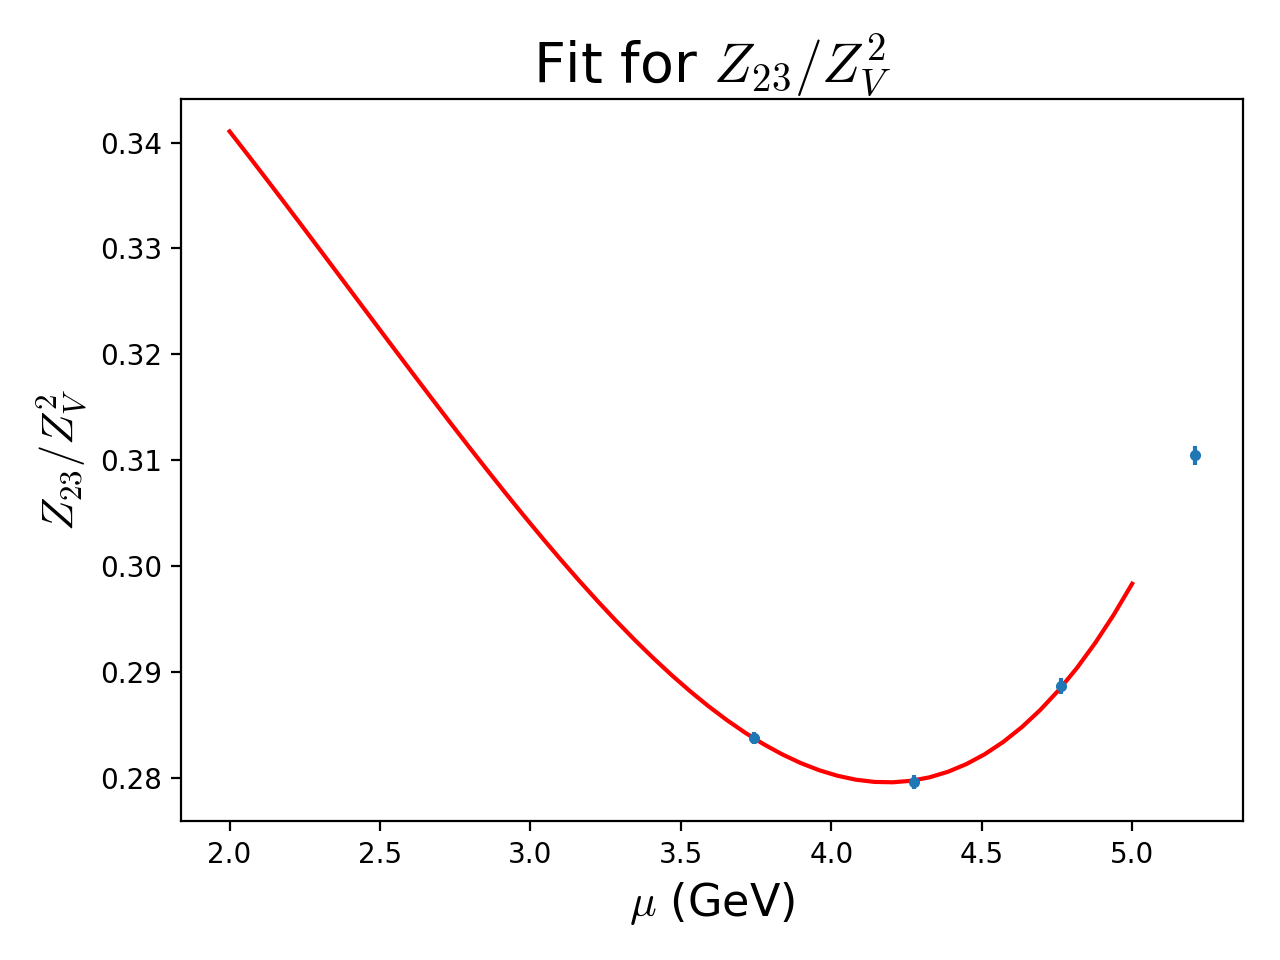

In [97]:
# mom_subset = [3, 4, 5, 6]
# pwr = 2
mom_subset = [4, 5, 6, 7]
pwr = 2
fit_and_plot(Z_chiral_boots[1, 2, mom_subset], scales[mom_subset], pwr, '$Z_{23} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[1.99281451e-02 1.20584804e-03 9.63660035e-07 5.07168078e-07]
Chi^2: 0.20605050660254648
Extrapolated Z_ij / Z_V^2 = 0.03122855944577085
[ 1.91742370e-02  1.34586345e-03 -9.06267704e-06  7.16980652e-07]
Chi^2: 0.04731130436572544
Extrapolated Z_ij / Z_V^2 = 0.031075610098761502
[2.10597271e-02 1.03034540e-03 1.14502426e-05 3.15409595e-07]
Chi^2: 0.07311236898014918
Extrapolated Z_ij / Z_V^2 = 0.03149023903356326
[ 1.91284172e-02  1.39780434e-03 -1.40014134e-05  8.43452800e-07]
Chi^2: 0.006815381488145745
Extrapolated Z_ij / Z_V^2 = 0.03118941888358232
[ 1.92678681e-02  1.36037491e-03 -1.11180161e-05  7.81219383e-07]
Chi^2: 0.07777183710945917
Extrapolated Z_ij / Z_V^2 = 0.031180192000079095
[2.00859521e-02 1.16005183e-03 1.36831069e-06 5.26478905e-07]
Chi^2: 0.006816404105733533
Extrapolated Z_ij / Z_V^2 = 0.031021054804955216
[ 1.93216583e-02  1.31829406e-03 -7.70546542e-06  7.00992042e-07]
Chi^2: 0.035214667971509156
Extrapolated Z_ij / Z_V

[ 1.93261831e-02  1.33597699e-03 -8.40693012e-06  7.17215154e-07]
Chi^2: 0.0007328060939895983
Extrapolated Z_ij / Z_V^2 = 0.031191864519165315
[ 1.92066179e-02  1.34676341e-03 -9.74770953e-06  7.51391479e-07]
Chi^2: 0.0023685273299037064
Extrapolated Z_ij / Z_V^2 = 0.031085688476282895
[ 1.93779682e-02  1.33395906e-03 -9.44287786e-06  7.46221938e-07]
Chi^2: 0.001017749058187888
Extrapolated Z_ij / Z_V^2 = 0.031162722424419954
[ 1.91717061e-02  1.39147352e-03 -1.22927540e-05  7.96066732e-07]
Chi^2: 0.0049741843653992495
Extrapolated Z_ij / Z_V^2 = 0.03127958731797591
[ 1.91217825e-02  1.38703504e-03 -1.34759762e-05  8.38724587e-07]
Chi^2: 0.0006821402527723695
Extrapolated Z_ij / Z_V^2 = 0.031124973960282683
[ 1.92005023e-02  1.37872213e-03 -1.25901707e-05  8.07980491e-07]
Chi^2: 0.0007036466801555588
Extrapolated Z_ij / Z_V^2 = 0.031178215338453275
[ 1.91189760e-02  1.35400332e-03 -1.06967944e-05  7.73068124e-07]
Chi^2: 0.0009395740095357868
Extrapolated Z_ij / Z_V^2 = 0.0310021321936

<IPython.core.display.Javascript object>


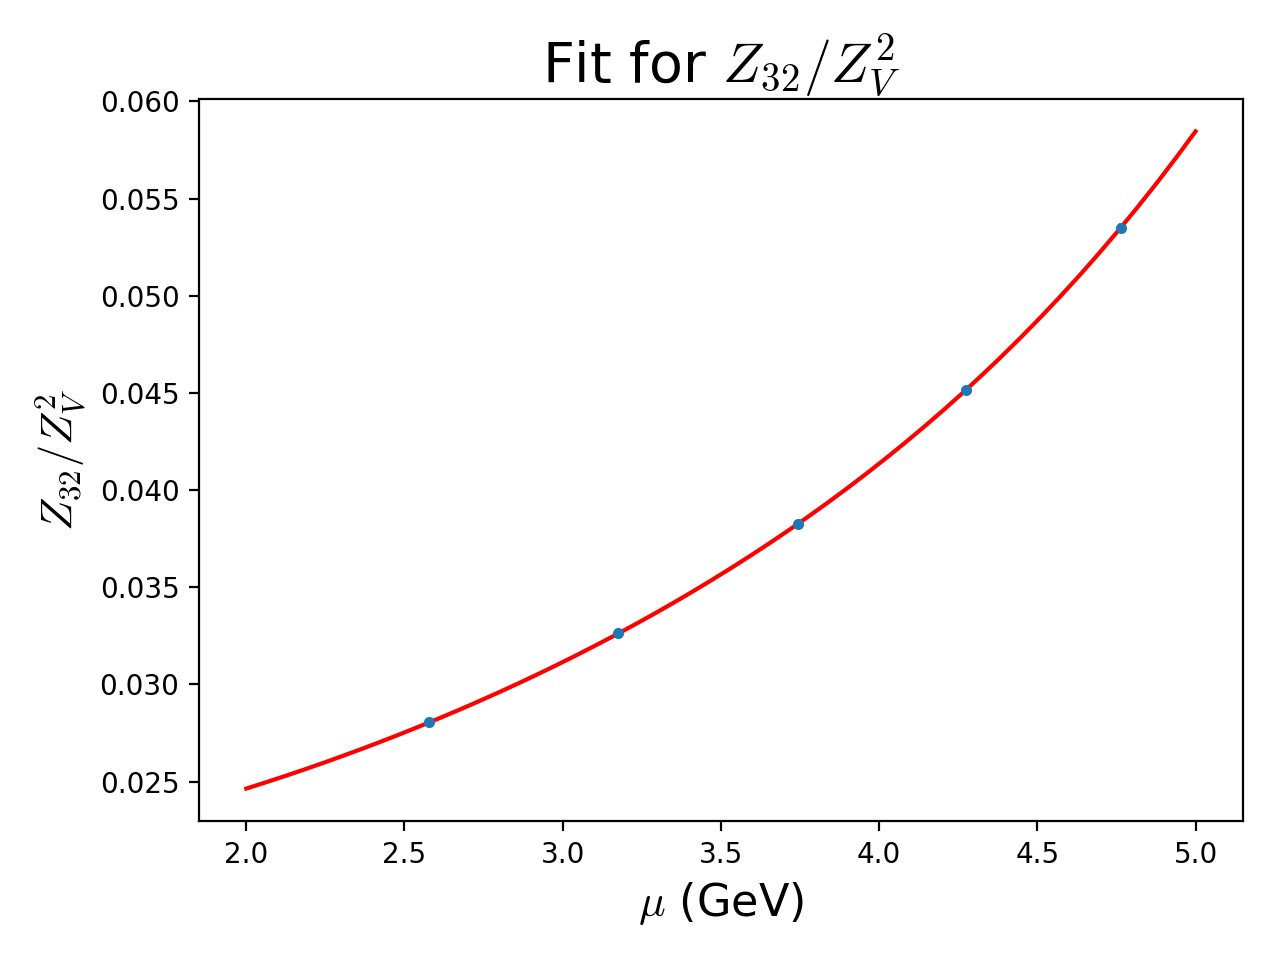

In [101]:
# mom_subset = [3, 4, 5, 6]
# pwr = 3
mom_subset = [2, 3, 4, 5, 6]
pwr = 3
fit_and_plot(Z_chiral_boots[2, 1, mom_subset], scales[mom_subset], pwr, '$Z_{32} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[ 6.30365808e-01  4.48277486e-02 -1.90232453e-03  3.43923868e-05]
Chi^2: 0.09574289609736349
Extrapolated Z_ij / Z_V^2 = 0.9047993087939575
[ 6.32759730e-01  4.44948866e-02 -1.88215159e-03  3.39681181e-05]
Chi^2: 0.6521135926208715
Extrapolated Z_ij / Z_V^2 = 0.9055221883766658
[ 6.42868315e-01  4.25754291e-02 -1.76947338e-03  3.18199508e-05]
Chi^2: 0.29438159898474014
Extrapolated Z_ij / Z_V^2 = 0.9059165766229242
[ 6.31796345e-01  4.47234132e-02 -1.90290383e-03  3.45091425e-05]
Chi^2: 0.7703491452699548
Extrapolated Z_ij / Z_V^2 = 0.9053290177453291
[ 6.26309436e-01  4.58514620e-02 -1.96668520e-03  3.56184486e-05]
Chi^2: 1.054824579307407
Extrapolated Z_ij / Z_V^2 = 0.9056369410351213
[ 6.22682093e-01  4.58751817e-02 -1.95332522e-03  3.52731350e-05]
Chi^2: 0.306648781971269
Extrapolated Z_ij / Z_V^2 = 0.9030535002462414
[ 6.19289080e-01  4.68344625e-02 -2.02142338e-03  3.67296453e-05]
Chi^2: 0.9933476082393123
Extrapolated Z_ij / Z_V^2 = 0.

[ 6.31866709e-01  4.49890465e-02 -1.92442446e-03  3.50355758e-05]
Chi^2: 1.3798018800092073
Extrapolated Z_ij / Z_V^2 = 0.9064306806921498
[ 6.23628022e-01  4.59310919e-02 -1.97036793e-03  3.57684728e-05]
Chi^2: 1.023949363360612
Extrapolated Z_ij / Z_V^2 = 0.9034832642506236
[ 6.27957309e-01  4.56205819e-02 -1.96315848e-03  3.57865770e-05]
Chi^2: 1.0447034226353429
Extrapolated Z_ij / Z_V^2 = 0.9056151235856023
[ 6.27020255e-01  4.56356141e-02 -1.95791557e-03  3.55739311e-05]
Chi^2: 0.8596717558835595
Extrapolated Z_ij / Z_V^2 = 0.9050830166583869
[ 6.29332164e-01  4.53416993e-02 -1.94110880e-03  3.52826395e-05]
Chi^2: 0.7663377218373408
Extrapolated Z_ij / Z_V^2 = 0.9058986890621602
[ 6.21756972e-01  4.60973953e-02 -1.97292509e-03  3.57134528e-05]
Chi^2: 0.8412972829535859
Extrapolated Z_ij / Z_V^2 = 0.902861704324963
[ 6.24665062e-01  4.55477125e-02 -1.93964639e-03  3.50940470e-05]
Chi^2: 1.0577817064080242
Extrapolated Z_ij / Z_V^2 = 0.9030666769186737
[ 6.27458767e-01  4.55055900e

<IPython.core.display.Javascript object>


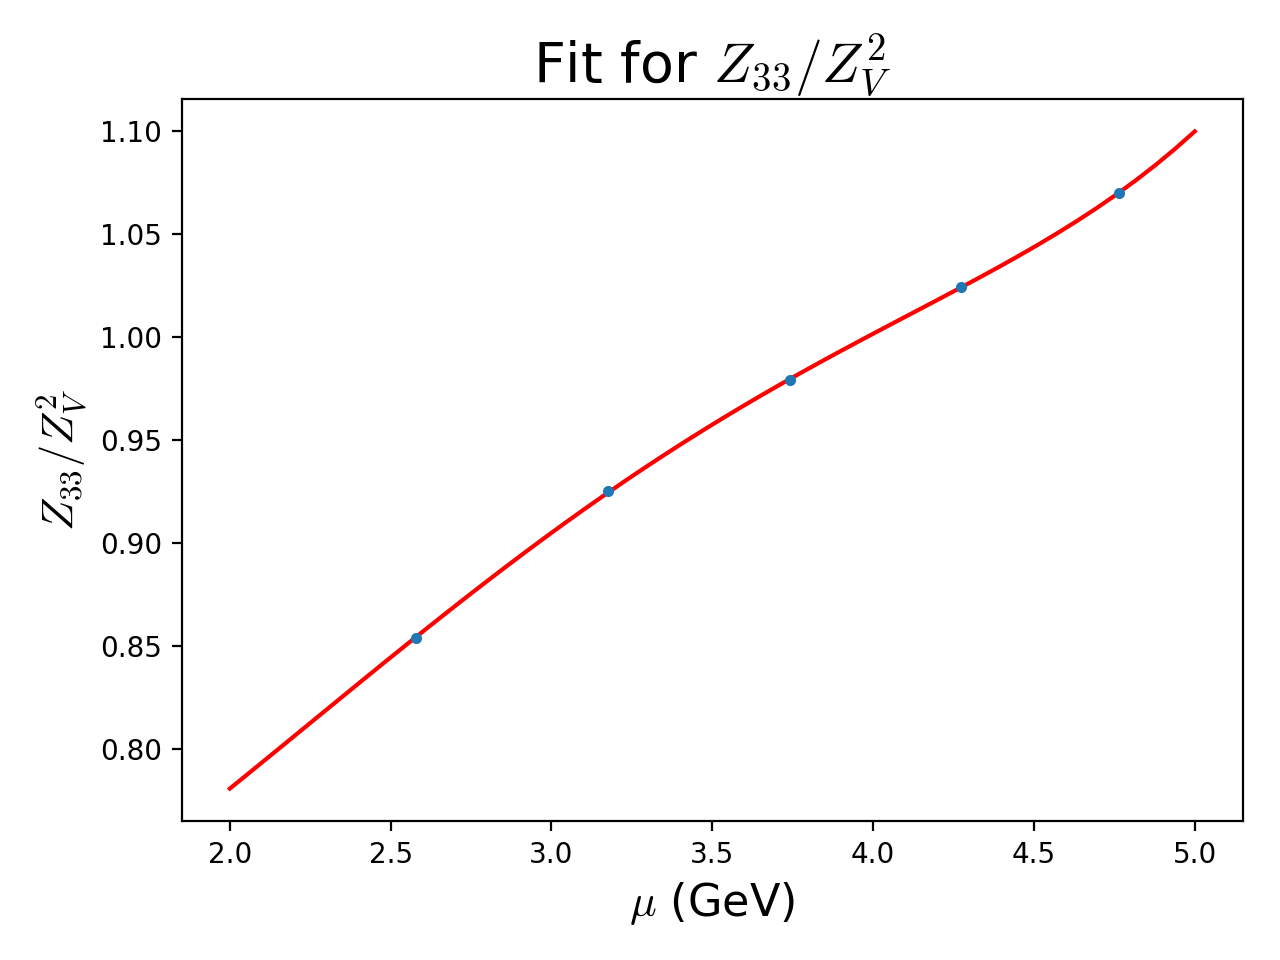

In [94]:
# mom_subset = [2, 3, 4, 5, 6]
# pwr = 3
mom_subset = [2, 3, 4, 5, 6]
pwr = 3
fit_and_plot(Z_chiral_boots[2, 2, mom_subset], scales[mom_subset], pwr, '$Z_{33} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[ 7.57853170e-01  3.15350125e-02 -1.19718808e-03  2.19519534e-05]
Chi^2: 0.4389613143644703
Extrapolated Z_ij / Z_V^2 = 0.9606990223991729
[ 7.58953890e-01  3.14474997e-02 -1.19394919e-03  2.18880805e-05]
Chi^2: 0.376531385457125
Extrapolated Z_ij / Z_V^2 = 0.9612279136217953
[ 7.64000742e-01  3.05347108e-02 -1.14448999e-03  2.10483043e-05]
Chi^2: 0.21141714931373878
Extrapolated Z_ij / Z_V^2 = 0.9614536639704145
[ 7.56063024e-01  3.17967740e-02 -1.21103046e-03  2.21782607e-05]
Chi^2: 0.8992824474897099
Extrapolated Z_ij / Z_V^2 = 0.9603084749873406
[ 7.57359301e-01  3.18622040e-02 -1.21757604e-03  2.22797560e-05]
Chi^2: 0.7269137217785987
Extrapolated Z_ij / Z_V^2 = 0.9617374196870607
[ 7.51952979e-01  3.21625005e-02 -1.22118807e-03  2.22609181e-05]
Chi^2: 0.4247293123551382
Extrapolated Z_ij / Z_V^2 = 0.9587274588312075
[ 7.53074766e-01  3.21791391e-02 -1.22390331e-03  2.22968265e-05]
Chi^2: 1.4021238803215532
Extrapolated Z_ij / Z_V^2 = 0.

Chi^2: 0.8600680885541987
Extrapolated Z_ij / Z_V^2 = 0.9584038513129534
[ 7.52686939e-01  3.19956379e-02 -1.21213333e-03  2.21017434e-05]
Chi^2: 0.9008093090926381
Extrapolated Z_ij / Z_V^2 = 0.9585770519734481
[ 7.57035809e-01  3.16359173e-02 -1.20100342e-03  2.19838889e-05]
Chi^2: 1.1014770915144043
Extrapolated Z_ij / Z_V^2 = 0.9605040421164687
[ 7.54488343e-01  3.19242493e-02 -1.21500640e-03  2.21987642e-05]
Chi^2: 0.8921973343834513
Extrapolated Z_ij / Z_V^2 = 0.9595739669908002
[ 7.58654303e-01  3.13542577e-02 -1.18488873e-03  2.17007604e-05]
Chi^2: 1.0475469994567523
Extrapolated Z_ij / Z_V^2 = 0.9606864889574769
[ 7.60693080e-01  3.12760303e-02 -1.18774821e-03  2.18031233e-05]
Chi^2: 1.0976116363810562
Extrapolated Z_ij / Z_V^2 = 0.9618642245440284
[ 7.55634066e-01  3.18789202e-02 -1.21459099e-03  2.22290766e-05]
Chi^2: 0.825603656430084
Extrapolated Z_ij / Z_V^2 = 0.9603674745820626
[ 7.63561845e-01  3.08335231e-02 -1.16476715e-03  2.14320272e-05]
Chi^2: 1.1599339117812513
Ex

<IPython.core.display.Javascript object>


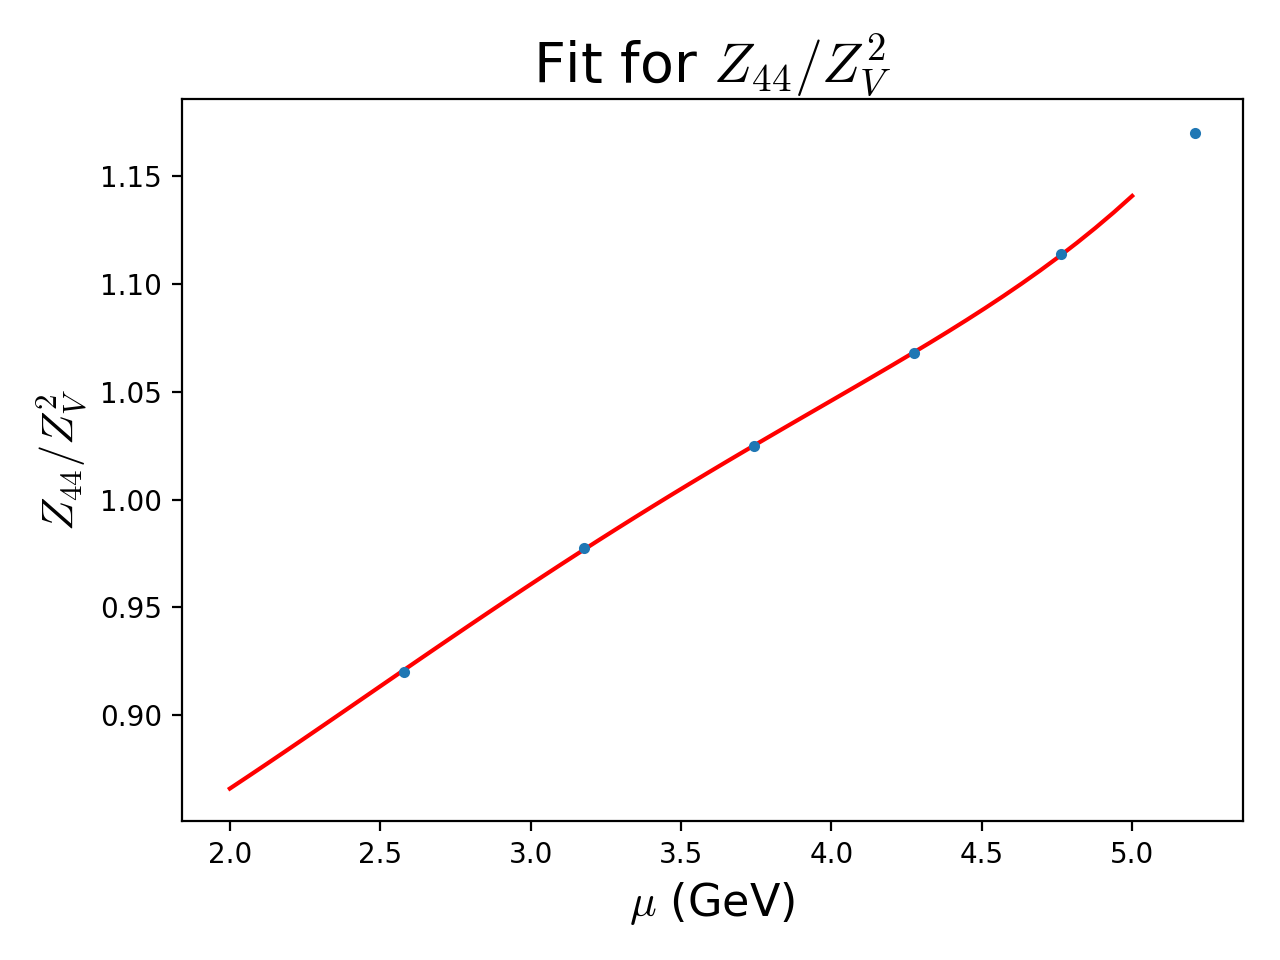

In [102]:
# mom_subset = [2, 3, 4, 5, 6]
# pwr = 3
mom_subset = [2, 3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(Z_chiral_boots[3, 3, mom_subset], scales[mom_subset], pwr, '$Z_{44} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[-5.83999625e-03 -3.15721713e-03  9.19061321e-05 -2.11044715e-06]
Chi^2: 0.14768925908227734
Extrapolated Z_ij / Z_V^2 = -0.028349069683417306
[-5.26082749e-03 -3.20700662e-03  9.42029895e-05 -2.13845154e-06]
Chi^2: 0.19682884803900141
Extrapolated Z_ij / Z_V^2 = -0.028052376097588875
[-7.43003668e-03 -2.91870958e-03  7.88153585e-05 -1.88730897e-06]
Chi^2: 0.3207991000384838
Extrapolated Z_ij / Z_V^2 = -0.028690227135603437
[-5.55595374e-03 -3.18727165e-03  9.41196732e-05 -2.15251654e-06]
Chi^2: 0.1633530013469001
Extrapolated Z_ij / Z_V^2 = -0.02818688958726012
[-5.36916639e-03 -3.21865387e-03  9.54404574e-05 -2.16947184e-06]
Chi^2: 0.19683559965972205
Extrapolated Z_ij / Z_V^2 = -0.028187919147152046
[-5.60491778e-03 -3.14179639e-03  9.15818863e-05 -2.10498744e-06]
Chi^2: 0.2071939600638868
Extrapolated Z_ij / Z_V^2 = -0.02799748830943745
[-5.26793098e-03 -3.23384270e-03  9.68149358e-05 -2.20168236e-06]
Chi^2: 0.1996414542150276
Extrapolate

[-6.01193479e-03 -3.09094163e-03  8.84258255e-05 -2.04835886e-06]
Chi^2: 0.19361057321161668
Extrapolated Z_ij / Z_V^2 = -0.028161171206650733
[-5.61897858e-03 -3.17474111e-03  9.25457632e-05 -2.12079414e-06]
Chi^2: 0.21247637689782894
Extrapolated Z_ij / Z_V^2 = -0.028241500714023968
[-5.40893334e-03 -3.17936622e-03  9.27619854e-05 -2.12262586e-06]
Chi^2: 0.24242147838663033
Extrapolated Z_ij / Z_V^2 = -0.02805690276063079
[-5.36436259e-03 -3.21325880e-03  9.52926163e-05 -2.16998469e-06]
Chi^2: 0.18269694290053537
Extrapolated Z_ij / Z_V^2 = -0.028146908658848998
[-5.52451152e-03 -3.21501939e-03  9.51141970e-05 -2.16544063e-06]
Chi^2: 0.15108459618692646
Extrapolated Z_ij / Z_V^2 = -0.028334042304499273
[-5.41242647e-03 -3.20193477e-03  9.49547128e-05 -2.16776933e-06]
Chi^2: 0.16139643485285016
Extrapolated Z_ij / Z_V^2 = -0.028118811483413133
[-5.21099815e-03 -3.25024624e-03  9.77304123e-05 -2.21226248e-06]
Chi^2: 0.17252877056787205
Extrapolated Z_ij / Z_V^2 = -0.028159790216041147


<IPython.core.display.Javascript object>


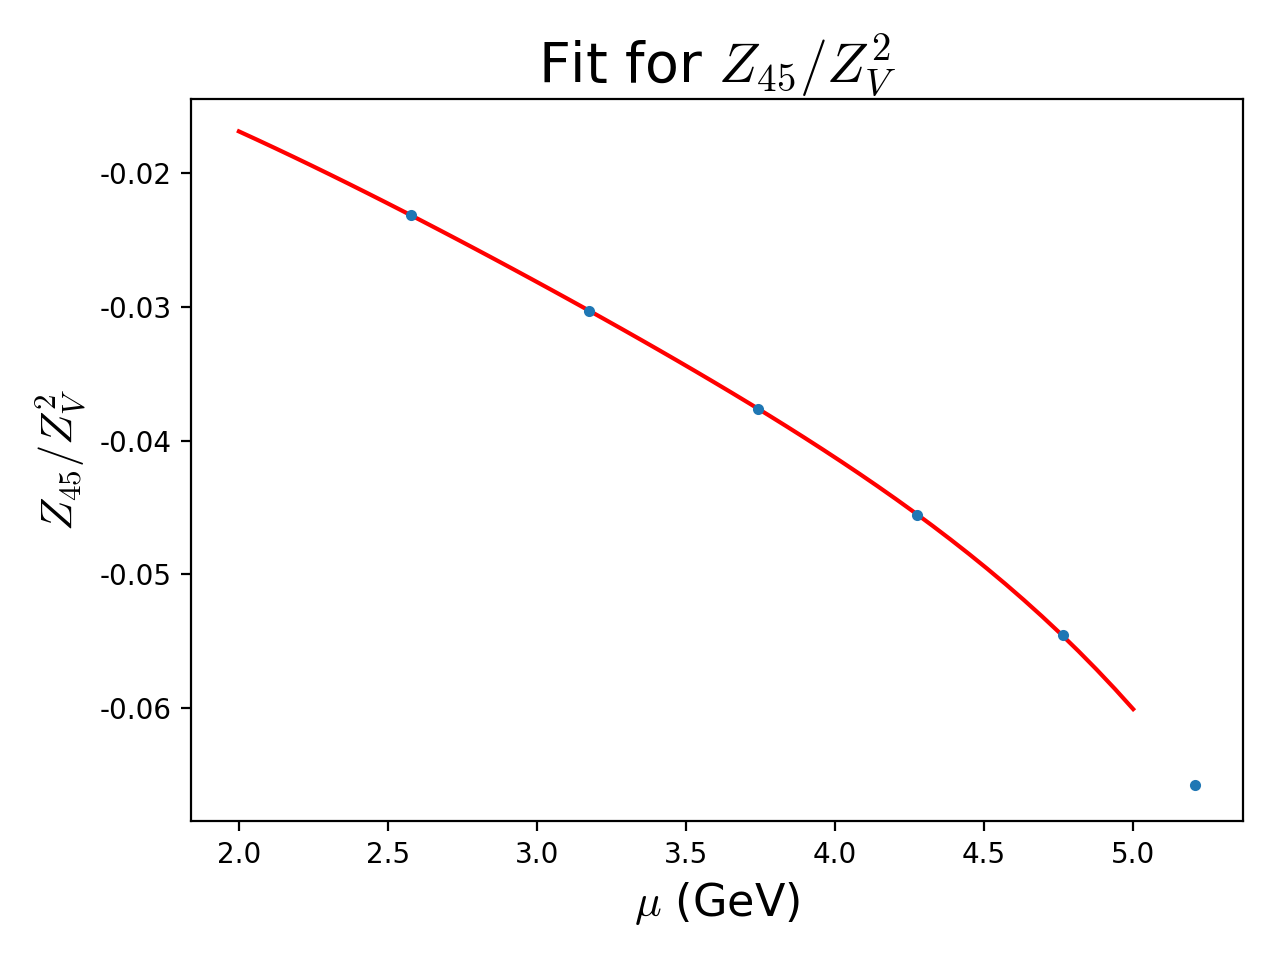

In [115]:
mom_subset = [2, 3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(Z_chiral_boots[3, 4, mom_subset], scales[mom_subset], pwr, '$Z_{45} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
[-3.57018199e-01  1.12254061e-02 -2.88346669e-04]
Chi^2: 0.307072368204801
Extrapolated Z_ij / Z_V^2 = -0.27934562428647364
[-3.56300112e-01  1.12261990e-02 -2.88044770e-04]
Chi^2: 0.31950166203912556
Extrapolated Z_ij / Z_V^2 = -0.2785959480797366
[-3.57825347e-01  1.12334642e-02 -2.89164032e-04]
Chi^2: 0.25771035205041315
Extrapolated Z_ij / Z_V^2 = -0.2801464563471382
[-3.57897927e-01  1.13016413e-02 -2.89827869e-04]
Chi^2: 0.3030237916996855
Extrapolated Z_ij / Z_V^2 = -0.27965921306445013
[-3.54807878e-01  1.11543161e-02 -2.87463445e-04]
Chi^2: 0.35964628842366636
Extrapolated Z_ij / Z_V^2 = -0.27770357164889015
[-3.59130900e-01  1.14548123e-02 -2.92590273e-04]
Chi^2: 0.4141367318327978
Extrapolated Z_ij / Z_V^2 = -0.2797374015953188
[-3.58177212e-01  1.14172372e-02 -2.92633921e-04]
Chi^2: 0.2805176296380125
Extrapolated Z_ij / Z_V^2 = -0.27912542439530885
[-3.59702102e-01  1.15106763e-02 -2.94371736e-04]
Chi^2: 0.3745404085799364
Extrapolated Z_ij

[-3.57002616e-01  1.12983178e-02 -2.89738272e-04]
Chi^2: 0.39046216199056305
Extrapolated Z_ij / Z_V^2 = -0.2787865564732117
[-3.57753422e-01  1.13664995e-02 -2.91332896e-04]
Chi^2: 0.3523857682775351
Extrapolated Z_ij / Z_V^2 = -0.27905289047238957
[-3.57680941e-01  1.13820577e-02 -2.91651875e-04]
Chi^2: 0.3715532251033206
Extrapolated Z_ij / Z_V^2 = -0.27886622341078887
[-3.58119137e-01  1.13408658e-02 -2.90523494e-04]
Chi^2: 0.35653436065919525
Extrapolated Z_ij / Z_V^2 = -0.2795837472429691
[-3.57518566e-01  1.13332473e-02 -2.90560614e-04]
Chi^2: 0.3566068606120806
Extrapolated Z_ij / Z_V^2 = -0.2790547498364389
[-3.56218507e-01  1.12741671e-02 -2.89608913e-04]
Chi^2: 0.4458085245617319
Extrapolated Z_ij / Z_V^2 = -0.2782093251457282
[-3.58137273e-01  1.13924592e-02 -2.91924273e-04]
Chi^2: 0.3873447689476532
Extrapolated Z_ij / Z_V^2 = -0.27925100571229056
[-3.57420477e-01  1.12887867e-02 -2.89808529e-04]
Chi^2: 0.3268320825554958
Extrapolated Z_ij / Z_V^2 = -0.2792958875406386
[-3

<IPython.core.display.Javascript object>


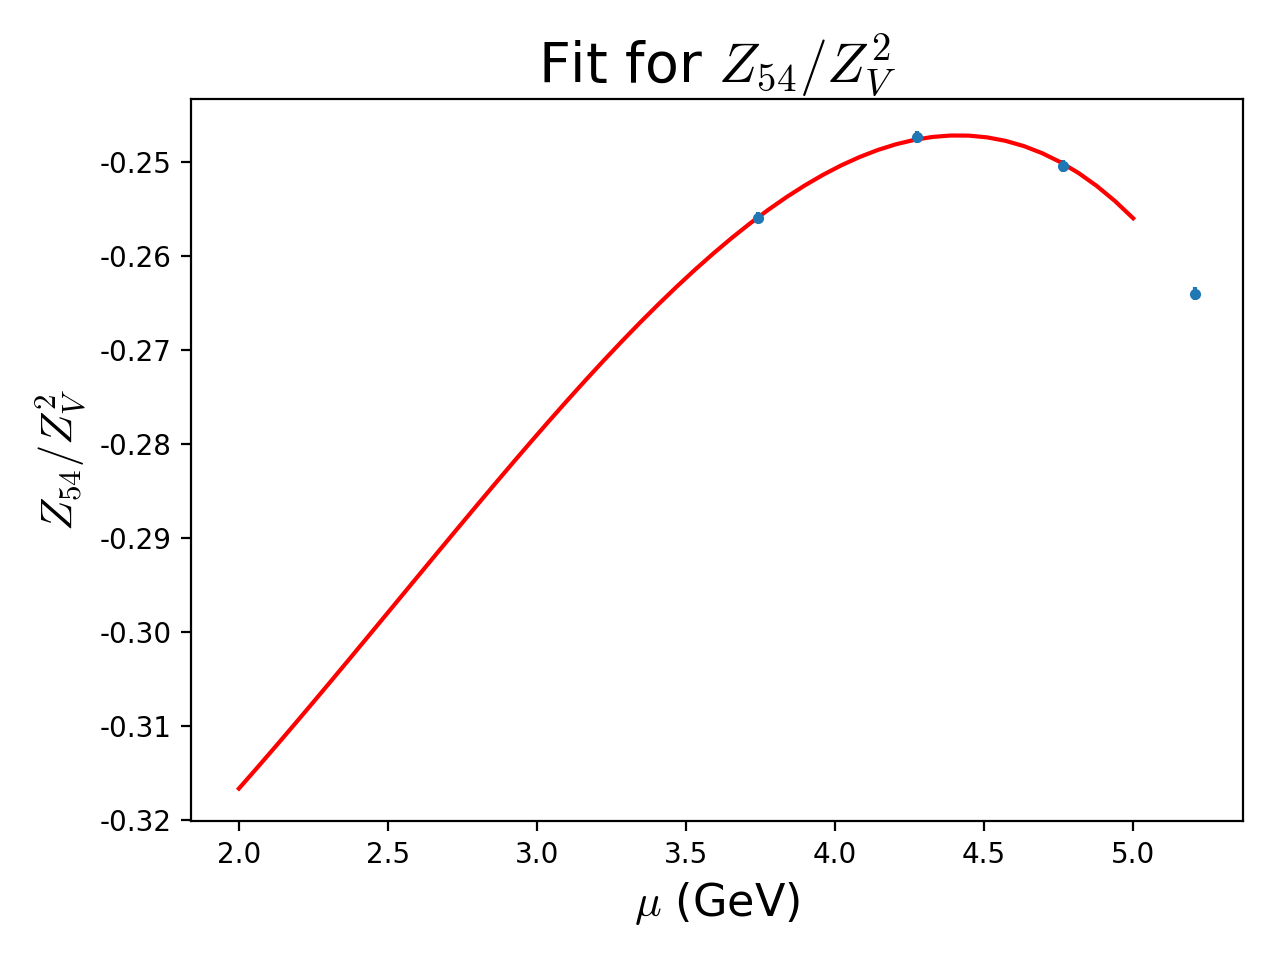

In [118]:
mom_subset = [4, 5, 6, 7]
pwr = 2
fit_and_plot(Z_chiral_boots[4, 3, mom_subset], scales[mom_subset], pwr, '$Z_{54} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
[ 1.30743707e+00 -1.50696245e-02  2.70795867e-04]
Chi^2: 10.022145628400526
Extrapolated Z_ij / Z_V^2 = 1.1937449106752378
[ 1.30929407e+00 -1.52090737e-02  2.74099671e-04]
Chi^2: 9.782774686533557
Extrapolated Z_ij / Z_V^2 = 1.1946144803765062
[ 1.31723688e+00 -1.60974137e-02  2.94743716e-04]
Chi^2: 9.083175765147299
Extrapolated Z_ij / Z_V^2 = 1.196234395530384
[ 1.30860074e+00 -1.51273788e-02  2.71812610e-04]
Chi^2: 10.017764334781987
Extrapolated Z_ij / Z_V^2 = 1.1944711489715256
[ 1.30276332e+00 -1.46049079e-02  2.60176546e-04]
Chi^2: 10.392827310854063
Extrapolated Z_ij / Z_V^2 = 1.1923934445392392
[ 1.31237521e+00 -1.54826698e-02  2.80919398e-04]
Chi^2: 9.739606551760934
Extrapolated Z_ij / Z_V^2 = 1.195785652519331
[ 1.30938578e+00 -1.52152252e-02  2.74117801e-04]
Chi^2: 9.796482647507325
Extrapolated Z_ij / Z_V^2 = 1.194652296861019
[ 1.30441485e+00 -1.46794871e-02  2.61415942e-04]
Chi^2: 10.370212755411929
Extrapolated Z_ij / Z_V^2 = 1.1934741

[ 1.30206266e+00 -1.46811125e-02  2.62043664e-04]
Chi^2: 9.873886267256106
Extrapolated Z_ij / Z_V^2 = 1.1911581793405952
[ 1.30322652e+00 -1.45483814e-02  2.57928215e-04]
Chi^2: 10.53340651191413
Extrapolated Z_ij / Z_V^2 = 1.1931832745871875
[ 1.31282844e+00 -1.55748137e-02  2.83099899e-04]
Chi^2: 10.156603437613247
Extrapolated Z_ij / Z_V^2 = 1.1955862054243653
[ 1.30330424e+00 -1.46035928e-02  2.60176476e-04]
Chi^2: 10.348818619391206
Extrapolated Z_ij / Z_V^2 = 1.1929462034022258
[ 1.32113679e+00 -1.62879795e-02  2.99380356e-04]
Chi^2: 9.923839755189265
Extrapolated Z_ij / Z_V^2 = 1.1987947789197106
[ 1.31787046e+00 -1.59108057e-02  2.90380978e-04]
Chi^2: 9.667498918872276
Extrapolated Z_ij / Z_V^2 = 1.198194069488683
[ 1.30758715e+00 -1.50781595e-02  2.70999241e-04]
Chi^2: 9.950392400924132
Extrapolated Z_ij / Z_V^2 = 1.1938346578103272
[ 1.30734995e+00 -1.49454396e-02  2.67857368e-04]
Chi^2: 10.270951583393801
Extrapolated Z_ij / Z_V^2 = 1.1945374398791813
[ 1.30659275e+00 -1.49

<IPython.core.display.Javascript object>


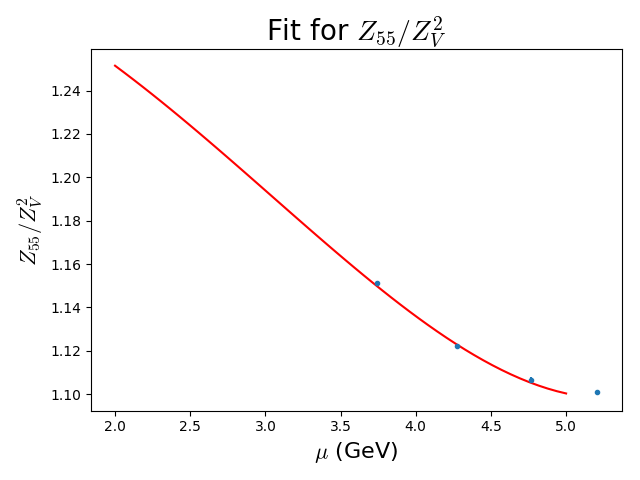

In [113]:
# mom_subset = [3, 4, 5, 7]
# pwr = 2
mom_subset = [4, 5, 6, 7]
pwr = 2
fit_and_plot(Z_chiral_boots[4, 4, mom_subset], scales[mom_subset], pwr, '$Z_{55} / Z_V^2$')

Anomalous dimension of ZV vanishes because it's scale independent-- same for ZA. This is why it doesn't matter when we divide out by ZV, since it's scale independent so only Z_ij can be run. Check out Aoki paper for a bit more about ZV and ZA, also 1908.10116, 1411.7017, and 1710.08678. Also check Gracey

Big question: why does no one compute ZV non-perturbatively? It's always computed with PCAC or something else, never in the same way that Zq or Zij are computed. What am I missing? And when / why would we expect ZV = 1, is that only for the fully conserved 5d domain wall vector / axial current?
For these questions, check 1004.1115-- it mentions that \textbf{for scale-independent RCs, i.e. ZV, ZA, and ZP / ZS, other methods than RI/MOM must be used}. Not sure why yet, but it seems promising

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[8.22853518e-01 3.25920305e-02 2.43219146e-06 5.89774092e-07]
Chi^2: 114.67058125887742
Extrapolated Z_ij / Z_V^2 = 1.116808745194982
[8.22188283e-01 3.26283704e-02 1.88790441e-06 5.93910187e-07]
Chi^2: 113.56110894081077
Extrapolated Z_ij / Z_V^2 = 1.1164294980170177
[8.22105314e-01 3.26507312e-02 1.92225780e-06 5.94467491e-07]
Chi^2: 113.37889734210455
Extrapolated Z_ij / Z_V^2 = 1.1165509645289615
[8.22116000e-01 3.26367676e-02 1.86341602e-06 5.93909391e-07]
Chi^2: 116.70967342756624
Extrapolated Z_ij / Z_V^2 = 1.1164308049344973
[8.21750098e-01 3.26530292e-02 1.60779794e-06 5.96206812e-07]
Chi^2: 118.59451082831154
Extrapolated Z_ij / Z_V^2 = 1.1161922271432534
[8.21726334e-01 3.26541433e-02 1.39477245e-06 5.95453974e-07]
Chi^2: 121.0403558481472
Extrapolated Z_ij / Z_V^2 = 1.1161606857607091
[8.22299727e-01 3.26462406e-02 1.68261637e-06 5.94602806e-07]
Chi^2: 118.67200763158229
Extrapolated Z_ij / Z_V^2 = 1.1166856496237731
[8.22266189e-

[8.21965982e-01 3.26396065e-02 1.78512075e-06 5.94162423e-07]
Chi^2: 113.30041351447116
Extrapolated Z_ij / Z_V^2 = 1.1163001792910539
[8.22127014e-01 3.26314050e-02 1.95188642e-06 5.92856366e-07]
Chi^2: 113.78108554457131
Extrapolated Z_ij / Z_V^2 = 1.1163999537635452
[8.21661810e-01 3.26577694e-02 1.55016873e-06 5.95971151e-07]
Chi^2: 117.34267276242095
Extrapolated Z_ij / Z_V^2 = 1.1161417608419681
[8.21941947e-01 3.26428043e-02 1.75965470e-06 5.94367956e-07]
Chi^2: 115.32482341132747
Extrapolated Z_ij / Z_V^2 = 1.1163030121093587
[8.21968154e-01 3.26435000e-02 1.78963468e-06 5.94645361e-07]
Chi^2: 112.4799454962358
Extrapolated Z_ij / Z_V^2 = 1.1163381102967402
[8.21724974e-01 3.26545632e-02 1.68515153e-06 5.95302434e-07]
Chi^2: 115.974038106266
Extrapolated Z_ij / Z_V^2 = 1.1161865158327713
[8.21978079e-01 3.26299455e-02 1.84548439e-06 5.92692808e-07]
Chi^2: 113.52699920939426
Extrapolated Z_ij / Z_V^2 = 1.1162291463746552
[8.21835578e-01 3.26348969e-02 1.83031430e-06 5.93820436e-

<IPython.core.display.Javascript object>


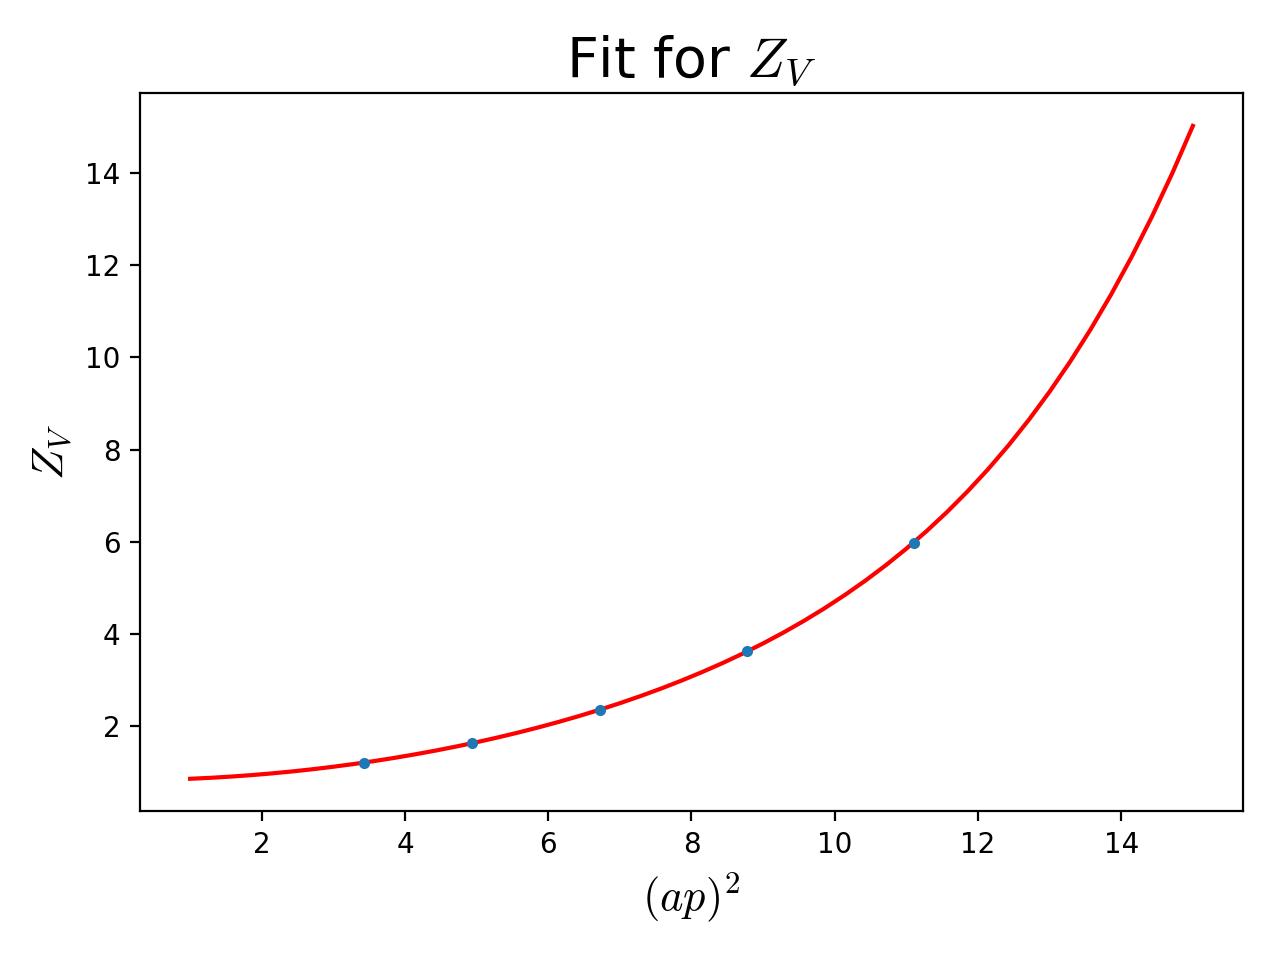

In [55]:
# mom_subset = [0, 1, 2, 3, 4]
mom_subset = [3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(ZV_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_V$', x_range = [1, 15], x_label = '$(ap)^2$')    # index ZV_extrap at 1 for 32I
# fit_and_plot(ZV_extrap[0][mom_subset], scales[mom_subset], pwr, '$Z_V$', x_range = [1, 5])    # index ZV_extrap at 1 for 32I

In [56]:
1.13/1.3

0.8692307692307691

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
[1.06484669e+00 2.47619131e-02 2.63995814e-04]
Chi^2: 5496.943570251061
Extrapolated Z_ij / Z_V^2 = 1.3090875717560717
[1.06332585e+00 2.47558401e-02 2.63803297e-04]
Chi^2: 5498.305505315306
Extrapolated Z_ij / Z_V^2 = 1.3074964766512172
[1.06184865e+00 2.47585308e-02 2.63707094e-04]
Chi^2: 5504.300532320629
Extrapolated Z_ij / Z_V^2 = 1.3060357005861667
[1.06318221e+00 2.47460505e-02 2.63817701e-04]
Chi^2: 5498.852186593431
Extrapolated Z_ij / Z_V^2 = 1.3072658975095799
[1.06262036e+00 2.47376438e-02 2.63719744e-04]
Chi^2: 5490.367337021774
Extrapolated Z_ij / Z_V^2 = 1.3066204520316083
[1.06425723e+00 2.47398427e-02 2.63920147e-04]
Chi^2: 5483.378589981385
Extrapolated Z_ij / Z_V^2 = 1.3082933461486572
[1.06371294e+00 2.47524617e-02 2.63820410e-04]
Chi^2: 5507.896970479934
Extrapolated Z_ij / Z_V^2 = 1.3078545522806821
[1.06369646e+00 2.47505417e-02 2.63881277e-04]
Chi^2: 5491.3369044434085
Extrapolated Z_ij / Z_V^2 = 1.3078257222937117
[1.06144544e+0

[1.06372068e+00 2.47540149e-02 2.63875617e-04]
Chi^2: 5498.482872563026
Extrapolated Z_ij / Z_V^2 = 1.3078807340827643
[1.06291350e+00 2.47507473e-02 2.63774680e-04]
Chi^2: 5498.954304044908
Extrapolated Z_ij / Z_V^2 = 1.3070359739764792
[1.06331321e+00 2.47479571e-02 2.63800174e-04]
Chi^2: 5492.927087352415
Extrapolated Z_ij / Z_V^2 = 1.3074126340669507
[1.06341768e+00 2.47510004e-02 2.63821850e-04]
Chi^2: 5497.151750446296
Extrapolated Z_ij / Z_V^2 = 1.3075462496070904
[1.06336056e+00 2.47550286e-02 2.63843356e-04]
Chi^2: 5499.28606826735
Extrapolated Z_ij / Z_V^2 = 1.3075271279400091
[1.06291794e+00 2.47529271e-02 2.63758798e-04]
Chi^2: 5499.31232103562
Extrapolated Z_ij / Z_V^2 = 1.3070587450447737
[1.06362209e+00 2.47517008e-02 2.63844557e-04]
Chi^2: 5496.856910471163
Extrapolated Z_ij / Z_V^2 = 1.3077588092692347
[1.06356125e+00 2.47517965e-02 2.63829589e-04]
Chi^2: 5498.123890211916
Extrapolated Z_ij / Z_V^2 = 1.3076976183063223
[1.06371974e+00 2.47532057e-02 2.63887852e-04]
Chi

<IPython.core.display.Javascript object>


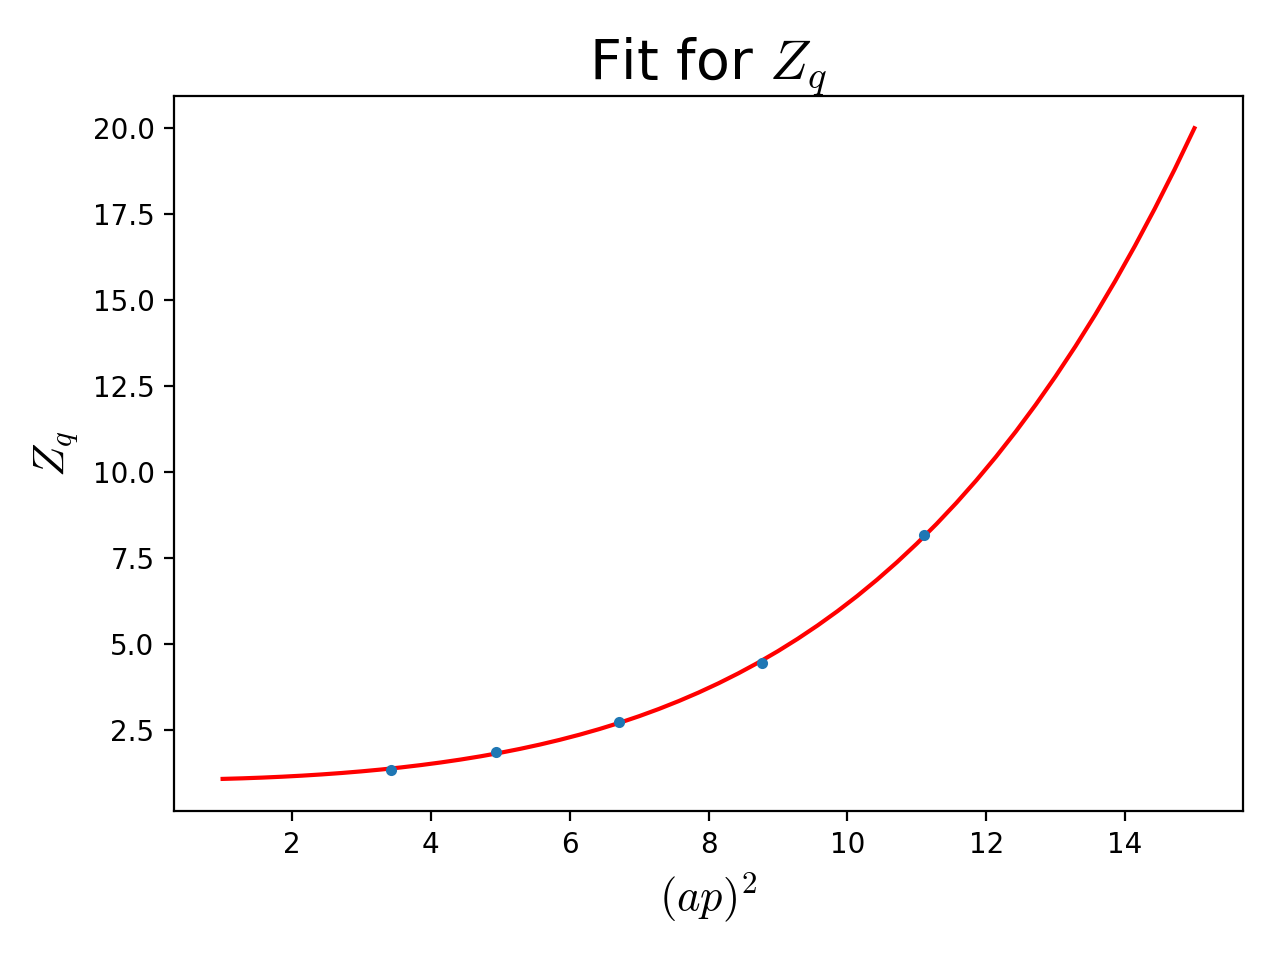

In [57]:
mom_subset = [3, 4, 5, 6, 7]
pwr = 2
# fit_and_plot(Zq_extrap[0][mom_subset], scales[mom_subset] ** 2, pwr, '$Z_q$', x_range = [1, 25], x_label = '$μ^2 (GeV^2)$')
fit_and_plot(Zq_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_q$', x_range = [1, 15], x_label = '$(ap)^2$')
# fit_and_plot(Zq_extrap[0][mom_subset], scales[mom_subset], pwr, '$Z_q$', x_range = [1, 5])

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[1.11981284e+00 7.30131112e-04 6.54211583e-06 3.23696322e-08]
Chi^2: 1.265256582064257
Extrapolated Z_ij / Z_V^2 = 1.1269375241871755
[1.11870094e+00 7.33494877e-04 6.51214686e-06 3.21203522e-08]
Chi^2: 1.227098776062678
Extrapolated Z_ij / Z_V^2 = 1.1258532902995786
[1.11730298e+00 7.39330552e-04 6.48667841e-06 3.19309559e-08]
Chi^2: 1.0564480638712148
Extrapolated Z_ij / Z_V^2 = 1.1245056546657743
[1.11849793e+00 7.29339779e-04 6.52431560e-06 3.22402407e-08]
Chi^2: 1.3470356296005999
Extrapolated Z_ij / Z_V^2 = 1.1256139582002802
[1.11814033e+00 7.26710405e-04 6.51342693e-06 3.21728822e-08]
Chi^2: 1.5757443257528942
Extrapolated Z_ij / Z_V^2 = 1.1252317693934555
[1.12037639e+00 6.56906135e-04 7.69713062e-06 2.69387570e-08]
Chi^2: 1.7036546171227542
Extrapolated Z_ij / Z_V^2 = 1.126931653610723
[1.11874271e+00 7.28213934e-04 6.52904196e-06 3.22869773e-08]
Chi^2: 1.3360466579196357
Extrapolated Z_ij / Z_V^2 = 1.125849025621803
[1.11887308e+00

[1.11918419e+00 6.91881661e-04 7.20064631e-06 2.89052995e-08]
Chi^2: 1.2767441711768175
Extrapolated Z_ij / Z_V^2 = 1.1260154520104977
[1.11902080e+00 7.27703270e-04 6.53827634e-06 3.23267327e-08]
Chi^2: 1.3177942339185573
Extrapolated Z_ij / Z_V^2 = 1.1261232932972736
[1.11840794e+00 7.28263271e-04 6.51741417e-06 3.21856846e-08]
Chi^2: 1.4132218601385254
Extrapolated Z_ij / Z_V^2 = 1.1255136828113592
[1.11870826e+00 7.28483512e-04 6.52723656e-06 3.22407330e-08]
Chi^2: 1.4183309007598797
Extrapolated Z_ij / Z_V^2 = 1.12581682329152
[1.11840752e+00 7.29622285e-04 6.51627800e-06 3.21646352e-08]
Chi^2: 1.3400242170508612
Extrapolated Z_ij / Z_V^2 = 1.125525384429616
[1.11839746e+00 7.28160439e-04 6.51610058e-06 3.21889309e-08]
Chi^2: 1.3591349981490204
Extrapolated Z_ij / Z_V^2 = 1.12550217492246
[1.12017026e+00 6.77562894e-04 7.40295744e-06 2.82946726e-08]
Chi^2: 1.327248797714102
Extrapolated Z_ij / Z_V^2 = 1.1268885945413238
[1.11937476e+00 6.90326624e-04 7.21292741e-06 2.89065502e-08]

<IPython.core.display.Javascript object>


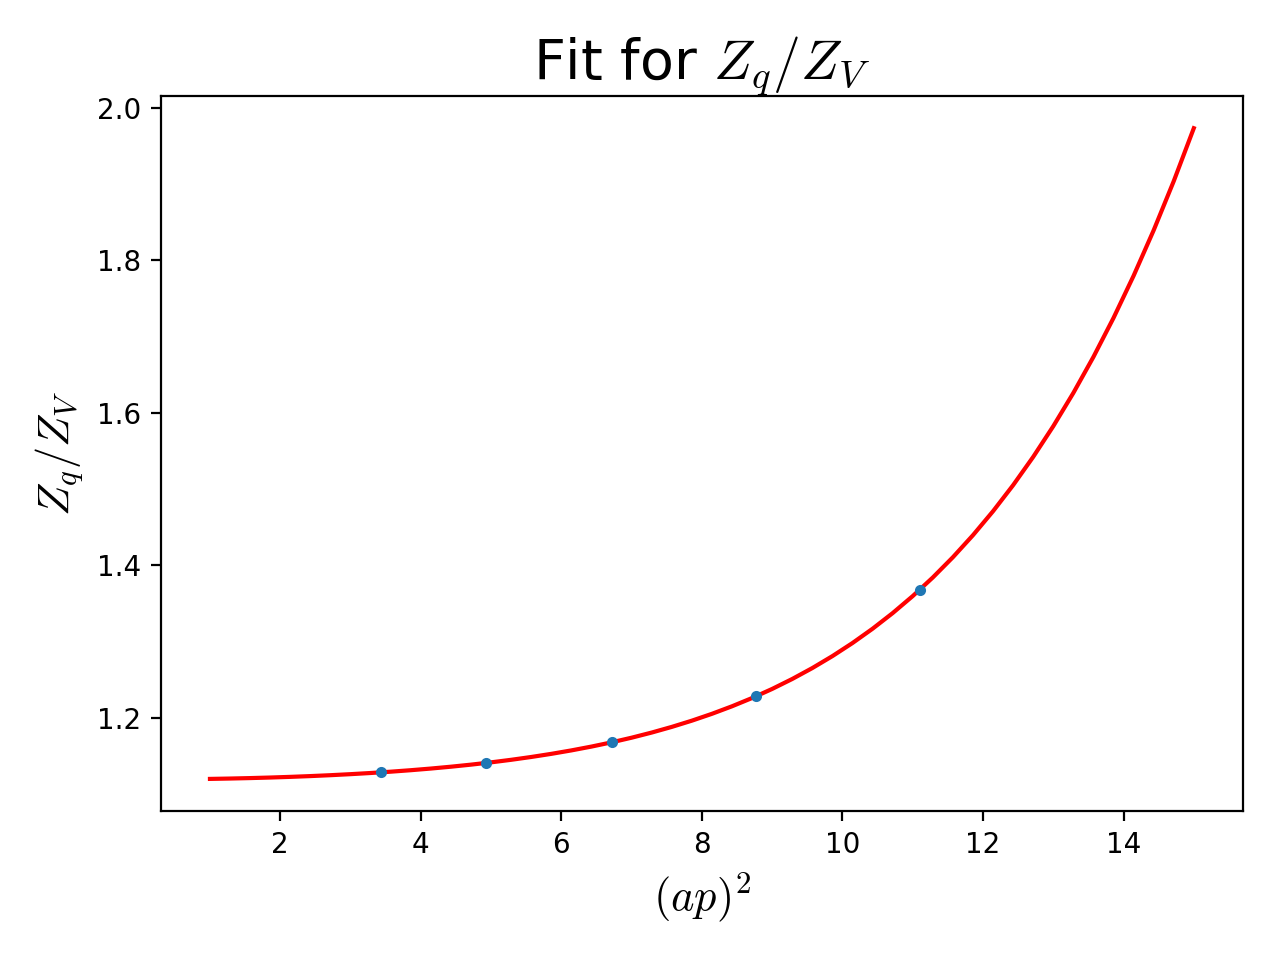

In [58]:
mom_subset = [3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(Zq_extrap[0][mom_subset] / ZV_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_q / Z_V$', x_range = [1, 15], x_label = '$(ap)^2$')
# fit_and_plot(Zq_extrap[0][mom_subset] / ZV_extrap[0][mom_subset], scales[mom_subset], pwr, '$Z_q / Z_V$', x_range = [1, 5])

In [59]:
# x_fit_b = np.linspace(2, 5)
# fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
# for ii in range(pwr + 1):
#     ci_mu_b = np.mean(fit_coeffs_b[ii])
#     moment = x_fit_b ** (2 * ii)
#     fx_fit_b += ci_mu_b * moment

In [60]:
# Z11_fit_mean = np.zeros((len(mom_subset)), dtype = np.float64)
# Z11_fit_std = np.zeros((len(mom_subset)), dtype = np.float64)
# for i in range(len(mom_subset)):
#     fit_data_boots = Superboot(2)
#     fit_data_boots.boots = Z_chiral_boots[0, 0, mom_subset[i]]
#     Z11_fit_mean[i] = fit_data_boots.compute_mean()
#     Z11_fit_std[i] = fit_data_boots.compute_std()
# plt.figure()
# plt.errorbar(scales[mom_subset], Z11_fit_mean, Z11_fit_std, fmt = '.')
# plt.plot(x_fit_b, fx_fit_b, c = 'r')
# plt.title('Fit for $Z_{11} / Z_V^2$')
# plt.xlabel('μ (GeV)')
# plt.ylabel('$Z_{11} / Z_V^2$')
# plt.show()

In [61]:
# test of fitting code

# fake_signal = scales ** 2
# variation = np.random.uniform(low = 0.9, high = 1.0, size = (2, 50))
# fake_data = np.einsum('i,jk->ijk', fake_signal, variation)
# fit_coeffs, chi2, y_extrap = corr_superboot_fit_apsq(scales, fake_data)
# c0_mu = np.mean(fit_coeffs[0])
# c1_mu = np.mean(fit_coeffs[1])
# x_fit = np.linspace(1, 5)
# fx_fit = c0_mu * np.ones(x_fit.shape) + c1_mu * (x_fit ** 2)
# fake_mean = np.zeros((len(scales)), dtype = np.float64)
# fake_std = np.zeros((len(scales)), dtype = np.float64)
# for i in range(len(scales)):
#     fake_data_boots = Superboot(2)
#     fake_data_boots.boots = fake_data[i]
#     fake_mean[i] = fake_data_boots.compute_mean()
#     fake_std[i] = fake_data_boots.compute_std()
# plt.figure()
# plt.errorbar(scales, fake_mean, fake_std, fmt = '.')
# plt.plot(x_fit, fx_fit, c = 'r')
# plt.title('Testing fitting code')
# plt.show()

In [62]:
# some fits of Z_ij (NOT divided by Z_V^2), just here for context
Z22_boots = np.zeros((8, 2, 50))
Z22_boots[:, 0, :] = Z_list[0][0, 0]
Z22_boots[:, 1, :] = Z_list[1][0, 0]
mom_subset = [3, 4, 5, 6, 7]
pwr = 3
fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(scales[mom_subset], Z22_boots[mom_subset], order = pwr)
# fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(np.array([square(mom_list_24I[idx]) for idx in mom_subset]), Z22_boots[mom_subset], order = pwr)
x_fit_b = np.linspace(2, 5)
# x_fit_b = np.linspace(2, 15)
fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
for ii in range(pwr + 1):
    ci_mu_b = np.mean(fit_coeffs_b[ii])
    moment = x_fit_b ** (2 * ii)
    fx_fit_b += ci_mu_b * moment

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[ 5.34527483e+00 -5.63105696e-01  4.62490172e-04  1.79092645e-03]
Chi^2: 697906.6474648954
Extrapolated Z_ij / Z_V^2 = 1.620370652243524
[ 5.34616099e+00 -5.63295644e-01  4.60900674e-04  1.79143479e-03]
Chi^2: 698937.1941686322
Extrapolated Z_ij / Z_V^2 = 1.619789103569175
[ 5.34940943e+00 -5.63760215e-01  4.60199142e-04  1.79277242e-03]
Chi^2: 699779.3340614021
Extrapolated Z_ij / Z_V^2 = 1.619774717320431
[ 5.34669294e+00 -5.63356234e-01  4.61041220e-04  1.79160138e-03]
Chi^2: 698769.2297698038
Extrapolated Z_ij / Z_V^2 = 1.6199085737586891
[ 5.34645464e+00 -5.63389935e-01  4.61881571e-04  1.79176585e-03]
Chi^2: 698824.3305937954
Extrapolated Z_ij / Z_V^2 = 1.6195549382983017
[ 5.34457085e+00 -5.63086314e-01  4.62896474e-04  1.79090885e-03]
Chi^2: 697929.6695559347
Extrapolated Z_ij / Z_V^2 = 1.619861187248011
[ 5.34668328e+00 -5.63318483e-01  4.61831067e-04  1.79157693e-03]
Chi^2: 698863.1468218942
Extrapolated Z_ij / Z_V^2 = 1.62028483082

[ 5.34354101e+00 -5.62989064e-01  4.59296368e-04  1.79022858e-03]
Chi^2: 697185.617179501
Extrapolated Z_ij / Z_V^2 = 1.618919070072104
[ 5.34429271e+00 -5.63057169e-01  4.59425263e-04  1.79043296e-03]
Chi^2: 697240.3094901089
Extrapolated Z_ij / Z_V^2 = 1.6192172698795435
[ 5.34457841e+00 -5.63053180e-01  4.61105620e-04  1.79050644e-03]
Chi^2: 696676.196045154
Extrapolated Z_ij / Z_V^2 = 1.6197285352294681
[ 5.34310720e+00 -5.62834588e-01  4.61300141e-04  1.78986571e-03]
Chi^2: 696249.5629558836
Extrapolated Z_ij / Z_V^2 = 1.6197733269312973
[ 5.34388274e+00 -5.63021431e-01  4.59388188e-04  1.79033797e-03]
Chi^2: 697327.6508059953
Extrapolated Z_ij / Z_V^2 = 1.619056684194617
[ 5.34407540e+00 -5.63031643e-01  4.58968545e-04  1.79031541e-03]
Chi^2: 697153.3426477825
Extrapolated Z_ij / Z_V^2 = 1.6191069916444367
[ 5.34379727e+00 -5.63038100e-01  4.59282135e-04  1.79037298e-03]
Chi^2: 697309.5550770157
Extrapolated Z_ij / Z_V^2 = 1.6188381252079052
[ 5.34356016e+00 -5.62981104e-01  4.60

In [63]:
np.mean(chi2_b)

697834.7959464092

<IPython.core.display.Javascript object>


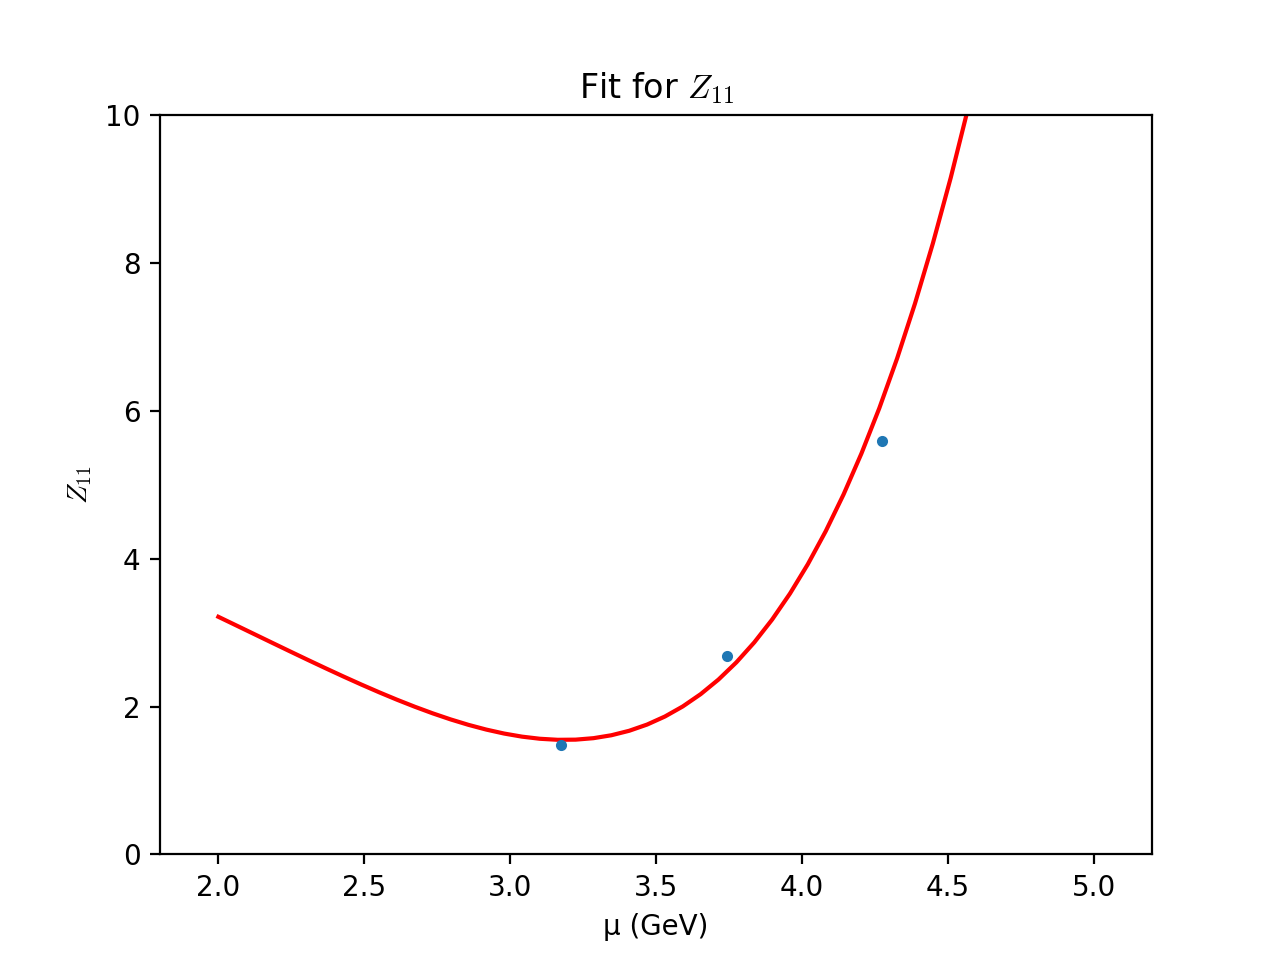

In [64]:
Zij_fit_mean = np.zeros((len(mom_subset)), dtype = np.float64)
Zij_fit_std = np.zeros((len(mom_subset)), dtype = np.float64)
for i in range(len(mom_subset)):
    fit_data_boots = Superboot(2)
    fit_data_boots.boots = Z22_boots[mom_subset[i]]
    Zij_fit_mean[i] = fit_data_boots.compute_mean()
    Zij_fit_std[i] = fit_data_boots.compute_std()
plt.figure()
plt.errorbar(scales[mom_subset], Zij_fit_mean, Zij_fit_std, fmt = '.')
# plt.errorbar(np.array([square(mom_list_24I[idx]) for idx in mom_subset]), Zij_fit_mean, Zij_fit_std, fmt = '.')
plt.plot(x_fit_b, fx_fit_b, c = 'r')
plt.xlim((1.8, 5.2))
# plt.xlim((1.8, 15))
plt.ylim((0, 10))
plt.title('Fit for $Z_{11}$')
plt.xlabel('μ (GeV)')
plt.ylabel('$Z_{11}$')
plt.show()

In [65]:
Z_norm_interp_mu = np.zeros((5, 5), dtype = np.float64)
Z_norm_interp_sigma = np.zeros((5, 5), dtype = np.float64)
ff = h5py.File(chi_extrap_lin_paths[0], 'r')
for i, j in itertools.product(range(5), repeat = 2):
    key = 'O' + str(i + 1) + str(j + 1) + '/interpZijZVm2'
    tmp = Superboot(2)
    try:
        # Z_norm_interp[i, j] = ff[key]
        tmp.boots = ff[key][()]
        Z_norm_interp_mu[j, i] = tmp.compute_mean()
        Z_norm_interp_sigma[j, i] = tmp.compute_std()
    except:
        print('no key here')

no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here


In [66]:
Z_norm_interp_mu

array([[ 1.02917193,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.1898464 ,  0.04625317,  0.        ,  0.        ],
       [ 0.        ,  0.32444356,  1.00099701,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.05203059, -0.29547177],
       [ 0.        ,  0.        ,  0.        , -0.04615061,  1.17230453]])

In [67]:
Z_norm_interp_sigma

array([[0.00111491, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00094671, 0.00017279, 0.        , 0.        ],
       [0.        , 0.00077945, 0.00104494, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00111497, 0.00082184],
       [0.        , 0.        , 0.        , 0.00017409, 0.00095076]])

## Axial / Vector renormalization

In [68]:
f2 = h5py.File('/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/ml0p01/AVcurrents.h5', 'r')
GammaA = f2['GammaA'][()]
qDotA = f2['qDotA'][()]
ZA2 = f2['ZA'][()]
f2.close()

In [69]:
qslashList = np.einsum('pm,mij->pij', np.array(mom_list_24I), gamma)
qsqList = np.array([square(q) for q in mom_list_24I])
qDotAred = np.einsum('pzaiaj,jk,pki->pz', qDotA, gamma5, qslashList) / 12

<IPython.core.display.Javascript object>


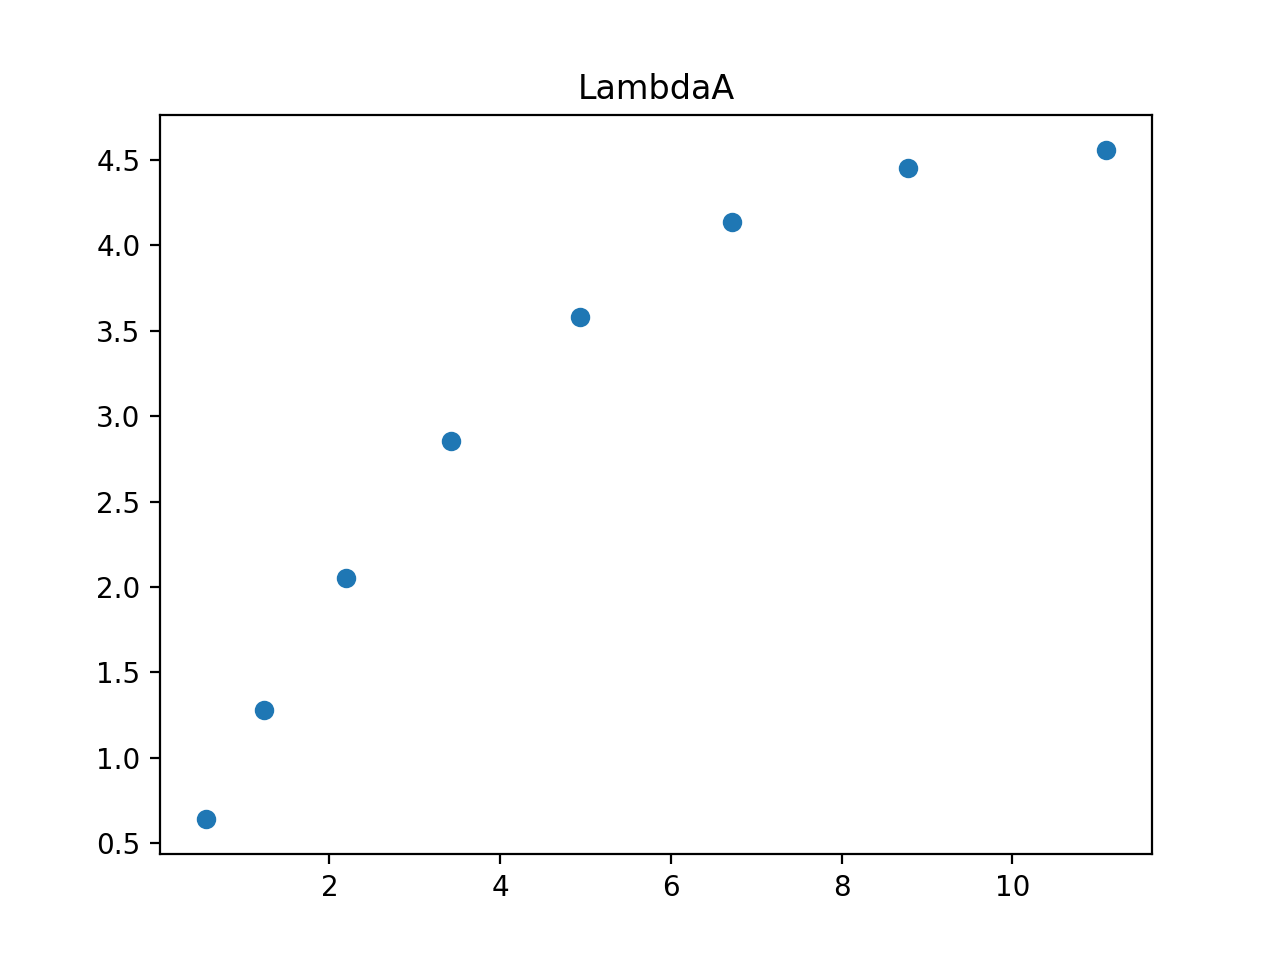

In [70]:
plt.figure()
plt.scatter([square(k) for k in mom_list_24I], np.abs(np.mean(qDotAred, axis = 1)))
plt.title('LambdaA')
# todo see what this looks like with qslashsquared dividing it
plt.show()

## Chiral extrapolation on ZA values

In [71]:
# mass_list = np.array([0.01, 0.005])
# cfgs = ['24I/ml_0p01', '24I/ml_0p005']

mass_list = np.array([0.008, 0.006, 0.004])
# mass_list = np.array([410.8, 359.7, 302.0])
cfgs = ['32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
fpaths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/'+cfg+'/twopt_out.h5' for cfg in cfgs]
fs = [h5py.File(fp, 'r') for fp in fpaths]
ZA_dat = np.array([F['ZA_ratio'][()] for F in fs])
[F.close() for F in fs]

[None, None, None]

In [72]:
ZA_ens = []
for ZA_b in ZA_dat:
    ZA_fits, ZA_stats, ZA_fit_boots, ZA_weights = fit_constant_allrange(ZA_b)
    Zratio_mu, Zratio_sigma = analyze_accepted_fits(ZA_fit_boots, ZA_weights)
    print('From function in code: ZA = ' + str(Zratio_mu) + ' \pm ' + str(Zratio_sigma))
    ZA_weights = ZA_weights / np.sum(ZA_weights)
    ZA_boot = np.einsum('z,zb->b', ZA_weights, ZA_fit_boots)
    ZA_boot_sp = spread_boots(ZA_boot, Zratio_sigma)    # bootstrapping doesn't include systematic error, so spread it
    print('By hand : ZA = ' + str(np.mean(ZA_boot)) + ' \pm ' + str(np.std(ZA_boot, ddof = 1)))
    print('By hand with spreading: ZA = ' + str(np.mean(ZA_boot_sp)) + ' \pm ' + str(np.std(ZA_boot_sp, ddof = 1)))
    ZA_ens.append(ZA_boot_sp)
ZA_ens = np.array(ZA_ens)    # now should have a list of bootstraps, (n_ens, n_boot)
ZA_ens_mu = np.mean(ZA_ens, axis = 1)
ZA_ens_std = np.std(ZA_ens, axis = 1, ddof = 1)

Accepted fits
fit index | fit range | p value | meff mean | meff sigma | weight 
399 range(7, 11) 0.41295577377734494 0.745291032395068 7.040858350374987e-05 83301405.34529246
400 range(7, 12) 0.5774940928272216 0.7452968695563398 6.543252948734774e-05 134883903.89468372
401 range(7, 13) 0.057337120841022736 0.7453787592401311 7.065406020352635e-05 11485810.140250511
411 range(7, 23) 0.01189038492585839 0.7452391696182632 4.861749011916875e-05 5030496.428371635
412 range(7, 24) 0.017914756115375265 0.7452400421847295 4.879789889738363e-05 7523304.751884457
413 range(7, 25) 0.023662916591708594 0.7452334466300857 5.0174782146066234e-05 9399338.32035679
414 range(7, 26) 0.02114466249519633 0.7452474939072031 4.574002323222799e-05 10106667.911790296
415 range(7, 27) 0.02657690308515867 0.7452536832741314 4.781493502638123e-05 11624578.986619346
416 range(7, 28) 0.03592179169278809 0.7452503632000677 4.7910609429512145e-05 15649288.599237043
417 range(7, 29) 0.04054655730914236 0.745260833

666 range(12, 28) 0.01395966468166941 0.7452324042795619 5.085122672941121e-05 5398487.721306833
667 range(12, 29) 0.015903445656736397 0.7452481453342518 4.65365640670242e-05 7343491.549402218
668 range(12, 30) 0.011508673131007752 0.7452220270327976 4.239228445758846e-05 6404004.288044633
669 range(12, 31) 0.01702530953363047 0.7452219761865309 4.347944549761984e-05 9005897.979192272
702 range(13, 17) 0.0869161625952556 0.7450809949311642 6.542336117734506e-05 20306488.920860104
703 range(13, 18) 0.1280009408510606 0.745053242862695 6.789313627667783e-05 27769075.401331663
704 range(13, 19) 0.16399356122802491 0.7450820434018514 6.664210120001757e-05 36925759.21776023
705 range(13, 20) 0.06268982807572322 0.7451471206988748 7.357438652223692e-05 11580939.150076423
706 range(13, 21) 0.07272743675221627 0.7451204231672167 6.568674853156652e-05 16855543.135290056
707 range(13, 22) 0.11227804429333202 0.7451223582073702 6.0076881412229504e-05 31108572.1952093
708 range(13, 23) 0.10213888

796 range(15, 20) 0.12894992834865188 0.7452317439126108 8.720457665909862e-05 16956747.33260258
797 range(15, 21) 0.11008104690899935 0.745180778047199 7.034646960907704e-05 22244770.90390948
798 range(15, 22) 0.17456464901801438 0.7451787144013177 6.352807044479006e-05 43253869.974396646
799 range(15, 23) 0.19112593488299354 0.7452085284506975 5.9416833830415096e-05 54137801.00955249
800 range(15, 24) 0.26535545943712885 0.7452125298472425 5.7797280407748035e-05 79435241.46239308
801 range(15, 25) 0.3323765846999319 0.7452022166857034 6.246121637844424e-05 85194105.2276648
802 range(15, 26) 0.2670956398597376 0.7452309965562902 5.274162102822968e-05 96019590.81331716
803 range(15, 27) 0.30466205692601533 0.7452431783407522 5.570894336947558e-05 98167679.98054177
804 range(15, 28) 0.3743803057606177 0.7452380816645305 5.612490113957493e-05 118850719.87721498
805 range(15, 29) 0.38806960195630247 0.7452568657127167 4.9435590776745846e-05 158792566.5048693
806 range(15, 30) 0.2889419299

890 range(17, 27) 0.3652845951831168 0.7452541932375444 6.974501281084165e-05 75093965.83398187
891 range(17, 28) 0.44526817984289946 0.7452468892875703 7.109969097977236e-05 88081810.72299488
892 range(17, 29) 0.4677726776609392 0.7452685774760505 6.294349030673554e-05 118068272.32594857
893 range(17, 30) 0.3348767133099992 0.745228331927312 5.280160208259751e-05 120113203.14628288
894 range(17, 31) 0.4110932772119976 0.7452278101070219 5.343054040513302e-05 143999585.2289533
895 range(17, 32) 0.22574877747028868 0.7452663415734011 5.5339241658962847e-05 73715531.31265567
896 range(17, 33) 0.14005559350331476 0.745243518440681 5.731469549880071e-05 42635217.15998925
897 range(17, 34) 0.11486979920534263 0.7452649858501315 5.150728628750927e-05 43298068.523908034
898 range(17, 35) 0.12489912084625454 0.7452556750134491 5.370690649712285e-05 43301117.60954141
899 range(17, 36) 0.15936180584118315 0.7452591829425765 5.050226568078323e-05 62483092.747551836
900 range(17, 37) 0.15274898506

988 range(19, 42) 0.01815665998439754 0.7452874944497144 4.776641476715741e-05 7957756.938141884
989 range(19, 43) 0.024433041852519512 0.7452845100176837 4.92159174678543e-05 10087100.966696344
990 range(19, 44) 0.03309246373547819 0.7452856378566612 4.99219016915474e-05 13278434.027745692
991 range(19, 45) 0.04125637332546939 0.7452814368435979 4.8328396049958795e-05 17663887.284696132
992 range(19, 46) 0.04223307699784022 0.7452897312734547 4.594323393446512e-05 20008272.820730984
993 range(19, 47) 0.04932223386999314 0.7452943041269587 4.7377016892730586e-05 21973908.643368654
994 range(19, 48) 0.06104200956593931 0.7452912960227787 4.988217211066439e-05 24532291.112914704
995 range(19, 49) 0.05887930274462989 0.7452841362609266 4.965782966666465e-05 23877408.498938773
996 range(19, 50) 0.07198409439355716 0.7452818381380726 4.949690065844277e-05 29381944.50149884
997 range(19, 51) 0.0867635800152455 0.7452790935992231 4.7555631462657074e-05 38364854.71383104
998 range(19, 52) 0.07

1083 range(21, 58) 0.14911117556418316 0.7452852075137764 4.5542336592446554e-05 71891836.28414126
1084 range(21, 59) 0.17708782129992057 0.7452849853906806 4.380214642718036e-05 92299194.20579073
1085 range(21, 60) 0.06214571435349753 0.74527307230603 4.4270529818145636e-05 31708941.55058908
1089 range(22, 26) 0.5650673047915278 0.7453331178653027 8.406276937845589e-05 79963683.70934574
1090 range(22, 27) 0.7090604250100488 0.7453482291627722 8.495071023315601e-05 98253768.88796929
1091 range(22, 28) 0.7546896389704401 0.7453194716252347 7.910275039379917e-05 120610528.19789165
1092 range(22, 29) 0.826664040583165 0.7453399589331205 6.208696544579558e-05 214451050.88925073
1093 range(22, 30) 0.44613378368366363 0.7452620265509452 4.760271299163102e-05 196880045.85026315
1094 range(22, 31) 0.5507257007728987 0.7452576132319904 4.63688106398372e-05 256143554.21998948
1095 range(22, 32) 0.3410515770652445 0.7453070515241786 4.839446201422383e-05 145622582.78113776
1096 range(22, 33) 0.17

1182 range(24, 46) 0.0302867292412115 0.7452937856946388 4.351595414453139e-05 15993936.01156915
1183 range(24, 47) 0.03671470880108651 0.7452990132210734 4.5400487457236264e-05 17812261.25398985
1184 range(24, 48) 0.046856092235492044 0.7452953434677586 4.842763732972056e-05 19979264.81168722
1185 range(24, 49) 0.045054893797788965 0.7452869264747648 4.775237760188955e-05 19758408.956940845
1186 range(24, 50) 0.056709264638834495 0.7452842043612435 4.794019821300985e-05 24674841.12685678
1187 range(24, 51) 0.07015850729730143 0.7452809813749112 4.5523082068050216e-05 33854548.41593551
1188 range(24, 52) 0.06356836647444326 0.7452720011844757 4.787427624081448e-05 27735538.901988182
1189 range(24, 53) 0.08117696565220082 0.745272006931562 4.8586508503579344e-05 34387565.552976295
1190 range(24, 54) 0.10192088747350778 0.7452717001532639 4.9709694217548676e-05 41245921.732261054
1191 range(24, 55) 0.10641697075376197 0.7452640774807594 4.5703556409334554e-05 50946094.92268577
1192 range

1277 range(27, 39) 0.10743178996896835 0.7452661226786094 5.498691277603634e-05 35531548.73066068
1278 range(27, 40) 0.010877731020137118 0.7453176228303634 5.477480133967167e-05 3625573.3287436096
1282 range(27, 44) 0.01325014814247304 0.7452820888042356 5.046002238256385e-05 5203863.020549065
1283 range(27, 45) 0.01815601301382874 0.7452767275728667 4.825499567255018e-05 7797150.613502777
1284 range(27, 46) 0.01907912550960636 0.7452877478713805 4.5348147677994284e-05 9277679.389348833
1285 range(27, 47) 0.02369294374639012 0.745293714908236 4.7548341678434426e-05 10479686.082140777
1286 range(27, 48) 0.03157134633611883 0.7452898900921503 5.071701872610093e-05 12273987.28478307
1287 range(27, 49) 0.03106598925394762 0.745280862798858 4.997545445702125e-05 12438605.19669444
1288 range(27, 50) 0.0405686253534601 0.7452780467596467 4.997550003426745e-05 16243364.716520522
1289 range(27, 51) 0.05195916323671196 0.7452747330892422 4.696454472764524e-05 23557104.86151915
1290 range(27, 52

1386 range(30, 55) 0.09470443370915313 0.7452696871762364 5.0312122515970556e-05 37413215.28314073
1387 range(30, 56) 0.05379733576850608 0.7452879075246787 5.0175380205212264e-05 21368765.06527137
1388 range(30, 57) 0.06666034538254496 0.7452912348225135 4.95662666933015e-05 27132832.94603382
1389 range(30, 58) 0.08424506439982551 0.745293293752367 4.872046089310238e-05 35491282.28598155
1390 range(30, 59) 0.1058890533674649 0.7452927428964928 4.6384607182848056e-05 49215658.43422481
1391 range(30, 60) 0.028328720613223057 0.7452775899290306 4.6831621144593205e-05 12916610.918954462
1395 range(31, 35) 0.024420508698845014 0.7453330861893112 7.460611533520933e-05 4387386.067707523
1396 range(31, 36) 0.051220798967248925 0.7453251248846844 6.76815602744833e-05 11181643.057211606
1397 range(31, 37) 0.0754181748331447 0.7453514835931407 7.259188458580743e-05 14311985.090328481
1398 range(31, 38) 0.11504600010557184 0.7453367639538788 6.642179488267432e-05 26076560.629674677
1399 range(31,

1496 range(34, 55) 0.23037799932693567 0.745250371641238 5.252021488800054e-05 83519524.61663388
1497 range(34, 56) 0.12520285274930457 0.7452737029264799 5.2568866157973296e-05 45306133.931346126
1498 range(34, 57) 0.1493769801784652 0.7452782750883769 5.1921515207366264e-05 55410103.29452445
1499 range(34, 58) 0.18207947739661956 0.7452814632267009 5.08793578840928e-05 70336014.30986047
1500 range(34, 59) 0.22211938477265003 0.7452812693012778 4.8132499356152205e-05 95875939.90342881
1501 range(34, 60) 0.06850649965887727 0.7452637431480462 4.841418177944695e-05 29227157.83072608
1505 range(35, 39) 0.39490153985357135 0.7452827467652117 8.787776834501325e-05 51136475.09527038
1506 range(35, 40) 0.040558940449200026 0.7454002590941944 8.212713729506927e-05 6013304.987593515
1507 range(35, 41) 0.01606921209032835 0.7453468902726144 7.403381289740358e-05 2931800.055789067
1508 range(35, 42) 0.011059290189540289 0.7453144811663179 6.617403628819651e-05 2525526.9272145224
1509 range(35, 4

1608 range(39, 52) 0.07527759761913588 0.7452640884026153 5.6137294709353135e-05 23887064.979515083
1609 range(39, 53) 0.1059055875875611 0.7452647901994625 5.850239304039517e-05 30943655.089083318
1610 range(39, 54) 0.14358566312212231 0.7452645623508536 5.9873687067344676e-05 40053370.866873704
1611 range(39, 55) 0.15716070161743279 0.7452493761268647 5.184404609692651e-05 58471762.21944517
1612 range(39, 56) 0.07741839774302318 0.7452808761209992 5.158693444914373e-05 29091407.74610281
1613 range(39, 57) 0.09830293300670648 0.7452865678972583 5.096949044166922e-05 37839543.8281074
1614 range(39, 58) 0.12726749231118326 0.7452900999157541 4.995470026485797e-05 50999365.372599356
1615 range(39, 59) 0.16320932526769863 0.7452894164211468 4.7494366030607465e-05 72353705.76604058
1616 range(39, 60) 0.04013682703213859 0.745266734098213 4.756649682334749e-05 17739472.49958477
1620 range(40, 44) 0.5458372237230975 0.7451071386819741 9.50039448459768e-05 60475556.243610784
1621 range(40, 45

1716 range(45, 55) 0.7846992266016325 0.745216064198513 6.554659830130355e-05 182642948.1993462
1717 range(45, 56) 0.4149498372963222 0.7452691962603061 6.229476717046294e-05 106928251.3590691
1718 range(45, 57) 0.47746687286104306 0.7452786508551134 6.25823417967568e-05 121910082.40289274
1719 range(45, 58) 0.5552243461041877 0.745284603425178 6.01629990846457e-05 153394414.6423839
1720 range(45, 59) 0.6362357522044275 0.7452840389475739 5.6256300464848746e-05 201036878.64036793
1721 range(45, 60) 0.21325109406479348 0.7452527089226467 5.463274063341646e-05 71447213.12748407
1725 range(46, 50) 0.5940045302624111 0.745210785990905 0.00011419632367042517 45549699.00487533
1726 range(46, 51) 0.751745945450695 0.7452040796062229 9.682760483914203e-05 80181230.36900844
1727 range(46, 52) 0.7549782294376065 0.7451662130403528 9.272655705438559e-05 87806397.44413054
1728 range(46, 53) 0.8222255024022265 0.745185868514869 8.523433510100767e-05 113177940.70043045
1729 range(46, 54) 0.885288454

394 range(6, 59) 0.021222151097372972 0.7451175918843773 4.306518886048002e-05 11442915.476657487
399 range(7, 11) 0.3179412362470884 0.7453502727784047 0.0001062894474681318 28142751.74663606
400 range(7, 12) 0.33103120854171125 0.7452967270985608 8.315745131926385e-05 47870349.592409596
401 range(7, 13) 0.12462520147847517 0.7452048184407208 7.701276355074817e-05 21012632.1306587
402 range(7, 14) 0.07741588165776826 0.7451215145867817 7.27721019931884e-05 14618412.921823874
403 range(7, 15) 0.11177284431711025 0.745139154609873 6.460816400150936e-05 26776974.39697656
404 range(7, 16) 0.08297611189610338 0.7450908820376317 6.42326264215206e-05 20111372.96565596
405 range(7, 17) 0.0996652901774642 0.7451100756031505 6.650747663781298e-05 22532168.712967515
406 range(7, 18) 0.12605823512619543 0.7451243710997245 6.391904914776067e-05 30853938.592519403
407 range(7, 19) 0.14272658710271255 0.7451436021866862 6.090435516296173e-05 38477618.31417013
408 range(7, 20) 0.192539353413281 0.745

488 range(8, 48) 0.19838583297193643 0.7450986121499118 4.310820672033118e-05 106755618.67005606
489 range(8, 49) 0.22718640998304385 0.74510033229792 4.261048986042159e-05 125126499.45109037
490 range(8, 50) 0.16183777600899885 0.7451095707075708 4.3584628377203856e-05 85194823.39928783
491 range(8, 51) 0.18943810160844152 0.7451093827494663 4.464865860752001e-05 95027762.00914092
492 range(8, 52) 0.21519755279744004 0.7451112009358425 4.3171338169699136e-05 115463922.50677656
493 range(8, 53) 0.24723197704429448 0.7451113449678689 4.50824829483842e-05 121643522.45714127
494 range(8, 54) 0.27481394766417777 0.7451095855161224 4.390790194712833e-05 142545463.13589117
495 range(8, 55) 0.30533804971173795 0.7451116491600331 4.384634886767076e-05 158823242.12474537
496 range(8, 56) 0.3324596833879412 0.7451139751730923 4.507595287282897e-05 163624809.76281133
497 range(8, 57) 0.31485901320912696 0.745120397659718 4.5227714523968055e-05 153924178.88322237
498 range(8, 58) 0.289975026587475

587 range(10, 46) 0.10406401814095728 0.7451013931060468 4.770849919186348e-05 45720301.04779457
588 range(10, 47) 0.1260530133962358 0.745100824802134 4.7375303011724354e-05 56162861.99513201
589 range(10, 48) 0.14274164765462657 0.74509744037378 4.481711100146618e-05 71066183.05177085
590 range(10, 49) 0.16674524197650248 0.7450992666268911 4.4375115161111314e-05 84678754.98330462
591 range(10, 50) 0.11455543630920055 0.7451089243561423 4.5406104874155637e-05 55563194.65996927
592 range(10, 51) 0.1370039266594343 0.7451087389683104 4.6369820418474445e-05 63718007.50067108
593 range(10, 52) 0.15846982357009898 0.7451106578304821 4.483967830319642e-05 78817308.11698699
594 range(10, 53) 0.18571203242963366 0.7451108055912633 4.673588134059497e-05 85023537.23507577
595 range(10, 54) 0.20984634465572555 0.7451089851948423 4.559465254508681e-05 100942391.00046901
596 range(10, 55) 0.23691467607401273 0.7451111428583819 4.518613693158937e-05 116033004.15867887
597 range(10, 56) 0.261491328

683 range(12, 45) 0.09733303787093064 0.7450954169784113 4.924136098377122e-05 40142108.696591675
684 range(12, 46) 0.11623384708136618 0.7450930520066644 4.692583789187748e-05 52784758.663774334
685 range(12, 47) 0.14087845232519566 0.7450926520672624 4.654715988963977e-05 65021681.6222656
686 range(12, 48) 0.16040839018092387 0.745089335774761 4.425600058260627e-05 81899783.1909238
687 range(12, 49) 0.18638756176114216 0.7450914301235249 4.410182638911048e-05 95830504.95582633
688 range(12, 50) 0.12570066955392914 0.7451016337247492 4.514392600092629e-05 61679229.556078374
689 range(12, 51) 0.15033296810880853 0.7451015836917125 4.613368913058118e-05 70634660.55097887
690 range(12, 52) 0.17317436749201254 0.7451037145297481 4.4545553158863435e-05 87271993.71809891
691 range(12, 53) 0.2026721391111078 0.7451040044305265 4.6332424565568753e-05 94411304.1140915
692 range(12, 54) 0.22935340204818527 0.745102207137017 4.518906454763007e-05 112315186.91163349
693 range(12, 55) 0.2576459091

780 range(14, 49) 0.22836168820832659 0.7451102306266257 4.627811181378846e-05 106628176.65870489
781 range(14, 50) 0.16278921193359253 0.7451207688441981 4.699095706356489e-05 73721988.34355745
782 range(14, 51) 0.19267642135307272 0.7451203025567864 4.7969154210323447e-05 83734503.4476937
783 range(14, 52) 0.221858262219662 0.7451221858670429 4.659063372283089e-05 102206465.88737112
784 range(14, 53) 0.2570789432074692 0.7451221431534159 4.850909897940831e-05 109249658.96651968
785 range(14, 54) 0.2861664397521081 0.7451199361207452 4.7122543977744415e-05 128872793.79679078
786 range(14, 55) 0.3209923325010905 0.7451219979858098 4.628061354192298e-05 149863697.35885248
787 range(14, 56) 0.35239951102222516 0.7451244497747292 4.7670272293542046e-05 155074372.27528313
788 range(14, 57) 0.3378379120927607 0.7451314870035737 4.786825284230627e-05 147439290.3020908
789 range(14, 58) 0.3149539816627271 0.7451381473215793 4.565936246735664e-05 151073195.8934222
790 range(14, 59) 0.305426176

873 range(16, 53) 0.2809417989713041 0.7451306452373254 5.0064779083644095e-05 112086098.05957209
874 range(16, 54) 0.3109979961460181 0.7451281304557245 4.862699327387948e-05 131523318.13592952
875 range(16, 55) 0.34909236209038697 0.7451300820364355 4.798144374447558e-05 151632998.6901825
876 range(16, 56) 0.38361108071801653 0.7451325413981776 4.967042722459967e-05 155487454.05021602
877 range(16, 57) 0.37157692954650806 0.7451398290804364 4.949307508777188e-05 151691017.86500207
878 range(16, 58) 0.35034199803773103 0.7451467634671884 4.715048717579912e-05 157586798.90827706
879 range(16, 59) 0.337014580523368 0.7451415653726798 4.740865183536722e-05 149945514.82525918
880 range(16, 60) 0.05956027652661561 0.7451195513259509 4.654831572274413e-05 27488355.749089025
884 range(17, 21) 0.7421271200259154 0.7451993650220909 9.86815195788094e-05 76209067.14889473
885 range(17, 22) 0.8648357092230001 0.7451925992991967 9.269459835714795e-05 100652544.74655418
886 range(17, 23) 0.34969990

969 range(19, 23) 0.48070959202026753 0.7449245449417468 0.00011259112574023766 37920535.80881839
970 range(19, 24) 0.5387891256260249 0.7449861838720808 9.747160829959105e-05 56710380.0358545
971 range(19, 25) 0.5882518434914823 0.7450282495228459 9.291542632444115e-05 68137728.12244794
972 range(19, 26) 0.6026086383843474 0.744989916439242 7.873573697375978e-05 97205661.31452487
973 range(19, 27) 0.7119716215751407 0.7449974520346789 6.236813221720967e-05 183036291.19302952
974 range(19, 28) 0.2830170376583525 0.7450765961292456 6.09186575906109e-05 76262656.92760967
975 range(19, 29) 0.032551317161327205 0.7451725726515681 6.480482883385726e-05 7750930.288274821
976 range(19, 30) 0.04261662465187035 0.745148165042168 7.127602876669924e-05 8388649.727868963
977 range(19, 31) 0.06413584246246644 0.7451451811534262 6.368162554619995e-05 15815121.12202167
978 range(19, 32) 0.0923412681430752 0.7451476362310681 6.290762358735059e-05 23334004.406333953
979 range(19, 33) 0.1206743657956504

1060 range(21, 35) 0.034073550226375406 0.7450879663204936 5.727200665279125e-05 10388015.444896724
1061 range(21, 36) 0.04981927594324224 0.7450870324590775 5.695482840020735e-05 15358058.44428154
1062 range(21, 37) 0.06860136846134682 0.7450922824343543 5.7374212589176673e-05 20840076.19836378
1063 range(21, 38) 0.09040121717927657 0.7450852472434413 5.710384991881586e-05 27723209.032630704
1064 range(21, 39) 0.09340530002718639 0.7450703394175726 5.6045006415230105e-05 29737035.63987945
1065 range(21, 40) 0.049712481443653554 0.7451025844744025 5.14287120264042e-05 18795511.35783702
1066 range(21, 41) 0.05877287460402886 0.7450932722851372 5.0799053698563295e-05 22775382.96903114
1067 range(21, 42) 0.07169714276312635 0.7450875873575155 5.184201871900296e-05 26677064.550701834
1068 range(21, 43) 0.07735919465365808 0.7450980615973894 5.022091884389346e-05 30672037.834744796
1069 range(21, 44) 0.05432185499270496 0.7451120466091168 5.218261507437667e-05 19949081.880916942
1070 range(

1154 range(23, 54) 0.25901379983401934 0.7451242513639484 4.818942928526222e-05 111537097.13929917
1155 range(23, 55) 0.29758421884102726 0.7451267160111844 4.7642890398382394e-05 131103321.20402467
1156 range(23, 56) 0.33313315357140927 0.7451297140492091 4.952120514662124e-05 135842431.25403517
1157 range(23, 57) 0.32070987285574737 0.7451384023577874 4.9222891104005917e-05 132366502.24030572
1158 range(23, 58) 0.2997533229365033 0.7451465730587947 4.657537333830823e-05 138181949.85040843
1159 range(23, 59) 0.28744930329484186 0.74514050358262 4.6950260457371026e-05 130402299.15987404
1160 range(23, 60) 0.040082856443141655 0.7451149216579148 4.5999710353689944e-05 18942987.345964067
1164 range(24, 28) 0.1289744147237458 0.7451616748456007 7.359296320090725e-05 23813925.22909875
1165 range(24, 29) 0.021730243656191802 0.745306717224409 7.889231624559264e-05 3491364.4225678504
1166 range(24, 30) 0.02143627621785715 0.7452378886432999 8.670802516705293e-05 2851220.169375835
1167 range(

1250 range(26, 45) 0.05799234671969963 0.7451267953899661 5.65922842695742e-05 18107405.83117242
1251 range(26, 46) 0.07341854707808453 0.7451217043474035 5.176795782788082e-05 27395783.13684511
1252 range(26, 47) 0.09630071820079204 0.7451199544074723 5.1733691125876426e-05 35981775.90465788
1253 range(26, 48) 0.1130285489622176 0.745113671703484 4.8977081840845545e-05 47119680.98921557
1254 range(26, 49) 0.14171834060383726 0.7451160275469145 4.856510357325745e-05 60086570.91409415
1255 range(26, 50) 0.09327802038707249 0.7451308895645359 4.934943627760965e-05 38301424.67813548
1256 range(26, 51) 0.11842443473939772 0.7451299302742228 5.081569558659798e-05 45861216.54393191
1257 range(26, 52) 0.14543290450999727 0.7451322741717373 4.900667757383778e-05 60555299.577836454
1258 range(26, 53) 0.1786284912224487 0.7451319419670378 5.1726110308892824e-05 66762268.75691274
1259 range(26, 54) 0.20650189089982737 0.7451286828735578 4.951200841056216e-05 84237010.52733442
1260 range(26, 55) 0

1347 range(29, 46) 0.5219963520370431 0.7450716473571716 5.640698676139924e-05 164059607.02282658
1348 range(29, 47) 0.5928494017051187 0.7450718782090471 5.571154729205982e-05 191009050.2280363
1349 range(29, 48) 0.6439911540731892 0.7450668084295842 5.289852258151206e-05 230140375.07530463
1350 range(29, 49) 0.6921821574620846 0.7450714810982432 5.220944251272255e-05 253934838.8460877
1351 range(29, 50) 0.4985718295577397 0.7450900572812884 5.3237610525004e-05 175910039.780257
1352 range(29, 51) 0.5620026305965762 0.7450903649445066 5.478056105493705e-05 187277410.86452472
1353 range(29, 52) 0.6096437062138198 0.7450943649480471 5.307842054916547e-05 216391457.6494814
1354 range(29, 53) 0.666883037689219 0.7450951269578131 5.608381058051589e-05 212018932.48852745
1355 range(29, 54) 0.7117287984619756 0.7450923697615675 5.3373751072247106e-05 249838340.94325802
1356 range(29, 55) 0.7494692753671437 0.7450967611319155 5.1768816843493835e-05 279651629.74784356
1357 range(29, 56) 0.77776

1447 range(32, 59) 0.5383463187820794 0.7451194085452567 5.02890223731036e-05 212870441.9390959
1448 range(32, 60) 0.10046620991380151 0.7450870532706045 4.8279735890492636e-05 43101287.907019064
1452 range(33, 37) 0.44757414849322985 0.7449449996370952 9.338923554347314e-05 51318192.70954782
1453 range(33, 38) 0.5976171001897996 0.7449636084362996 7.795881179210073e-05 98331483.99079879
1454 range(33, 39) 0.7040587409667571 0.7449460599750227 7.5813231775259e-05 122495144.48553061
1455 range(33, 40) 0.16223968667270156 0.7450442428216981 6.277978456628866e-05 41163989.31659874
1456 range(33, 41) 0.22290070261074715 0.7450317676540998 6.423648688582674e-05 54019166.01951066
1457 range(33, 42) 0.29433941266609037 0.7450243964883669 6.658894074985237e-05 66381063.48888102
1458 range(33, 43) 0.2711437745957433 0.7450506968253796 6.066721976613506e-05 73670132.69930534
1459 range(33, 44) 0.15623181199480587 0.7450794522128984 6.233613276528167e-05 40205897.2202853
1460 range(33, 45) 0.2033

1546 range(36, 56) 0.7494299921146998 0.7451428984023748 5.3853850711574564e-05 258402996.37979552
1547 range(36, 57) 0.7319318618687798 0.7451561800500152 5.434685476849215e-05 247811708.98560005
1548 range(36, 58) 0.7037501012112792 0.745168361166161 5.058193219972061e-05 275060127.5765484
1549 range(36, 59) 0.6651260423247509 0.7451581812550344 5.106874142172652e-05 255031392.81429395
1550 range(36, 60) 0.10037555636490567 0.7451178275066538 4.850272504579609e-05 42667351.60412911
1554 range(37, 41) 0.12810620554092733 0.7450958392908582 8.14161623092437e-05 19326308.73808273
1555 range(37, 42) 0.19418056764692057 0.7450766133451827 7.69916654680032e-05 32758072.346859127
1556 range(37, 43) 0.22402899653354832 0.7451094412126942 6.993663617606338e-05 45803087.52319074
1557 range(37, 44) 0.15006160602656793 0.7451475945522197 6.943717065887713e-05 31123294.1482478
1558 range(37, 45) 0.19498561510341497 0.7451330585120125 7.136001697771351e-05 38290645.125270605
1559 range(37, 46) 0.2

1646 range(41, 51) 0.5384675902613458 0.7451637802513548 5.864227677765797e-05 156580588.85240847
1647 range(41, 52) 0.630325459184142 0.7451675748346369 5.6629032480214234e-05 196556117.6931517
1648 range(41, 53) 0.7119059609679685 0.7451641076322724 5.90059272426638e-05 204470825.59515744
1649 range(41, 54) 0.7533906046883336 0.7451536073971203 5.3092893433234695e-05 267268275.82754192
1650 range(41, 55) 0.8148784712026118 0.745157217938686 5.144083003798503e-05 307947660.2665661
1651 range(41, 56) 0.8597781350229895 0.7451627764351274 5.495157444822621e-05 284725337.2906529
1652 range(41, 57) 0.8507650156980611 0.7451808349704977 5.3374658659963614e-05 298634103.338847
1653 range(41, 58) 0.833807748686402 0.7451969761618129 4.843421475579912e-05 355435989.9995508
1654 range(41, 59) 0.7759639172605527 0.7451811586951778 4.875617060233511e-05 326424201.7713406
1655 range(41, 60) 0.09506159948246304 0.7451226762396194 4.7554689182628195e-05 42035713.405371614
1659 range(42, 46) 0.33618

1752 range(48, 52) 0.5508276607454938 0.7452629454746785 0.00010627881726472818 48766581.80028537
1753 range(48, 53) 0.6715523969949084 0.7452372993801162 9.37722058531149e-05 76371556.00151776
1754 range(48, 54) 0.6933001156019839 0.745203862597374 7.614604149046643e-05 119571206.21245684
1755 range(48, 55) 0.8028984372116597 0.7452009734322094 7.291865709703036e-05 151002204.89859417
1756 range(48, 56) 0.8785116255600005 0.7452058757699319 7.723596047857295e-05 147268007.0730606
1757 range(48, 57) 0.8891771025928145 0.7452309217675465 7.197882144951265e-05 171624311.38322768
1758 range(48, 58) 0.8907189602241535 0.7452524018273724 6.335260228340972e-05 221927836.55724674
1759 range(48, 59) 0.763561383663703 0.7452229899843202 6.103196880528747e-05 204988357.9013391
1760 range(48, 60) 0.03072603750385027 0.7451274347134706 5.6653106576871556e-05 9573243.322211191
1764 range(49, 53) 0.5188003412429116 0.745254388303635 0.00010852521185663222 44049295.65216649
1765 range(49, 54) 0.55321

441 range(7, 53) 0.07579515991330205 0.7450315849210427 3.681638137144558e-05 55918984.172079705
442 range(7, 54) 0.022573415517924352 0.7450555823215863 3.6735193735799315e-05 16727560.399983559
443 range(7, 55) 0.02805903705003659 0.7450542232761169 3.481590514709366e-05 23148208.290695973
444 range(7, 56) 0.03138359279541601 0.7450485632242695 3.650687472053351e-05 23547963.241770383
445 range(7, 57) 0.037872815859479825 0.745050705874406 3.638442534108491e-05 28608596.75237487
446 range(7, 58) 0.02814910440529009 0.7450609150905276 3.803252845708469e-05 19460508.497325353
447 range(7, 59) 0.013167618883107225 0.7450456783159052 3.6466753485617615e-05 9901774.818383802
452 range(8, 12) 0.7843752729483598 0.7449976266859534 0.00012416436106357136 50877993.816994056
453 range(8, 13) 0.8990065916060808 0.7449987003578764 0.00010696511949920184 78573937.06348906
454 range(8, 14) 0.8595203331237782 0.7449468331722237 9.373327994521968e-05 97829205.48564246
455 range(8, 15) 0.832819843065

534 range(9, 43) 0.05655969107787066 0.7450440728303847 4.177890842604855e-05 32403569.307861067
535 range(9, 44) 0.06883522864339037 0.7450482926102828 4.306540487478998e-05 37115361.100307554
536 range(9, 45) 0.057658357595624654 0.7450345267964019 4.003816370041081e-05 35967807.524499394
537 range(9, 46) 0.07188259210808705 0.7450341245239112 4.06957792041197e-05 43403524.080725186
538 range(9, 47) 0.08630054744442041 0.745031149229652 3.9868400766785526e-05 54294510.26634297
539 range(9, 48) 0.08447850600424198 0.7450408670824372 3.998854225061902e-05 52829327.17754257
540 range(9, 49) 0.09268661167622687 0.7450482590952389 3.7512685042261194e-05 65865911.24454779
541 range(9, 50) 0.08265316097851665 0.7450396598958331 3.829788024914375e-05 56352085.55361222
542 range(9, 51) 0.07505077234366511 0.7450278788832169 3.6170503032907274e-05 57364877.247831754
543 range(9, 52) 0.08846286753322574 0.7450309240816101 3.814413602657119e-05 60800261.61948576
544 range(9, 53) 0.09638838516737

637 range(11, 47) 0.06288759079417941 0.745029234161036 3.850326006619795e-05 42419930.42751121
638 range(11, 48) 0.06159858486489258 0.7450395378262332 3.826029039948968e-05 42079852.70219774
639 range(11, 49) 0.06827876343547487 0.7450473636373105 3.6772156505289264e-05 50494891.98530338
640 range(11, 50) 0.060706798260277355 0.7450383297692065 3.724109622540608e-05 43771599.37519507
641 range(11, 51) 0.05512577691919672 0.7450260229975086 3.5150644755119595e-05 44615743.246084
642 range(11, 52) 0.06595068546286716 0.745029264553541 3.726909782438749e-05 47481185.52365036
643 range(11, 53) 0.07267953632433238 0.745023795637226 3.748168353735918e-05 51733751.05202648
644 range(11, 54) 0.019881268182123758 0.7450499914323104 3.7631594584697524e-05 14039086.212551776
645 range(11, 55) 0.025087599652572103 0.745048613716562 3.53160181594613e-05 20114796.707134303
646 range(11, 56) 0.02845984287348368 0.7450426805251333 3.696770497470219e-05 20825120.29931791
647 range(11, 57) 0.034646750

752 range(14, 21) 0.025292344723271923 0.7451852369052824 7.022570680472274e-05 5128576.694514175
761 range(14, 30) 0.010603526685606915 0.7450420652673425 5.2640487092256785e-05 3826577.690960558
764 range(14, 33) 0.010489329890448627 0.7450325323062205 4.562009102495894e-05 5040057.01375736
765 range(14, 34) 0.010799381110639847 0.745015344632093 4.741650362169795e-05 4803301.122327532
767 range(14, 36) 0.011344124993379903 0.7450431034324719 4.684408138177021e-05 5169654.860794266
768 range(14, 37) 0.015472815048637276 0.7450490501210905 4.522168214430291e-05 7566166.744973979
769 range(14, 38) 0.01634274247459044 0.7450629478906301 4.3851740972811426e-05 8498675.693075344
770 range(14, 39) 0.017477580445790196 0.7450515725583707 4.52675977995745e-05 8529162.969220558
771 range(14, 40) 0.022696078681835586 0.7450459742692043 4.513650819471602e-05 11140249.338111969
772 range(14, 41) 0.016569690826113637 0.7450666257100764 4.0528037501389834e-05 10087957.789593535
773 range(14, 42) 0

913 range(17, 50) 0.03044396281863727 0.7450252233662717 3.906151563416565e-05 19952761.069946025
914 range(17, 51) 0.0283385739262069 0.7450116285489382 3.605813402713332e-05 21795733.760880124
915 range(17, 52) 0.034996245674603986 0.745015719182353 3.758417147789979e-05 24774876.3037378
916 range(17, 53) 0.04008568097398181 0.74500979529993 3.7557284737018705e-05 28418483.070488524
918 range(17, 55) 0.011398552987553242 0.745038726908322 3.5553919230087675e-05 9017263.47520202
919 range(17, 56) 0.013472815703854266 0.7450323519065388 3.6746544965767856e-05 9977582.927266216
920 range(17, 57) 0.016956811041831783 0.7450352584799289 3.7017936009322094e-05 12374275.472698929
921 range(17, 58) 0.011679479957259152 0.7450479194073096 3.903130687666204e-05 7666503.1756428685
927 range(18, 22) 0.01539874458596333 0.7450189212232408 9.462155470715528e-05 1719907.7616251782
928 range(18, 23) 0.014976144586318779 0.745103364375817 9.724281716006398e-05 1583743.9185452722
929 range(18, 24) 0.0

1016 range(20, 30) 0.05517293699834119 0.7450049719926298 6.753573516062709e-05 12096475.208932566
1017 range(20, 31) 0.051400386996331114 0.7449559465123431 6.637699076332266e-05 11666249.75580681
1018 range(20, 32) 0.03549746723273213 0.7450035888128235 5.8797191982596304e-05 10267960.649198474
1019 range(20, 33) 0.05337226991347707 0.7450031390663221 5.2688783624644626e-05 19225574.601027884
1020 range(20, 34) 0.0574211909947617 0.7449821903964289 5.694122620748736e-05 17710000.17849189
1021 range(20, 35) 0.039358835209162196 0.7450122880251787 5.780318526999085e-05 11779821.109891612
1022 range(20, 36) 0.05317491092246408 0.7450218088197884 5.479844752746576e-05 17708030.501991708
1023 range(20, 37) 0.06973721331624934 0.7450305759229218 5.327382463450732e-05 24571792.292045094
1024 range(20, 38) 0.07036016379968095 0.7450490040211559 5.205759073896046e-05 25963229.498543367
1025 range(20, 39) 0.07546179445574427 0.7450353790245734 5.369078678062373e-05 26177465.271697707
1026 rang

1111 range(22, 48) 0.42632929094304706 0.7450554419288591 4.186738496758588e-05 243216760.90502298
1112 range(22, 49) 0.4534195232670582 0.74506539807762 4.064078253104054e-05 274521329.0178161
1113 range(22, 50) 0.40523260776057246 0.7450526208004773 4.072190799252603e-05 244370145.67162636
1114 range(22, 51) 0.3663557914905433 0.7450353241571562 3.6894673875075095e-05 269138426.98289853
1115 range(22, 52) 0.40928097736398933 0.7450393775405411 3.9851580434873364e-05 257709519.51831606
1116 range(22, 53) 0.427801611810164 0.7450318234581068 3.909072183888811e-05 279959388.58332086
1117 range(22, 54) 0.16501677585134472 0.7450658744859453 3.959519129826013e-05 105255114.1089772
1118 range(22, 55) 0.1951167037339845 0.7450637241942536 3.707625400603215e-05 141939330.6446792
1119 range(22, 56) 0.20964659465755817 0.7450554826100156 3.783993051781727e-05 146415532.69384032
1120 range(22, 57) 0.2414723310001632 0.7450582834907934 3.8300551889715523e-05 164610415.29051825
1121 range(22, 58)

1206 range(25, 35) 0.16818635744984328 0.745020184109482 6.712774974994878e-05 37323863.00428106
1207 range(25, 36) 0.2197524266497778 0.7450332971160464 6.141999382188803e-05 58252442.87949688
1208 range(25, 37) 0.27608338067059024 0.7450448251209076 5.8002650762862303e-05 82062469.33086449
1209 range(25, 38) 0.2775654353620416 0.7450694130168592 5.5066812149212435e-05 91534647.22247072
1210 range(25, 39) 0.2811108626651567 0.7450496592874986 5.9278803514466833e-05 79997933.67335005
1211 range(25, 40) 0.3345882288000242 0.745040443935146 5.665500742820979e-05 104239916.84695719
1212 range(25, 41) 0.2509522107020928 0.7450742403488081 4.9084783087059356e-05 104159113.17566365
1213 range(25, 42) 0.24406640990635808 0.7450551300263338 5.556375568578799e-05 79054177.92339192
1214 range(25, 43) 0.3010179979007166 0.7450545192353257 5.2872844632847216e-05 107678032.01048021
1215 range(25, 44) 0.35415238017034195 0.7450612720941343 5.314698042323394e-05 125381359.68779008
1216 range(25, 45) 

1296 range(27, 58) 0.13867529351391863 0.7450789172624469 4.4822282846883345e-05 69025752.52724753
1297 range(27, 59) 0.06240489163270967 0.7450548315913497 4.201385286653285e-05 35353597.48312132
1298 range(27, 60) 0.027807244376456375 0.7450320885039368 4.290099397399968e-05 15108565.94898163
1302 range(28, 32) 0.1295208699290213 0.7449825426830065 9.814231483910532e-05 13447054.286438212
1303 range(28, 33) 0.22609733606972587 0.7449845205058766 7.416923427490175e-05 41100570.92628605
1304 range(28, 34) 0.2563638573430981 0.7449440653483785 7.849062439128712e-05 41612252.94282007
1305 range(28, 35) 0.15041847563197083 0.745006218945758 8.006260270925682e-05 23466146.339367114
1306 range(28, 36) 0.20828754454095727 0.7450242805476848 7.310822688254925e-05 38970035.22061458
1307 range(28, 37) 0.27304127256682376 0.7450392633553116 6.873258406015855e-05 57796688.4576244
1308 range(28, 38) 0.2750985530725877 0.7450692733107143 6.332621351785293e-05 68599549.60527852
1309 range(28, 39) 0.

1395 range(31, 35) 0.18662856899885547 0.7451734484172252 0.00011388857912610638 14388574.725781955
1396 range(31, 36) 0.307414891080834 0.7451688049001787 9.711197520500247e-05 32597127.089569516
1397 range(31, 37) 0.4395523059170918 0.7451695545709539 9.342988229305145e-05 50354577.84183399
1398 range(31, 38) 0.5167308463680613 0.7451984327660743 8.249240914304202e-05 75934023.68472278
1399 range(31, 39) 0.4232307944161502 0.7451507700435765 8.332901652388166e-05 60951549.02171704
1400 range(31, 40) 0.47044479598997235 0.7451250816549587 8.269615073012997e-05 68792022.67124818
1401 range(31, 41) 0.4128808515604032 0.7451701902433253 7.432035355168952e-05 74749657.62649131
1402 range(31, 42) 0.3426621260868742 0.7451323569869845 7.875315198514526e-05 55249737.060259365
1403 range(31, 43) 0.42273183697494326 0.7451274811800949 7.319175698625792e-05 78911556.83240283
1404 range(31, 44) 0.5067469135194971 0.745130585448956 7.0828617892654e-05 101012141.29451174
1405 range(31, 45) 0.36568

1500 range(34, 59) 0.08242649659674463 0.7450728124558791 4.301912513617724e-05 44539331.37839951
1501 range(34, 60) 0.033110272762752156 0.7450422114555569 4.499592088794796e-05 16353716.675798042
1505 range(35, 39) 0.5311451649892007 0.7451273696151811 0.00012065733894079578 36484277.19883363
1506 range(35, 40) 0.6201882146779081 0.745084200084432 0.00011291333240430625 48644423.33894019
1507 range(35, 41) 0.48493356143131616 0.7451679679160621 9.488975744115845e-05 53857174.94850195
1508 range(35, 42) 0.3934712555540922 0.7451080181222928 0.00010122184958327617 38402939.99296132
1509 range(35, 43) 0.5050625652274761 0.7451023915268451 9.613087209869915e-05 54653680.76181164
1510 range(35, 44) 0.6094028514415404 0.7451104913119488 8.459540338467434e-05 85155156.35201079
1511 range(35, 45) 0.4484331940306484 0.7450547460917233 6.031914638026896e-05 123250127.94367328
1512 range(35, 46) 0.5424393307477261 0.7450522415054043 5.418981529310406e-05 184720812.44460964
1513 range(35, 47) 0.

1600 range(39, 44) 0.3910498502508545 0.7450964454069434 9.390386747307422e-05 44347093.89770266
1601 range(39, 45) 0.2777480588316981 0.7450057444436176 7.322531797210874e-05 51799849.73370602
1602 range(39, 46) 0.3899913491038334 0.7450062005086657 6.550043848085154e-05 90900560.02984805
1603 range(39, 47) 0.495413683794642 0.7449945701812498 6.789672503192224e-05 107465816.9362185
1604 range(39, 48) 0.45349865307236514 0.7450426066819646 6.71408499515983e-05 100601007.92321146
1605 range(39, 49) 0.5005559535052144 0.7450717804180823 5.386331369596125e-05 172530744.09481043
1606 range(39, 50) 0.41978622032267815 0.745037655473951 4.995630431500328e-05 168208358.8425884
1607 range(39, 51) 0.37935453346008724 0.7449970626089865 4.336784823717044e-05 201701686.47520447
1608 range(39, 52) 0.4416369949973928 0.7450093233069639 4.322642928382934e-05 236356049.16692278
1609 range(39, 53) 0.482996809790489 0.7449941156861358 4.2680337349499834e-05 265148134.12448147
1610 range(39, 54) 0.1091

1699 range(44, 53) 0.4712050899352316 0.7449381684694323 5.569724176197195e-05 151894691.39774278
1700 range(44, 54) 0.05621033042789844 0.7450584776586813 6.034174015491784e-05 15437624.65977262
1701 range(44, 55) 0.08341952385376877 0.7450525412025886 5.729879967477264e-05 25408361.406399664
1702 range(44, 56) 0.10365683483700895 0.7450307714875971 5.83132196505003e-05 30483434.886191677
1703 range(44, 57) 0.13798821357202587 0.745039758723947 5.767680619276508e-05 41480079.95778048
1704 range(44, 58) 0.09205319303910442 0.7450765046571969 6.242663364529162e-05 23621040.53780649
1705 range(44, 59) 0.03171600154879198 0.7450245555571137 5.5628551491975944e-05 10249033.84620951
1706 range(44, 60) 0.01282108615356614 0.7449794714237047 5.486175064363912e-05 4259763.566958317
1710 range(45, 49) 0.7186801725531442 0.7451731392158935 0.00010485317655095697 65369096.03381993
1711 range(45, 50) 0.43545196683184617 0.7450795213054253 9.356435592848882e-05 49741558.87916742
1712 range(45, 51) 

In [73]:
ZA_ens_std

array([7.28150967e-05, 7.50365540e-05, 6.75979437e-05])

<IPython.core.display.Javascript object>


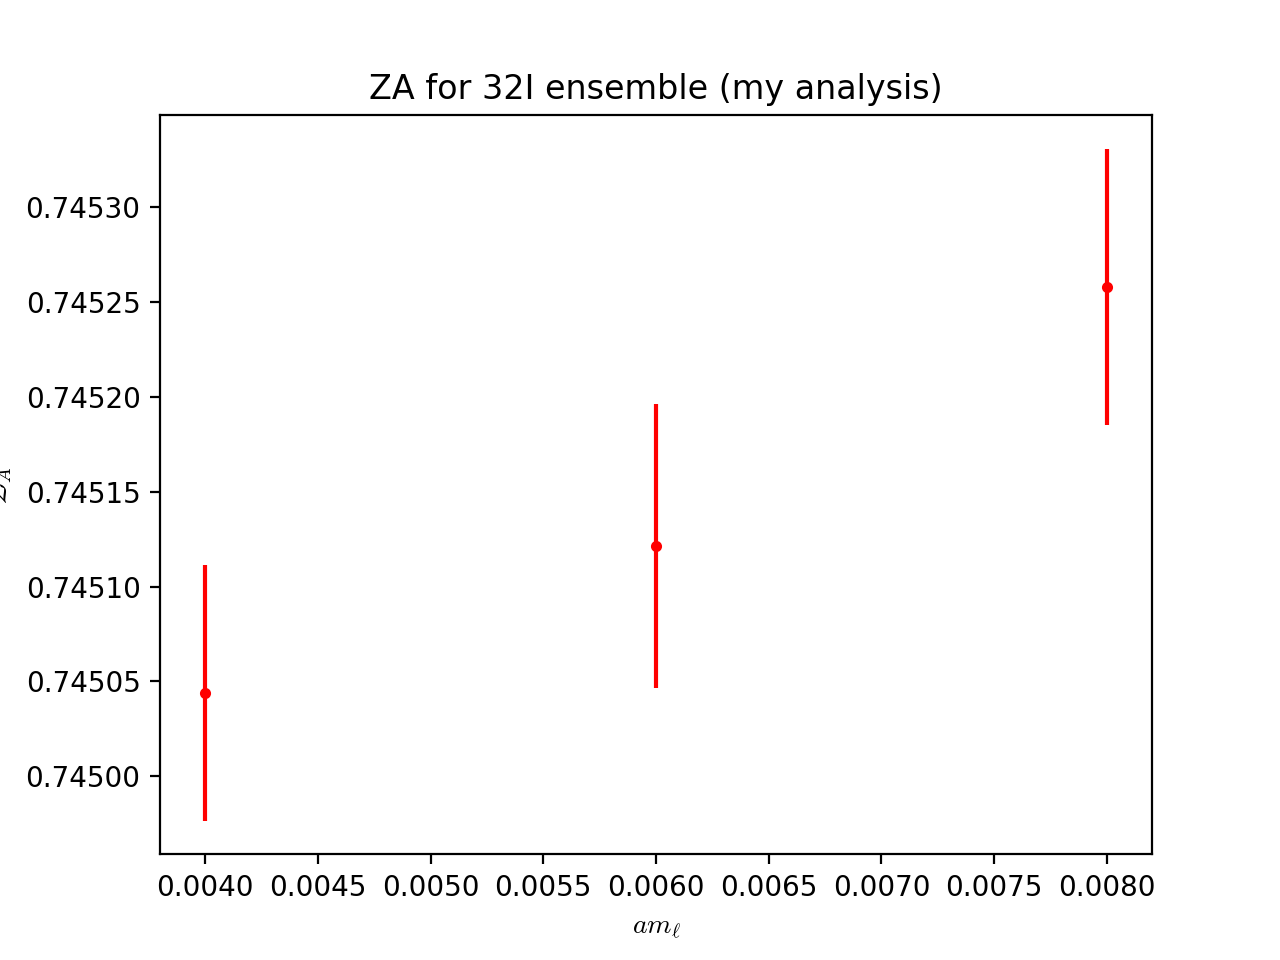

In [74]:
plt.figure()
plt.errorbar(mass_list, ZA_ens_mu, ZA_ens_std, fmt = '.', c = 'r')
plt.title('ZA for 32I ensemble (my analysis)')
plt.ylabel('$\mathcal{Z}_A$')
plt.xlabel('$a m_\ell$')
plt.show()

In [75]:
# use David's results for the chiral extrap
# # uncomment for 24I
# ZA_David_mu = [0.717766, 0.717161]
# ZA_David_sigma = [0.000057, 0.000059]
# uncomment for 32I
ZA_David_mu = [0.745357, 0.745088, 0.745020]
ZA_David_sigma = [0.000044, 0.000032, 0.000040]

In [76]:
# linear extrapolation to amℓ = 0
# n_ens = len(ZA_ens)
n_ens = len(ZA_David_mu)
ZA_superboot = []

# uncomment to use my fit results for ZA
# for ii in range(n_ens):
#     tmp = Superboot(n_ens)
#     tmp.populate_ensemble(ZA_ens[ii], ii)
#     ZA_superboot.append(tmp)

# uncomment to use David's fit results for ZA
for ii in range(n_ens):
    tmp = Superboot(n_ens)
    tmp.gen_fake_ensemble(ZA_David_mu[ii], ZA_David_sigma[ii])
    ZA_superboot.append(tmp)

fit_params, chi2_A, y_extrap_A = uncorr_linear_fit(mass_list, ZA_superboot, 0.0, label = 'ZA')
c0_boots, c1_boots = fit_params[0], fit_params[1]
c0_mu = c0_boots.compute_mean()
c0_std = c0_boots.compute_std()
c1_mu = c1_boots.compute_mean()
c1_std = c1_boots.compute_std()
print('Fit is ZA = ' + str(c1_mu) + ' + ' + str(c0_mu) + '(am_ell)')
print('Chi^2 is: ' + str(chi2_A.compute_mean()))

Extrapolated result for ZA: 0.7446511139319302 \pm 3.2952388879874346e-05
Fit is ZA = 0.7446511139319302 + 0.08207121664161342(am_ell)
Chi^2 is: 5.270695955822868


<IPython.core.display.Javascript object>


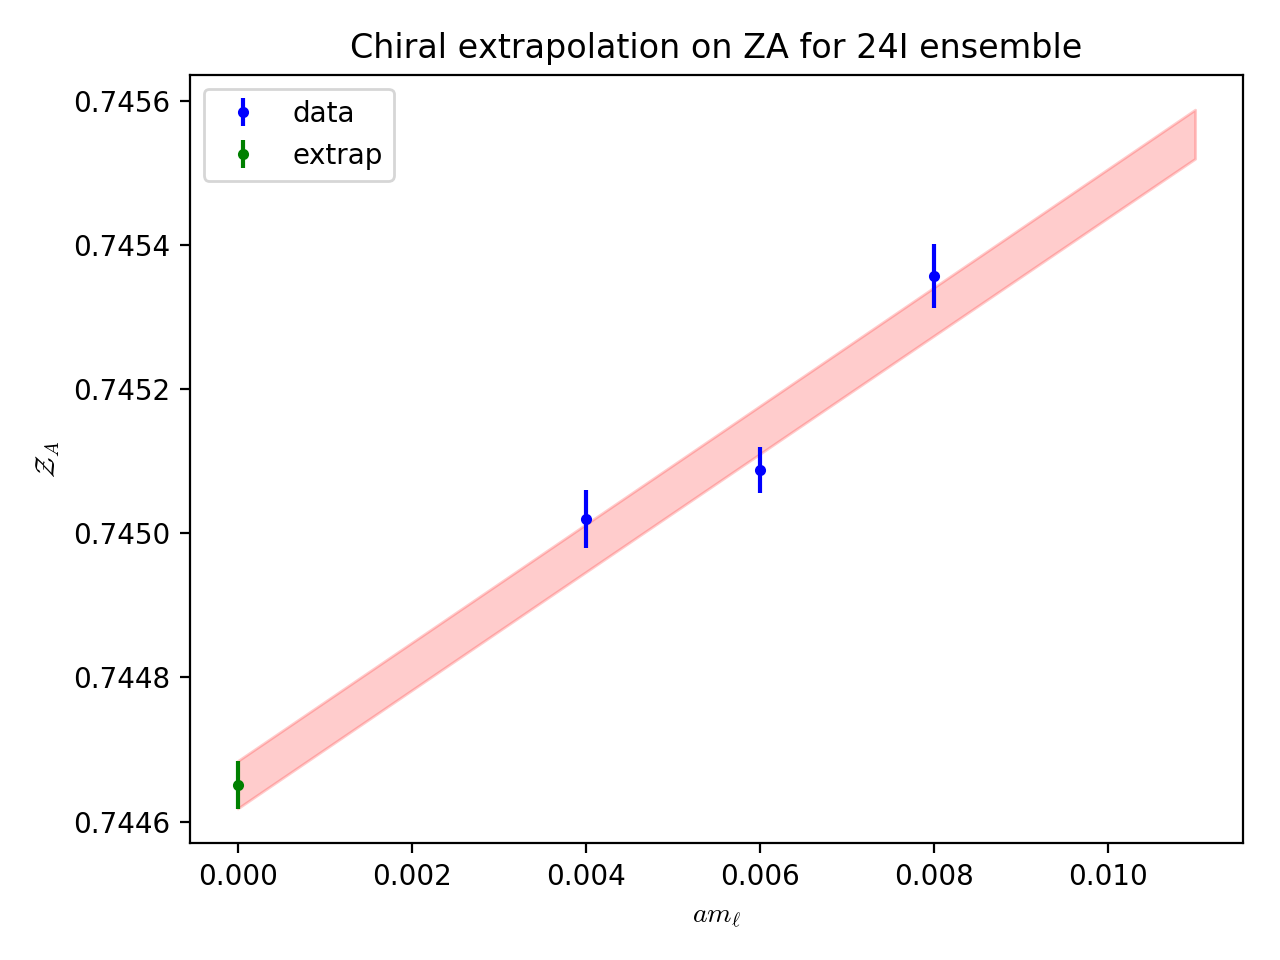

In [77]:
xx = np.linspace(0.0, 0.011)
ydat = c1_mu + c0_mu * xx
# derive this from y = c_1 + c_0 * xx
yerr = np.sqrt(c1_std ** 2 * np.ones(len(xx)) + (c0_std ** 2) * (xx ** 2))
# yerr = c1_std
plt.figure()
# plt.errorbar(mass_list, ZA_ens_mu, ZA_ens_std, fmt = '.', c = 'b', label = 'data')
plt.errorbar(mass_list, ZA_David_mu, ZA_David_sigma, fmt = '.', c = 'b', label = 'data')
plt.fill_between(xx, ydat - yerr, ydat + yerr, alpha = 0.2, color = 'r')
plt.errorbar([0], [c1_mu], [c1_std], fmt = '.', c = 'g', label = 'extrap')
plt.title('Chiral extrapolation on ZA for 24I ensemble')
plt.ylabel('$\mathcal{Z}_A$')
plt.xlabel('$a m_\ell$')
plt.legend(loc = 2)
plt.tight_layout()
plt.show()

In [78]:
# output chiral extrap table
hor_labels_ZA = ['$a m_\\ell$', '$\\mathcal{Z}_A$']
col_labels = [str(m) for m in mass_list]
col_labels.append('chiral')

In [79]:
# ZA_out_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/ZA.h5'
ZA_out_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/ZA.h5'
# fA = h5py.File(ZA_out_path, 'w')
# fA['ZA'] = y_extrap_A.boots
# fA.close()